In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from prophet import Prophet

#Other
import os
import random
import warnings

# ignore warnings
warnings.filterwarnings('ignore')

from pathlib import Path, PureWindowsPath

In [ ]:
import gzip, pickle, pickletools

# create compressed pickle
filepath = "pretrained_OLS2.pkl"
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(model_OLS)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)


with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    model_OLS = p.load()

In [3]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [17]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd
path = path_cwd / 'data/processed'

In [5]:
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the RMSLE value
    return rmsle_value

In [6]:
def train_and_evaluate_by_family_and_store(train_df, test_df):
    results = []
    yhat_values = []  # Store forecasted values
    actual_values = []  # Store actual values
    dates = []  # Store dates
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]
        
        unique_stores = train_family['store_nbr'].unique()
        
        for store_nbr in unique_stores:
            print("Processing store_nbr:", store_nbr)
            train_store = train_family[train_family['store_nbr'] == store_nbr]
            test_store = test_family[test_family['store_nbr'] == store_nbr]

            model_df = train_store[['date', 'sales', 'family', 'store_nbr']]
            model_df.columns = ['ds', 'y', 'family', 'store_nbr']
            model_df['ds'] = pd.to_datetime(model_df['ds'])

            model_df_test = test_store[['date', 'sales', 'family', 'store_nbr']]
            model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
            model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

            m = Prophet()
            m.add_country_holidays(country_name='EC')
            m.fit(model_df)

            forecast = m.predict(model_df_test.drop(columns="y"))
            forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x >= 0 else 0)

            # Append forecasted and actual values to lists
            yhat_values.extend(forecast['yhat'].tolist())
            actual_values.extend(model_df_test['y'].tolist())
            dates.extend(model_df_test['ds'].tolist())

            rmsle_value = evaluate_forecast(model_df_test['y'], forecast['yhat'])
            results.append((family, store_nbr, rmsle_value, len(test_store)))

            print(forecast['yhat'].describe())

    # Aggregate the results
    total_samples = sum([sample_count for _, _, _, sample_count in results])
    weighted_rmsle = sum([rmsle * (sample_count / total_samples) for _, _, rmsle, sample_count in results])

    # Create DataFrame with yhat_values, actual_values, and dates
    df_results = pd.DataFrame({'yhat': yhat_values, 'actual': actual_values, 'date': dates})

    return weighted_rmsle, results, df_results


In [27]:
import gzip, pickle, pickletools

df_test_p = pd.read_pickle(path / 'df_val_fb.pkl')
#df_train_p = pd.read_pickle(path / 'df_train_fb.pkl')

# create compressed pickle
filepath = path / 'df_train_fb.pkl'
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    df_train_p = p.load()

In [28]:
%%time

# Call the function to train and evaluate Prophet models for each family
weighted_rmsle, results, df_results = train_and_evaluate_by_family_and_store(df_train_p, df_test_p)

# Print or use weighted_rmsle as needed
print("Weighted RMSLE:", weighted_rmsle)

Processing family: SCHOOL AND OFFICE SUPPLIES
Processing store_nbr: 25


21:43:55 - cmdstanpy - INFO - Chain [1] start processing
21:43:55 - cmdstanpy - INFO - Chain [1] done processing
21:43:55 - cmdstanpy - INFO - Chain [1] start processing


count    117.000000
mean       0.073169
std        0.070120
min        0.000000
25%        0.000000
50%        0.051787
75%        0.129345
max        0.290412
Name: yhat, dtype: float64
Processing store_nbr: 2


21:43:56 - cmdstanpy - INFO - Chain [1] done processing
21:43:56 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       1.565189
std        0.276322
min        1.069752
25%        1.378520
50%        1.538171
75%        1.744199
max        2.392376
Name: yhat, dtype: float64
Processing store_nbr: 24


21:43:56 - cmdstanpy - INFO - Chain [1] done processing
21:43:56 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.351980
std        0.271394
min        1.715558
25%        2.190716
50%        2.431766
75%        2.567795
max        2.785696
Name: yhat, dtype: float64
Processing store_nbr: 15


21:43:56 - cmdstanpy - INFO - Chain [1] done processing
21:43:56 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.960104
std        1.877655
min        0.000000
25%        0.000000
50%        0.038619
75%        0.427155
max        6.547573
Name: yhat, dtype: float64
Processing store_nbr: 37


21:43:57 - cmdstanpy - INFO - Chain [1] done processing
21:43:57 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.307879
std        0.190270
min        0.853742
25%        1.153440
50%        1.343458
75%        1.459242
max        1.649425
Name: yhat, dtype: float64
Processing store_nbr: 17


21:43:57 - cmdstanpy - INFO - Chain [1] done processing
21:43:57 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.053461
std        1.669337
min        0.000000
25%        0.059659
50%        0.314493
75%        0.778971
max        5.771687
Name: yhat, dtype: float64
Processing store_nbr: 27


21:43:57 - cmdstanpy - INFO - Chain [1] done processing
21:43:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.114532
std        0.155688
min        0.764330
25%        1.028574
50%        1.102906
75%        1.206204
max        1.534080
Name: yhat, dtype: float64
Processing store_nbr: 26


21:43:58 - cmdstanpy - INFO - Chain [1] done processing
21:43:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.717311
std        0.260303
min        1.128180
25%        1.511514
50%        1.729090
75%        1.932097
max        2.249057
Name: yhat, dtype: float64
Processing store_nbr: 18


21:43:58 - cmdstanpy - INFO - Chain [1] done processing


count    110.000000
mean       0.861390
std        0.876284
min        0.000000
25%        0.000000
50%        0.661149
75%        1.331606
max        3.440923
Name: yhat, dtype: float64
Processing store_nbr: 3


21:43:58 - cmdstanpy - INFO - Chain [1] start processing
21:43:59 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       1.772828
std        0.300819
min        1.128722
25%        1.618338
50%        1.778445
75%        2.002773
max        2.366431
Name: yhat, dtype: float64
Processing store_nbr: 23


21:43:59 - cmdstanpy - INFO - Chain [1] start processing
21:43:59 - cmdstanpy - INFO - Chain [1] done processing
21:43:59 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.179795
std        0.098714
min        0.007120
25%        0.103818
50%        0.192641
75%        0.240000
max        0.410112
Name: yhat, dtype: float64
Processing store_nbr: 19


21:43:59 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.467178
std        2.412990
min        0.000000
25%        0.000000
50%        0.454844
75%        1.141512
max        8.564932
Name: yhat, dtype: float64
Processing store_nbr: 28


21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.697880
std        1.294448
min        3.887312
25%        5.832935
50%        6.779008
75%        7.697827
max        9.959309
Name: yhat, dtype: float64
Processing store_nbr: 30


21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.123475
std        0.356740
min        1.282264
25%        1.846818
50%        2.265653
75%        2.403930
max        2.584357
Name: yhat, dtype: float64
Processing store_nbr: 33


21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:01 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.671059
std        0.558089
min        2.371790
25%        3.296798
50%        3.721720
75%        4.131641
max        4.553395
Name: yhat, dtype: float64
Processing store_nbr: 16


21:44:01 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.718315
std        0.438680
min        1.751757
25%        2.401319
50%        2.750891
75%        3.089241
max        3.421325
Name: yhat, dtype: float64
Processing store_nbr: 1


21:44:01 - cmdstanpy - INFO - Chain [1] start processing
21:44:01 - cmdstanpy - INFO - Chain [1] done processing
21:44:02 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.284185
std        0.108342
min        0.016030
25%        0.205223
50%        0.282377
75%        0.383246
max        0.526656
Name: yhat, dtype: float64
Processing store_nbr: 35


21:44:02 - cmdstanpy - INFO - Chain [1] done processing
21:44:02 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.704186
std        0.570235
min        2.357894
25%        3.319509
50%        3.737570
75%        4.168122
max        4.705721
Name: yhat, dtype: float64
Processing store_nbr: 34


21:44:02 - cmdstanpy - INFO - Chain [1] done processing
21:44:02 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       6.064658
std        1.321677
min        3.426998
25%        5.109607
50%        5.998678
75%        6.996638
max        9.282966
Name: yhat, dtype: float64
Processing store_nbr: 32


21:44:02 - cmdstanpy - INFO - Chain [1] done processing
21:44:03 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.129910
std        0.183590
min        0.720223
25%        0.996573
50%        1.138260
75%        1.279601
max        1.422478
Name: yhat, dtype: float64
Processing store_nbr: 31


21:44:03 - cmdstanpy - INFO - Chain [1] done processing
21:44:03 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.782985
std        0.535877
min        1.748515
25%        2.300790
50%        2.790529
75%        3.211721
max        4.021115
Name: yhat, dtype: float64
Processing store_nbr: 39


21:44:03 - cmdstanpy - INFO - Chain [1] done processing
21:44:03 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.589940
std        3.323918
min        0.931119
25%        2.422731
50%        3.178652
75%        5.483393
max       13.550904
Name: yhat, dtype: float64
Processing store_nbr: 9


21:44:03 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      10.253239
std        9.943221
min        0.000000
25%        4.341432
50%        6.297227
75%       10.463580
max       41.071239
Name: yhat, dtype: float64
Processing store_nbr: 38


21:44:04 - cmdstanpy - INFO - Chain [1] start processing
21:44:04 - cmdstanpy - INFO - Chain [1] done processing
21:44:04 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.524135
std        0.156196
min        0.246187
25%        0.381430
50%        0.534988
75%        0.660318
max        0.808687
Name: yhat, dtype: float64
Processing store_nbr: 4


21:44:04 - cmdstanpy - INFO - Chain [1] done processing
21:44:05 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.978629
std        0.177350
min        0.622391
25%        0.799438
50%        1.017838
75%        1.125317
max        1.278986
Name: yhat, dtype: float64
Processing store_nbr: 14


21:44:05 - cmdstanpy - INFO - Chain [1] done processing
21:44:05 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.659915
std        1.412292
min        0.000000
25%        0.000000
50%        0.000000
75%        0.081636
max        4.853373
Name: yhat, dtype: float64
Processing store_nbr: 40


21:44:05 - cmdstanpy - INFO - Chain [1] done processing
21:44:05 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       9.073250
std        1.423975
min        5.976122
25%        8.004134
50%        9.150107
75%       10.239262
max       11.163483
Name: yhat, dtype: float64
Processing store_nbr: 41


21:44:05 - cmdstanpy - INFO - Chain [1] done processing
21:44:06 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.713523
std        0.268824
min        1.157243
25%        1.494347
50%        1.793053
75%        1.915293
max        2.205937
Name: yhat, dtype: float64
Processing store_nbr: 44


21:44:06 - cmdstanpy - INFO - Chain [1] done processing
21:44:06 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      11.050608
std       21.450838
min        0.000000
25%        0.000000
50%        0.000000
75%        6.928605
max       74.837265
Name: yhat, dtype: float64
Processing store_nbr: 13


21:44:06 - cmdstanpy - INFO - Chain [1] done processing
21:44:06 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.303920
std        2.036483
min        0.000000
25%        0.120074
50%        0.495184
75%        0.982020
max        7.352837
Name: yhat, dtype: float64
Processing store_nbr: 43


21:44:07 - cmdstanpy - INFO - Chain [1] done processing
21:44:07 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       3.144865
std        0.490439
min        1.991825
25%        2.820925
50%        3.158642
75%        3.522535
max        4.061111
Name: yhat, dtype: float64
Processing store_nbr: 45


21:44:07 - cmdstanpy - INFO - Chain [1] done processing
21:44:07 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      23.595693
std       22.433397
min        4.182978
25%        9.287082
50%       14.890293
75%       24.328621
max       90.072253
Name: yhat, dtype: float64
Processing store_nbr: 47


21:44:07 - cmdstanpy - INFO - Chain [1] done processing
21:44:08 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      15.729273
std       13.440577
min        3.225580
25%        7.177214
50%        9.677998
75%       16.284491
max       55.269998
Name: yhat, dtype: float64
Processing store_nbr: 46


21:44:08 - cmdstanpy - INFO - Chain [1] done processing
21:44:08 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      20.553036
std       21.044591
min        2.592447
25%        7.750965
50%       12.040005
75%       19.416108
max       83.824422
Name: yhat, dtype: float64
Processing store_nbr: 12


21:44:08 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.463717
std        2.372029
min        0.000000
25%        0.085282
50%        0.486763
75%        1.001749
max        8.596627
Name: yhat, dtype: float64
Processing store_nbr: 49


21:44:08 - cmdstanpy - INFO - Chain [1] start processing
21:44:08 - cmdstanpy - INFO - Chain [1] done processing
21:44:09 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.876249
std       11.608918
min        0.000000
25%        3.159398
50%        4.481972
75%        9.286734
max       44.128974
Name: yhat, dtype: float64
Processing store_nbr: 48


21:44:09 - cmdstanpy - INFO - Chain [1] done processing
21:44:09 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      23.905531
std       29.588953
min        0.000000
25%        6.003685
50%       12.077803
75%       21.855360
max      112.083062
Name: yhat, dtype: float64
Processing store_nbr: 5


21:44:09 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.354322
std        0.277872
min        0.000000
25%        0.116370
50%        0.282457
75%        0.590487
max        0.950520
Name: yhat, dtype: float64
Processing store_nbr: 51


21:44:10 - cmdstanpy - INFO - Chain [1] start processing
21:44:10 - cmdstanpy - INFO - Chain [1] done processing
21:44:10 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      21.539626
std        3.687687
min       13.921404
25%       18.641071
50%       22.331467
75%       24.485172
max       28.534787
Name: yhat, dtype: float64
Processing store_nbr: 50


21:44:10 - cmdstanpy - INFO - Chain [1] done processing
21:44:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       5.782290
std       12.057048
min        0.000000
25%        0.000000
50%        0.000000
75%        1.106480
max       41.540288
Name: yhat, dtype: float64
Processing store_nbr: 11


21:44:10 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       9.650130
std        8.524160
min        0.882357
25%        4.652698
50%        6.481425
75%        9.378751
max       34.877715
Name: yhat, dtype: float64
Processing store_nbr: 6


21:44:11 - cmdstanpy - INFO - Chain [1] start processing
21:44:11 - cmdstanpy - INFO - Chain [1] done processing
21:44:11 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.936589
std        0.124391
min        0.636577
25%        0.878770
50%        0.946339
75%        1.019187
max        1.274046
Name: yhat, dtype: float64
Processing store_nbr: 10


21:44:11 - cmdstanpy - INFO - Chain [1] done processing
21:44:12 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.042576
std        2.064827
min        0.000000
25%        0.000000
50%        0.019674
75%        0.475214
max        7.209650
Name: yhat, dtype: float64
Processing store_nbr: 54


21:44:12 - cmdstanpy - INFO - Chain [1] done processing
21:44:12 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       1.376463
std        0.206015
min        0.892204
25%        1.209182
50%        1.459677
75%        1.523276
max        1.667511
Name: yhat, dtype: float64
Processing store_nbr: 8


21:44:12 - cmdstanpy - INFO - Chain [1] done processing
21:44:12 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.898849
std        0.195098
min        0.476397
25%        0.799362
50%        0.909007
75%        1.036754
max        1.356081
Name: yhat, dtype: float64
Processing store_nbr: 7


21:44:12 - cmdstanpy - INFO - Chain [1] done processing
21:44:13 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.193661
std        0.173486
min        0.896824
25%        1.032234
50%        1.238991
75%        1.354218
max        1.480174
Name: yhat, dtype: float64
Processing store_nbr: 36


21:44:13 - cmdstanpy - INFO - Chain [1] done processing
21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:13 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       5.474856
std        0.954006
min        3.333030
25%        4.783072
50%        5.457395
75%        6.322021
max        7.282771
Name: yhat, dtype: float64
Processing store_nbr: 53


21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:13 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.414290
std        0.104121
min        0.104125
25%        0.338000
50%        0.356486
75%        0.489419
max        0.625336
Name: yhat, dtype: float64
Processing store_nbr: 20


21:44:14 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.123919
std        0.405180
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.234556
Name: yhat, dtype: float64
Processing store_nbr: 29


21:44:14 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.507975
std        1.488051
min        0.742252
25%        4.482326
50%        5.342121
75%        6.345780
max        9.423586
Name: yhat, dtype: float64
Processing store_nbr: 21


21:44:14 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      17.900602
std        4.910269
min        8.763272
25%       13.718970
50%       17.843458
75%       22.112324
max       27.906290
Name: yhat, dtype: float64
Processing store_nbr: 42


21:44:14 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.711382
std        0.206048
min        0.347226
25%        0.561242
50%        0.700902
75%        0.809609
max        1.197899
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       1.122429
std        0.261838
min        0.639387
25%        0.918662
50%        1.111037
75%        1.280058
max        1.822820
Name: yhat, dtype: float64
Processing family: BABY CARE
Processing store_nbr: 25
count    118.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 23
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 26
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 19


21:44:15 - cmdstanpy - INFO - Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.182172
std        0.029079
min        0.115623
25%        0.161929
50%        0.179104
75%        0.201213
max        0.256143
Name: yhat, dtype: float64
Processing store_nbr: 24
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 18


21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing


count    110.000000
mean       0.185346
std        0.042781
min        0.106328
25%        0.156984
50%        0.179091
75%        0.211815
max        0.332873
Name: yhat, dtype: float64
Processing store_nbr: 28
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 27


21:44:16 - cmdstanpy - INFO - Chain [1] start processing


count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 17


21:44:16 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.266639
std        0.067466
min        0.175579
25%        0.224869
50%        0.244585
75%        0.279501
max        0.453301
Name: yhat, dtype: float64
Processing store_nbr: 30


21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.151057
std        0.048777
min        0.060951
25%        0.122267
50%        0.141151
75%        0.167623
max        0.299622
Name: yhat, dtype: float64
Processing store_nbr: 3
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 34


21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.844276
std        0.166358
min        0.588010
25%        0.729009
50%        0.802040
75%        0.900065
max        1.247158
Name: yhat, dtype: float64
Processing store_nbr: 33


21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.035540
std        0.135184
min        0.737700
25%        0.927550
50%        1.044576
75%        1.147421
max        1.282842
Name: yhat, dtype: float64
Processing store_nbr: 31


21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.478337
std        0.711683
min        1.365341
25%        1.779393
50%        2.593976
75%        3.119493
max        3.715275
Name: yhat, dtype: float64
Processing store_nbr: 16


21:44:19 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.528364
std        0.114993
min        0.278224
25%        0.454991
50%        0.494878
75%        0.614964
max        0.784796
Name: yhat, dtype: float64
Processing store_nbr: 1
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 37


21:44:19 - cmdstanpy - INFO - Chain [1] start processing


count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 35


21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:20 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.383764
std        0.079037
min        0.249550
25%        0.327948
50%        0.367462
75%        0.422809
max        0.598032
Name: yhat, dtype: float64
Processing store_nbr: 32


21:44:20 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.090807
std        0.063624
min        0.000000
25%        0.051738
50%        0.068892
75%        0.103671
max        0.290253
Name: yhat, dtype: float64
Processing store_nbr: 4
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 39


21:44:20 - cmdstanpy - INFO - Chain [1] start processing
21:44:20 - cmdstanpy - INFO - Chain [1] done processing
21:44:20 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.778517
std        0.148385
min        0.509987
25%        0.649293
50%        0.798640
75%        0.901717
max        1.056871
Name: yhat, dtype: float64
Processing store_nbr: 15


21:44:21 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.257044
std        0.908119
min        0.000000
25%        0.621096
50%        1.124057
75%        1.762277
max        4.008517
Name: yhat, dtype: float64
Processing store_nbr: 38
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 2
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 14
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 40


21:44:21 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       1.147316
std        0.214478
min        0.724348
25%        0.969548
50%        1.134533
75%        1.303963
max        1.666104
Name: yhat, dtype: float64
Processing store_nbr: 41
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 43


21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.032826
std        0.068473
min        0.000000
25%        0.000000
50%        0.000000
75%        0.013239
max        0.251051
Name: yhat, dtype: float64
Processing store_nbr: 44
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 13
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 45
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 46


21:44:23 - cmdstanpy - INFO - Chain [1] start processing


count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 12


21:44:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.508625
std        0.076758
min        0.350070
25%        0.444596
50%        0.512982
75%        0.575123
max        0.634610
Name: yhat, dtype: float64
Processing store_nbr: 47
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 48
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 5
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 49
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 50
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        

21:44:24 - cmdstanpy - INFO - Chain [1] start processing
21:44:24 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.979971
std        0.220232
min        0.601952
25%        0.829158
50%        0.980439
75%        1.109391
max        1.564347
Name: yhat, dtype: float64
Processing store_nbr: 51
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 11


21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.406884
std        0.122554
min        0.231985
25%        0.316142
50%        0.387705
75%        0.470023
max        0.774323
Name: yhat, dtype: float64
Processing store_nbr: 6
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 9


21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.536196
std        0.134688
min        0.229470
25%        0.444558
50%        0.539504
75%        0.641031
max        0.816932
Name: yhat, dtype: float64
Processing store_nbr: 7
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 10


21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.111531
std        0.678612
min        0.254430
25%        0.550679
50%        0.920484
75%        1.499174
max        2.750999
Name: yhat, dtype: float64
Processing store_nbr: 8
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 36


21:44:27 - cmdstanpy - INFO - Chain [1] start processing
21:44:27 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.405852
std        0.052262
min        0.269080
25%        0.368328
50%        0.409223
75%        0.450357
max        0.499740
Name: yhat, dtype: float64
Processing store_nbr: 53
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 20


21:44:27 - cmdstanpy - INFO - Chain [1] start processing
21:44:27 - cmdstanpy - INFO - Chain [1] done processing
21:44:27 - cmdstanpy - INFO - Chain [1] start processing
21:44:27 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.069738
std        0.234003
min        0.700521
25%        0.913200
50%        1.022541
75%        1.160884
max        1.728699
Name: yhat, dtype: float64
Processing store_nbr: 29


21:44:28 - cmdstanpy - INFO - Chain [1] start processing
21:44:28 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.813881
std        0.146624
min        0.517105
25%        0.699928
50%        0.811883
75%        0.926864
max        1.153589
Name: yhat, dtype: float64
Processing store_nbr: 21
count    160.000000
mean       0.977657
std        0.207382
min        0.534523
25%        0.837386
50%        0.977968
75%        1.133330
max        1.451507
Name: yhat, dtype: float64
Processing store_nbr: 42
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 22


21:44:28 - cmdstanpy - INFO - Chain [1] start processing
21:44:28 - cmdstanpy - INFO - Chain [1] done processing
21:44:28 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.923206
std        0.198737
min        0.550341
25%        0.767434
50%        0.925347
75%        1.064630
max        1.424182
Name: yhat, dtype: float64
Processing family: BEAUTY
Processing store_nbr: 25


21:44:28 - cmdstanpy - INFO - Chain [1] done processing
21:44:29 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean       3.317679
std        0.961982
min        1.737694
25%        2.550405
50%        3.114574
75%        3.842888
max        5.887757
Name: yhat, dtype: float64
Processing store_nbr: 23


21:44:29 - cmdstanpy - INFO - Chain [1] done processing
21:44:29 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       2.129192
std        0.588680
min        1.076443
25%        1.664099
50%        2.076665
75%        2.451412
max        3.754606
Name: yhat, dtype: float64
Processing store_nbr: 2


21:44:29 - cmdstanpy - INFO - Chain [1] done processing
21:44:29 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       6.454252
std        1.118356
min        4.659715
25%        5.617609
50%        6.105267
75%        7.416796
max        9.219524
Name: yhat, dtype: float64
Processing store_nbr: 26


21:44:29 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.364325
std        0.343417
min        0.800050
25%        1.058711
50%        1.372339
75%        1.564992
max        2.440220
Name: yhat, dtype: float64
Processing store_nbr: 19


21:44:30 - cmdstanpy - INFO - Chain [1] start processing
21:44:30 - cmdstanpy - INFO - Chain [1] done processing
21:44:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.388091
std        0.509605
min        0.303321
25%        1.117347
50%        1.320502
75%        1.630995
max        2.716972
Name: yhat, dtype: float64
Processing store_nbr: 24


21:44:30 - cmdstanpy - INFO - Chain [1] done processing
21:44:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       7.309226
std        1.031950
min        5.449315
25%        6.630209
50%        7.152205
75%        7.905308
max       10.078851
Name: yhat, dtype: float64
Processing store_nbr: 18


21:44:31 - cmdstanpy - INFO - Chain [1] done processing
21:44:31 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean       1.986352
std        0.787639
min        0.715165
25%        1.356034
50%        2.033900
75%        2.430734
max        3.973213
Name: yhat, dtype: float64
Processing store_nbr: 28


21:44:31 - cmdstanpy - INFO - Chain [1] done processing
21:44:31 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.238020
std        0.641342
min        0.884096
25%        1.878383
50%        2.133075
75%        2.555965
max        4.376076
Name: yhat, dtype: float64
Processing store_nbr: 27


21:44:31 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.713312
std        1.233605
min        4.727399
25%        5.756796
50%        6.553008
75%        7.464988
max       11.295395
Name: yhat, dtype: float64
Processing store_nbr: 3


21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:32 - cmdstanpy - INFO - Chain [1] done processing
21:44:32 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      14.469485
std        3.028253
min        9.941650
25%       12.152560
50%       13.925181
75%       16.027646
max       22.536081
Name: yhat, dtype: float64
Processing store_nbr: 17


21:44:32 - cmdstanpy - INFO - Chain [1] done processing
21:44:32 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.625192
std        0.585509
min        1.508025
25%        2.208596
50%        2.601318
75%        2.889584
max        5.720827
Name: yhat, dtype: float64
Processing store_nbr: 30


21:44:32 - cmdstanpy - INFO - Chain [1] done processing
21:44:33 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.464329
std        0.328560
min        0.697530
25%        1.295462
50%        1.520142
75%        1.669466
max        2.663184
Name: yhat, dtype: float64
Processing store_nbr: 34


21:44:33 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       3.975303
std        0.671440
min        2.506542
25%        3.552084
50%        3.928225
75%        4.495964
max        5.513961
Name: yhat, dtype: float64
Processing store_nbr: 31


21:44:33 - cmdstanpy - INFO - Chain [1] start processing
21:44:33 - cmdstanpy - INFO - Chain [1] done processing
21:44:34 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.424691
std        0.702737
min        1.601800
25%        2.942986
50%        3.256650
75%        3.996689
max        4.923588
Name: yhat, dtype: float64
Processing store_nbr: 16


21:44:34 - cmdstanpy - INFO - Chain [1] done processing
21:44:34 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.708489
std        0.316725
min        0.000000
25%        0.488746
50%        0.686532
75%        0.882877
max        2.415737
Name: yhat, dtype: float64
Processing store_nbr: 1


21:44:34 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       2.744621
std        0.556766
min        0.489834
25%        2.546285
50%        2.851650
75%        3.111111
max        3.681057
Name: yhat, dtype: float64
Processing store_nbr: 33


21:44:34 - cmdstanpy - INFO - Chain [1] start processing
21:44:34 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.132628
std        0.241917
min        0.762530
25%        0.955117
50%        1.074518
75%        1.259334
max        2.378348
Name: yhat, dtype: float64
Processing store_nbr: 37


21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.409796
std        0.926423
min        0.621647
25%        3.827361
50%        4.366944
75%        4.990940
max        7.036841
Name: yhat, dtype: float64
Processing store_nbr: 35


21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.344646
std        0.156138
min        0.081933
25%        0.245921
50%        0.310240
75%        0.447338
max        0.820302
Name: yhat, dtype: float64
Processing store_nbr: 32


21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.379672
std        0.151867
min        0.101305
25%        0.266258
50%        0.343062
75%        0.474627
max        0.716512
Name: yhat, dtype: float64
Processing store_nbr: 39


21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.858343
std        1.212548
min        3.070722
25%        5.089048
50%        5.721682
75%        6.743248
max        8.525961
Name: yhat, dtype: float64
Processing store_nbr: 4


21:44:36 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       5.629362
std        1.549289
min        2.554297
25%        4.370477
50%        5.451682
75%        6.214195
max        9.955641
Name: yhat, dtype: float64
Processing store_nbr: 15


21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.498016
std        0.353352
min        0.625172
25%        1.238503
50%        1.498408
75%        1.749072
max        2.381714
Name: yhat, dtype: float64
Processing store_nbr: 38


21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       5.777735
std        1.666359
min        3.200526
25%        4.415951
50%        5.287142
75%        7.093676
max       10.966863
Name: yhat, dtype: float64
Processing store_nbr: 40


21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:38 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.978669
std        0.247803
min        0.540939
25%        0.803517
50%        0.972845
75%        1.141684
max        1.627723
Name: yhat, dtype: float64
Processing store_nbr: 41


21:44:38 - cmdstanpy - INFO - Chain [1] done processing
21:44:38 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.817058
std        1.148457
min        4.009580
25%        5.022175
50%        5.426525
75%        6.508910
max        9.742843
Name: yhat, dtype: float64
Processing store_nbr: 14


21:44:38 - cmdstanpy - INFO - Chain [1] done processing
21:44:38 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.266779
std        0.429737
min        0.000000
25%        0.000000
50%        0.069076
75%        0.242745
max        1.680408
Name: yhat, dtype: float64
Processing store_nbr: 43


21:44:38 - cmdstanpy - INFO - Chain [1] done processing
21:44:39 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.619705
std        0.231465
min        0.000000
25%        0.472589
50%        0.614732
75%        0.767722
max        1.756851
Name: yhat, dtype: float64
Processing store_nbr: 44


21:44:39 - cmdstanpy - INFO - Chain [1] done processing
21:44:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      14.522588
std        3.962003
min        4.070487
25%       11.073710
50%       14.027279
75%       16.616316
max       23.645621
Name: yhat, dtype: float64
Processing store_nbr: 13


21:44:39 - cmdstanpy - INFO - Chain [1] done processing
21:44:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.981414
std        0.363241
min        0.000000
25%        0.735459
50%        0.917716
75%        1.149261
max        2.390335
Name: yhat, dtype: float64
Processing store_nbr: 45


21:44:39 - cmdstanpy - INFO - Chain [1] done processing
21:44:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      14.511329
std        3.305821
min        9.112573
25%       12.216558
50%       13.597069
75%       16.340030
max       22.311268
Name: yhat, dtype: float64
Processing store_nbr: 46


21:44:40 - cmdstanpy - INFO - Chain [1] done processing
21:44:40 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      15.214326
std        4.388851
min        9.225011
25%       12.117986
50%       13.369177
75%       18.535167
max       28.741367
Name: yhat, dtype: float64
Processing store_nbr: 47


21:44:40 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      16.936995
std        4.309772
min        9.072592
25%       14.474566
50%       15.828668
75%       18.712732
max       31.352094
Name: yhat, dtype: float64
Processing store_nbr: 12


21:44:40 - cmdstanpy - INFO - Chain [1] start processing
21:44:41 - cmdstanpy - INFO - Chain [1] done processing
21:44:41 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.960973
std        0.251786
min        0.396287
25%        0.790543
50%        0.949302
75%        1.140504
max        1.666275
Name: yhat, dtype: float64
Processing store_nbr: 48


21:44:41 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      15.656276
std        4.120755
min        9.804607
25%       12.928086
50%       14.469178
75%       18.191325
max       34.574542
Name: yhat, dtype: float64
Processing store_nbr: 5


21:44:41 - cmdstanpy - INFO - Chain [1] start processing
21:44:41 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.905463
std        1.056474
min        5.342756
25%        6.066378
50%        6.580409
75%        7.621469
max        9.465874
Name: yhat, dtype: float64
Processing store_nbr: 50


21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.367708
std        2.286109
min        8.428945
25%       10.803353
50%       11.679128
75%       14.022988
max       23.850675
Name: yhat, dtype: float64
Processing store_nbr: 49


21:44:42 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       8.857974
std        2.008891
min        5.363381
25%        7.648733
50%        8.258600
75%       10.128120
max       16.755139
Name: yhat, dtype: float64
Processing store_nbr: 54


21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.457339
std        0.291676
min        0.000000
25%        0.263720
50%        0.417123
75%        0.607744
max        2.171299
Name: yhat, dtype: float64
Processing store_nbr: 51


21:44:43 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.456193
std        1.318941
min        3.562087
25%        4.496034
50%        5.019804
75%        6.271650
max       12.782165
Name: yhat, dtype: float64
Processing store_nbr: 11


21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       8.187691
std        1.392097
min        5.368773
25%        7.255762
50%        8.193436
75%        8.872265
max       11.236142
Name: yhat, dtype: float64
Processing store_nbr: 6


21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       9.926960
std        2.044543
min        6.306473
25%        8.615081
50%        9.609773
75%       10.907141
max       15.713525
Name: yhat, dtype: float64
Processing store_nbr: 9


21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       6.485500
std        1.549715
min        4.197941
25%        5.399464
50%        6.072899
75%        7.143464
max       11.593808
Name: yhat, dtype: float64
Processing store_nbr: 7


21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:45 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.017349
std        0.724051
min        3.485171
25%        4.516405
50%        5.030366
75%        5.517003
max        6.440380
Name: yhat, dtype: float64
Processing store_nbr: 10


21:44:45 - cmdstanpy - INFO - Chain [1] done processing
21:44:45 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.170326
std        0.467027
min        1.336394
25%        1.781934
50%        2.141789
75%        2.500281
max        3.345220
Name: yhat, dtype: float64
Processing store_nbr: 8


21:44:45 - cmdstanpy - INFO - Chain [1] done processing
21:44:45 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      10.183722
std        1.681267
min        6.977361
25%        8.995039
50%        9.602065
75%       11.902544
max       13.815676
Name: yhat, dtype: float64
Processing store_nbr: 36


21:44:46 - cmdstanpy - INFO - Chain [1] done processing
21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:46 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.494455
std        0.450163
min        1.529084
25%        2.136056
50%        2.506731
75%        2.816730
max        3.649614
Name: yhat, dtype: float64
Processing store_nbr: 53


21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:46 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.082171
std        1.033639
min        4.478176
25%        5.347465
50%        5.767202
75%        6.521800
max        9.756368
Name: yhat, dtype: float64
Processing store_nbr: 20


21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:46 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       7.374018
std        2.066278
min        4.822864
25%        5.968585
50%        6.586709
75%        8.255446
max       12.564452
Name: yhat, dtype: float64
Processing store_nbr: 29


21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       3.683328
std        0.917932
min        0.490997
25%        3.098389
50%        3.385619
75%        3.955801
max        6.663712
Name: yhat, dtype: float64
Processing store_nbr: 21


21:44:47 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       7.307808
std        2.162766
min        4.002722
25%        5.708342
50%        6.918779
75%        8.097531
max       13.137588
Name: yhat, dtype: float64
Processing store_nbr: 42


21:44:47 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       3.729118
std        2.058283
min        1.580218
25%        2.283237
50%        2.738089
75%        6.198892
max        7.786563
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       0.902071
std        0.517254
min        0.119906
25%        0.490468
50%        0.742185
75%        1.432467
max        1.878511
Name: yhat, dtype: float64
Processing family: PRODUCE
Processing store_nbr: 25


21:44:47 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1] done processing


count     118.000000
mean     2089.089809
std       391.534461
min      1364.262348
25%      1792.547320
50%      2099.866686
75%      2383.435820
max      2889.587914
Name: yhat, dtype: float64
Processing store_nbr: 2


21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:48 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     3742.517540
std       796.382572
min      2192.732882
25%      3210.638205
50%      3817.660256
75%      4382.478707
max      5171.272809
Name: yhat, dtype: float64
Processing store_nbr: 24


21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:48 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     5121.150806
std      1054.155551
min      2794.085493
25%      4595.342115
50%      5313.989568
75%      5793.779354
max      7350.923533
Name: yhat, dtype: float64
Processing store_nbr: 37


21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] done processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     3785.610796
std       883.360779
min      2004.919203
25%      3242.828036
50%      3841.364680
75%      4513.215245
max      5651.695035
Name: yhat, dtype: float64
Processing store_nbr: 23


21:44:49 - cmdstanpy - INFO - Chain [1] done processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     1725.527198
std       356.256085
min      1028.662554
25%      1490.516702
50%      1752.059963
75%      2061.501808
max      2351.321782
Name: yhat, dtype: float64
Processing store_nbr: 17


21:44:50 - cmdstanpy - INFO - Chain [1] done processing
21:44:50 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1824.080353
std       335.734873
min      1136.430362
25%      1579.845754
50%      1879.068876
75%      2069.095612
max      2420.559511
Name: yhat, dtype: float64
Processing store_nbr: 27


21:44:50 - cmdstanpy - INFO - Chain [1] done processing
21:44:50 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     3794.497328
std       778.160603
min      2139.390984
25%      3315.046825
50%      3958.757089
75%      4391.028060
max      5044.905565
Name: yhat, dtype: float64
Processing store_nbr: 26


21:44:50 - cmdstanpy - INFO - Chain [1] done processing
21:44:51 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      746.369641
std       169.123016
min       422.514838
25%       641.039245
50%       763.305110
75%       864.835535
max      1103.170517
Name: yhat, dtype: float64
Processing store_nbr: 18


21:44:51 - cmdstanpy - INFO - Chain [1] done processing


count     110.000000
mean     2005.971850
std       413.026412
min      1251.641904
25%      1700.799866
50%      2022.853306
75%      2312.456169
max      2873.671402
Name: yhat, dtype: float64
Processing store_nbr: 19


21:44:51 - cmdstanpy - INFO - Chain [1] start processing
21:44:51 - cmdstanpy - INFO - Chain [1] done processing
21:44:51 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     630.662939
std      122.967735
min      384.646085
25%      551.156830
50%      647.917817
75%      728.647344
max      832.826560
Name: yhat, dtype: float64
Processing store_nbr: 3


21:44:52 - cmdstanpy - INFO - Chain [1] done processing


count      161.000000
mean     11507.391501
std       2418.556980
min       6731.564104
25%       9834.158227
50%      11691.432051
75%      13524.999266
max      15755.507339
Name: yhat, dtype: float64
Processing store_nbr: 28


21:44:52 - cmdstanpy - INFO - Chain [1] start processing
21:44:52 - cmdstanpy - INFO - Chain [1] done processing
21:44:52 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2053.989246
std       467.247889
min      1095.453282
25%      1786.433049
50%      2117.350782
75%      2340.791498
max      2991.337185
Name: yhat, dtype: float64
Processing store_nbr: 30


21:44:52 - cmdstanpy - INFO - Chain [1] done processing
21:44:53 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      723.802249
std       164.590263
min       403.828835
25%       626.546267
50%       730.605786
75%       831.993824
max      1136.739675
Name: yhat, dtype: float64
Processing store_nbr: 33


21:44:53 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     1755.942219
std       389.702836
min       949.030815
25%      1492.356651
50%      1815.052657
75%      2076.806696
max      2456.246475
Name: yhat, dtype: float64
Processing store_nbr: 1


21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1] done processing
21:44:53 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     3213.246739
std       720.612445
min      1410.012279
25%      2783.661685
50%      3229.161993
75%      3818.901733
max      4754.640553
Name: yhat, dtype: float64
Processing store_nbr: 16


21:44:53 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      647.076083
std       190.970315
min       267.458121
25%       498.257706
50%       663.088783
75%       793.244767
max      1048.548551
Name: yhat, dtype: float64
Processing store_nbr: 34


21:44:54 - cmdstanpy - INFO - Chain [1] start processing
21:44:54 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      917.909773
std       218.285802
min       512.734223
25%       790.953180
50%       945.244649
75%      1100.078150
max      1373.737321
Name: yhat, dtype: float64
Processing store_nbr: 35


21:44:54 - cmdstanpy - INFO - Chain [1] start processing
21:44:54 - cmdstanpy - INFO - Chain [1] done processing
21:44:55 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     537.957245
std      107.543315
min      324.874379
25%      477.119657
50%      557.137498
75%      613.893094
max      761.680233
Name: yhat, dtype: float64
Processing store_nbr: 15


21:44:55 - cmdstanpy - INFO - Chain [1] done processing
21:44:55 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      975.565688
std       203.033780
min       592.099410
25%       850.276331
50%      1001.907529
75%      1135.719241
max      1370.068475
Name: yhat, dtype: float64
Processing store_nbr: 32


21:44:55 - cmdstanpy - INFO - Chain [1] done processing
21:44:55 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     268.469102
std       54.654648
min      156.111505
25%      232.144190
50%      278.991199
75%      310.772014
max      373.354868
Name: yhat, dtype: float64
Processing store_nbr: 31


21:44:55 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     1900.402658
std       396.883222
min      1119.030207
25%      1683.320729
50%      1947.143855
75%      2172.579876
max      2715.236933
Name: yhat, dtype: float64
Processing store_nbr: 38


21:44:56 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     2978.397155
std       740.864642
min      1535.357379
25%      2485.943005
50%      3026.212155
75%      3528.913693
max      4483.512679
Name: yhat, dtype: float64
Processing store_nbr: 39


21:44:56 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing
21:44:56 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2399.366911
std       505.378746
min      1411.376975
25%      2060.144484
50%      2416.846662
75%      2806.742972
max      3443.219998
Name: yhat, dtype: float64
Processing store_nbr: 4


21:44:57 - cmdstanpy - INFO - Chain [1] done processing
21:44:57 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     3461.714717
std       780.065408
min      1932.246721
25%      2891.683536
50%      3543.801537
75%      4066.264505
max      4910.988789
Name: yhat, dtype: float64
Processing store_nbr: 14


21:44:57 - cmdstanpy - INFO - Chain [1] done processing
21:44:57 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     548.284644
std      112.363844
min      314.416208
25%      463.031820
50%      585.115526
75%      634.797628
max      713.828260
Name: yhat, dtype: float64
Processing store_nbr: 40


21:44:57 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     1424.963899
std       309.001420
min       789.601160
25%      1267.797744
50%      1477.673997
75%      1646.376998
max      2063.334189
Name: yhat, dtype: float64
Processing store_nbr: 44


21:44:58 - cmdstanpy - INFO - Chain [1] start processing
21:44:58 - cmdstanpy - INFO - Chain [1] done processing


count      160.000000
mean     13314.912506
std       3166.949428
min       7161.586026
25%      11001.300729
50%      13665.227658
75%      15803.920541
max      18948.860003
Name: yhat, dtype: float64
Processing store_nbr: 43


21:44:58 - cmdstanpy - INFO - Chain [1] start processing
21:44:58 - cmdstanpy - INFO - Chain [1] done processing
21:44:58 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      912.703806
std       184.587305
min       531.560764
25%       802.632564
50%       942.993234
75%      1061.407090
max      1222.834229
Name: yhat, dtype: float64
Processing store_nbr: 41


21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2576.106736
std       508.243498
min      1554.334699
25%      2263.326406
50%      2659.774001
75%      2967.101422
max      3373.434305
Name: yhat, dtype: float64
Processing store_nbr: 45


21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean      8546.619322
std       1944.780522
min       4626.513349
25%       7092.941227
50%       8767.257417
75%      10009.674889
max      11841.752521
Name: yhat, dtype: float64
Processing store_nbr: 47


21:44:59 - cmdstanpy - INFO - Chain [1] done processing


count      160.000000
mean      8416.227621
std       1817.087073
min       4742.138212
25%       7143.164140
50%       8572.082435
75%       9798.015964
max      11677.929196
Name: yhat, dtype: float64
Processing store_nbr: 13


21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     257.566152
std       55.052867
min      148.857451
25%      223.092596
50%      262.999509
75%      305.699615
max      340.134285
Name: yhat, dtype: float64
Processing store_nbr: 46


21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     4246.012242
std       939.180568
min      2393.623016
25%      3595.142159
50%      4352.692035
75%      4917.319554
max      6107.800811
Name: yhat, dtype: float64
Processing store_nbr: 12


21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     444.560040
std       66.636254
min      317.539602
25%      392.476035
50%      443.814532
75%      502.813782
max      557.984384
Name: yhat, dtype: float64
Processing store_nbr: 49


21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing
21:45:01 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean     11436.747519
std       2148.483122
min       7086.321369
25%      10151.530044
50%      11679.142375
75%      13179.138688
max      15204.957466
Name: yhat, dtype: float64
Processing store_nbr: 48


21:45:01 - cmdstanpy - INFO - Chain [1] done processing
21:45:02 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     3018.777631
std       742.527004
min      1553.521538
25%      2494.442794
50%      3108.499796
75%      3530.202684
max      4623.455185
Name: yhat, dtype: float64
Processing store_nbr: 5


21:45:02 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     1992.798682
std       471.941938
min      1093.280673
25%      1672.305636
50%      2039.028284
75%      2392.150292
max      2861.571771
Name: yhat, dtype: float64
Processing store_nbr: 51


21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:45:02 - cmdstanpy - INFO - Chain [1] done processing


count      160.000000
mean      7026.188212
std       1591.365942
min       3803.986520
25%       6002.856976
50%       7162.310961
75%       8292.445979
max      10184.234183
Name: yhat, dtype: float64
Processing store_nbr: 50


21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:45:03 - cmdstanpy - INFO - Chain [1] done processing
21:45:03 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     3248.196675
std       677.858226
min      1932.885638
25%      2800.589774
50%      3301.861559
75%      3814.660931
max      4417.290759
Name: yhat, dtype: float64
Processing store_nbr: 11


21:45:03 - cmdstanpy - INFO - Chain [1] done processing
21:45:03 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1767.816719
std       371.426136
min      1026.631638
25%      1520.296222
50%      1814.562048
75%      2062.836459
max      2465.012889
Name: yhat, dtype: float64
Processing store_nbr: 6


21:45:03 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     3775.371416
std       837.147178
min      2121.568281
25%      3164.186270
50%      3855.415665
75%      4431.727239
max      5317.641695
Name: yhat, dtype: float64
Processing store_nbr: 10


21:45:04 - cmdstanpy - INFO - Chain [1] start processing
21:45:04 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     331.554306
std       72.256042
min      183.893374
25%      283.632483
50%      337.760297
75%      390.588594
max      450.892614
Name: yhat, dtype: float64
Processing store_nbr: 54


21:45:04 - cmdstanpy - INFO - Chain [1] start processing
21:45:04 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      811.057996
std       155.319213
min       503.920366
25%       713.365531
50%       837.532854
75%       938.984486
max      1059.346232
Name: yhat, dtype: float64
Processing store_nbr: 8


21:45:05 - cmdstanpy - INFO - Chain [1] start processing
21:45:05 - cmdstanpy - INFO - Chain [1] done processing
21:45:05 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     6470.630407
std      1458.565504
min      3563.583891
25%      5436.544173
50%      6609.305358
75%      7587.940374
max      9165.939716
Name: yhat, dtype: float64
Processing store_nbr: 7


21:45:05 - cmdstanpy - INFO - Chain [1] done processing
21:45:05 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean      7812.865155
std       1560.046065
min       4929.635663
25%       6892.833012
50%       7856.744934
75%       9004.438261
max      10912.279452
Name: yhat, dtype: float64
Processing store_nbr: 9


21:45:05 - cmdstanpy - INFO - Chain [1] done processing
21:45:06 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2260.015639
std       478.917143
min      1262.525878
25%      1934.896475
50%      2317.497431
75%      2617.517969
max      3130.019990
Name: yhat, dtype: float64
Processing store_nbr: 36


21:45:06 - cmdstanpy - INFO - Chain [1] done processing
21:45:06 - cmdstanpy - INFO - Chain [1] start processing
21:45:06 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     2190.263935
std       491.347193
min      1165.038794
25%      1952.123278
50%      2237.612956
75%      2486.593082
max      3325.551652
Name: yhat, dtype: float64
Processing store_nbr: 53


21:45:06 - cmdstanpy - INFO - Chain [1] start processing
21:45:06 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     1878.219846
std       298.029152
min       565.010543
25%      1663.442154
50%      1761.597907
75%      2097.397345
max      2495.819756
Name: yhat, dtype: float64
Processing store_nbr: 20


21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     1139.961086
std       289.681954
min       203.388017
25%       935.370671
50%      1014.687226
75%      1293.950077
max      1744.964989
Name: yhat, dtype: float64
Processing store_nbr: 29


21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     1323.535508
std       386.458972
min       904.883695
25%      1061.931220
50%      1162.087209
75%      1548.792628
max      2226.681826
Name: yhat, dtype: float64
Processing store_nbr: 21


21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean      951.741519
std       345.339983
min       473.690582
25%       667.316959
50%       833.287507
75%      1283.687063
max      1635.290806
Name: yhat, dtype: float64
Processing store_nbr: 42


21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     2407.715752
std       496.804410
min      1813.266910
25%      1955.432529
50%      2129.848853
75%      2926.244868
max      3164.662868
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean     403.037608
std       61.115681
min      306.397184
25%      350.254676
50%      381.464048
75%      464.855201
max      500.897092
Name: yhat, dtype: float64
Processing family: AUTOMOTIVE
Processing store_nbr: 25


21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:08 - cmdstanpy - INFO - Chain [1] done processing
21:45:08 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean       2.563470
std        0.501951
min        1.468146
25%        2.187761
50%        2.538823
75%        2.877439
max        3.776334
Name: yhat, dtype: float64
Processing store_nbr: 23


21:45:08 - cmdstanpy - INFO - Chain [1] done processing
21:45:08 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       2.406159
std        0.644372
min        1.371499
25%        1.890052
50%        2.252882
75%        2.764299
max        4.070870
Name: yhat, dtype: float64
Processing store_nbr: 26


21:45:09 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       5.247424
std        0.866631
min        3.813464
25%        4.535142
50%        5.152340
75%        5.556997
max        8.150416
Name: yhat, dtype: float64
Processing store_nbr: 19


21:45:09 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] done processing
21:45:09 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       8.965355
std        1.577320
min        6.321351
25%        7.758933
50%        8.591530
75%       10.326329
max       12.622876
Name: yhat, dtype: float64
Processing store_nbr: 24


21:45:09 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       5.496410
std        0.861119
min        3.822631
25%        4.777094
50%        5.399905
75%        6.131878
max        8.769609
Name: yhat, dtype: float64
Processing store_nbr: 27


21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:10 - cmdstanpy - INFO - Chain [1] done processing
21:45:10 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       8.282172
std        1.817870
min        5.043207
25%        7.061461
50%        7.912922
75%        9.341636
max       12.505127
Name: yhat, dtype: float64
Processing store_nbr: 28


21:45:10 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       8.180360
std        2.150665
min        5.591578
25%        6.707936
50%        7.225137
75%       10.107747
max       18.986441
Name: yhat, dtype: float64
Processing store_nbr: 18


21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:10 - cmdstanpy - INFO - Chain [1] done processing
21:45:11 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean       3.330154
std        1.277672
min        1.705128
25%        2.402323
50%        2.856997
75%        4.575343
max        8.370216
Name: yhat, dtype: float64
Processing store_nbr: 30


21:45:11 - cmdstanpy - INFO - Chain [1] done processing
21:45:11 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.038457
std        0.470448
min        3.216793
25%        3.643985
50%        3.973361
75%        4.347147
max        5.274637
Name: yhat, dtype: float64
Processing store_nbr: 17


21:45:11 - cmdstanpy - INFO - Chain [1] done processing
21:45:11 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       5.518338
std        1.381389
min        2.339461
25%        4.489014
50%        5.063560
75%        6.537142
max        9.511689
Name: yhat, dtype: float64
Processing store_nbr: 3


21:45:12 - cmdstanpy - INFO - Chain [1] done processing
21:45:12 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      14.955568
std        2.550404
min       10.581208
25%       13.138189
50%       14.614744
75%       16.360900
max       21.025325
Name: yhat, dtype: float64
Processing store_nbr: 16


21:45:12 - cmdstanpy - INFO - Chain [1] done processing
21:45:12 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.224371
std        1.819810
min        1.507209
25%        4.826233
50%        6.282363
75%        7.053603
max       13.345503
Name: yhat, dtype: float64
Processing store_nbr: 34


21:45:12 - cmdstanpy - INFO - Chain [1] done processing
21:45:13 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       3.985762
std        0.468576
min        2.778496
25%        3.714880
50%        4.018856
75%        4.292440
max        5.345056
Name: yhat, dtype: float64
Processing store_nbr: 31


21:45:13 - cmdstanpy - INFO - Chain [1] done processing
21:45:13 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.507686
std        1.146300
min       10.216438
25%       11.679825
50%       12.319346
75%       13.250791
max       16.921752
Name: yhat, dtype: float64
Processing store_nbr: 33


21:45:13 - cmdstanpy - INFO - Chain [1] done processing
21:45:13 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      10.989051
std        1.839088
min        7.206828
25%        9.591184
50%       10.384656
75%       12.391868
max       15.527114
Name: yhat, dtype: float64
Processing store_nbr: 2


21:45:13 - cmdstanpy - INFO - Chain [1] done processing
21:45:14 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       6.605797
std        1.248385
min        3.578876
25%        5.676186
50%        6.306105
75%        7.629305
max        9.090597
Name: yhat, dtype: float64
Processing store_nbr: 37


21:45:14 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.306189
std        0.853632
min        4.108684
25%        5.692823
50%        6.330809
75%        6.862359
max        8.348332
Name: yhat, dtype: float64
Processing store_nbr: 35


21:45:14 - cmdstanpy - INFO - Chain [1] start processing
21:45:14 - cmdstanpy - INFO - Chain [1] done processing
21:45:14 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.924066
std        0.954840
min        5.040042
25%        6.183610
50%        6.795715
75%        7.444149
max        9.057382
Name: yhat, dtype: float64
Processing store_nbr: 32


21:45:15 - cmdstanpy - INFO - Chain [1] done processing
21:45:15 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.035876
std        0.469578
min        1.243521
25%        1.690587
50%        2.048975
75%        2.300129
max        3.111628
Name: yhat, dtype: float64
Processing store_nbr: 39


21:45:15 - cmdstanpy - INFO - Chain [1] done processing
21:45:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      10.423193
std        2.261595
min        7.378186
25%        8.747148
50%        9.455881
75%       12.178570
max       17.466924
Name: yhat, dtype: float64
Processing store_nbr: 15


21:45:15 - cmdstanpy - INFO - Chain [1] done processing
21:45:15 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.578435
std        0.700523
min        2.268348
25%        3.108338
50%        3.437078
75%        4.024710
max        5.202986
Name: yhat, dtype: float64
Processing store_nbr: 38


21:45:16 - cmdstanpy - INFO - Chain [1] done processing
21:45:16 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       7.910365
std        2.358341
min        4.561478
25%        6.326897
50%        6.915962
75%       10.439610
max       12.816517
Name: yhat, dtype: float64
Processing store_nbr: 14


21:45:16 - cmdstanpy - INFO - Chain [1] done processing
21:45:16 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       5.068563
std        0.888361
min        3.257673
25%        4.465528
50%        4.915974
75%        5.644079
max        7.103756
Name: yhat, dtype: float64
Processing store_nbr: 40


21:45:16 - cmdstanpy - INFO - Chain [1] done processing
21:45:17 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       4.819092
std        0.812050
min        3.553436
25%        4.170863
50%        4.550651
75%        5.549863
max        8.115845
Name: yhat, dtype: float64
Processing store_nbr: 41


21:45:17 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.551343
std        1.463258
min        3.782966
25%        4.541791
50%        5.043500
75%        6.123142
max        9.814543
Name: yhat, dtype: float64
Processing store_nbr: 43


21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      10.250629
std        1.375548
min        7.472835
25%        9.299550
50%       10.115941
75%       11.219967
max       13.381174
Name: yhat, dtype: float64
Processing store_nbr: 44


21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing
21:45:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      13.661758
std        5.176244
min        9.020749
25%        9.967580
50%       10.837847
75%       20.356992
max       32.620362
Name: yhat, dtype: float64
Processing store_nbr: 13


21:45:18 - cmdstanpy - INFO - Chain [1] done processing
21:45:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.567885
std        1.432893
min        3.139400
25%        4.585813
50%        5.185986
75%        6.197946
max       10.294463
Name: yhat, dtype: float64
Processing store_nbr: 45


21:45:18 - cmdstanpy - INFO - Chain [1] done processing
21:45:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      16.103210
std        4.324284
min       10.417293
25%       12.608061
50%       14.645807
75%       19.270353
max       26.852685
Name: yhat, dtype: float64
Processing store_nbr: 46


21:45:19 - cmdstanpy - INFO - Chain [1] done processing
21:45:19 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      16.963311
std        6.188751
min        8.801450
25%       12.837672
50%       14.570782
75%       23.151354
max       43.582734
Name: yhat, dtype: float64
Processing store_nbr: 1


21:45:19 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       4.950905
std        0.936086
min        0.875802
25%        4.633396
50%        5.107598
75%        5.552269
max        6.523442
Name: yhat, dtype: float64
Processing store_nbr: 47


21:45:19 - cmdstanpy - INFO - Chain [1] start processing
21:45:19 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      15.854938
std        5.149682
min        8.538987
25%       12.364985
50%       13.479964
75%       21.313047
max       36.549072
Name: yhat, dtype: float64
Processing store_nbr: 12


21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.007807
std        1.118432
min        4.992164
25%        6.204305
50%        6.536014
75%        8.323943
max        9.334654
Name: yhat, dtype: float64
Processing store_nbr: 48


21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      15.506183
std        5.479544
min        9.460328
25%       11.794692
50%       12.783986
75%       21.637215
max       33.621564
Name: yhat, dtype: float64
Processing store_nbr: 5


21:45:21 - cmdstanpy - INFO - Chain [1] done processing
21:45:21 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.671698
std        1.630868
min        4.266781
25%        5.580169
50%        6.199815
75%        7.305697
max       13.575239
Name: yhat, dtype: float64
Processing store_nbr: 49


21:45:21 - cmdstanpy - INFO - Chain [1] done processing
21:45:21 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      10.585521
std        2.715931
min        7.039378
25%        8.829282
50%        9.459335
75%       12.901973
max       24.285387
Name: yhat, dtype: float64
Processing store_nbr: 50


21:45:21 - cmdstanpy - INFO - Chain [1] done processing
21:45:22 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      11.078441
std        3.716106
min        6.435756
25%        8.429247
50%        9.567359
75%       15.062321
max       24.222115
Name: yhat, dtype: float64
Processing store_nbr: 4


21:45:22 - cmdstanpy - INFO - Chain [1] done processing
21:45:22 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.415505
std        1.146544
min        1.637854
25%        3.589925
50%        4.045605
75%        5.538586
max        7.010843
Name: yhat, dtype: float64
Processing store_nbr: 54


21:45:22 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       7.868954
std        1.265355
min        5.873104
25%        6.965326
50%        7.494841
75%        8.803646
max       10.955499
Name: yhat, dtype: float64
Processing store_nbr: 51


21:45:22 - cmdstanpy - INFO - Chain [1] start processing
21:45:22 - cmdstanpy - INFO - Chain [1] done processing
21:45:23 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.369869
std        1.729030
min        3.299184
25%        6.188786
50%        6.765412
75%        9.202598
max       13.194043
Name: yhat, dtype: float64
Processing store_nbr: 11


21:45:23 - cmdstanpy - INFO - Chain [1] done processing
21:45:23 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.984348
std        1.142607
min        5.753523
25%        7.147089
50%        7.702605
75%        8.976940
max       10.725388
Name: yhat, dtype: float64
Processing store_nbr: 6


21:45:23 - cmdstanpy - INFO - Chain [1] done processing
21:45:23 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.785988
std        1.677307
min        3.753036
25%        5.684583
50%        6.253574
75%        7.470699
max       11.025692
Name: yhat, dtype: float64
Processing store_nbr: 10


21:45:23 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       4.133774
std        0.780791
min        1.502026
25%        3.618598
50%        4.033860
75%        4.602182
max        5.966855
Name: yhat, dtype: float64
Processing store_nbr: 7


21:45:24 - cmdstanpy - INFO - Chain [1] start processing
21:45:24 - cmdstanpy - INFO - Chain [1] done processing
21:45:24 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.447029
std        0.694073
min        3.903569
25%        4.982721
50%        5.404469
75%        5.873091
max        7.485790
Name: yhat, dtype: float64
Processing store_nbr: 9


21:45:24 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      17.995572
std        2.630783
min       13.482159
25%       16.087772
50%       17.700170
75%       19.759820
max       24.575722
Name: yhat, dtype: float64
Processing store_nbr: 8


21:45:25 - cmdstanpy - INFO - Chain [1] start processing
21:45:25 - cmdstanpy - INFO - Chain [1] done processing
21:45:25 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       7.485156
std        1.346248
min        2.524377
25%        6.614845
50%        7.201527
75%        8.737317
max       10.407027
Name: yhat, dtype: float64
Processing store_nbr: 36


21:45:25 - cmdstanpy - INFO - Chain [1] done processing
21:45:25 - cmdstanpy - INFO - Chain [1] start processing
21:45:25 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.677631
std        0.785878
min        4.840187
25%        6.301991
50%        6.589358
75%        7.204255
max       10.115197
Name: yhat, dtype: float64
Processing store_nbr: 53


21:45:26 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.746877
std        1.316337
min        4.117658
25%        5.809540
50%        6.272548
75%        7.610470
max       11.963304
Name: yhat, dtype: float64
Processing store_nbr: 20


21:45:26 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       8.849110
std        3.257688
min        6.096969
25%        6.679233
50%        7.231848
75%       12.317355
max       24.754918
Name: yhat, dtype: float64
Processing store_nbr: 29


21:45:26 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       8.344517
std        1.820427
min        5.545441
25%        7.085807
50%        7.674910
75%        9.856116
max       15.888758
Name: yhat, dtype: float64
Processing store_nbr: 21


21:45:26 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.788147
std        3.243695
min        3.046891
25%        4.485158
50%        5.455459
75%        9.285348
max       14.358674
Name: yhat, dtype: float64
Processing store_nbr: 42


21:45:27 - cmdstanpy - INFO - Chain [1] start processing
21:45:27 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       4.224164
std        1.358641
min        3.007212
25%        3.314611
50%        3.473860
75%        5.881341
max        6.883561
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       4.971244
std        1.607775
min        3.437906
25%        3.751847
50%        4.291965
75%        6.863154
max        8.055947
Name: yhat, dtype: float64
Processing family: SEAFOOD
Processing store_nbr: 25


21:45:27 - cmdstanpy - INFO - Chain [1] start processing
21:45:27 - cmdstanpy - INFO - Chain [1] done processing


count    117.000000
mean       4.126427
std        2.220065
min        1.051786
25%        2.441270
50%        3.230924
75%        6.284138
max        8.755458
Name: yhat, dtype: float64
Processing store_nbr: 2


21:45:27 - cmdstanpy - INFO - Chain [1] start processing
21:45:27 - cmdstanpy - INFO - Chain [1] done processing
21:45:28 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      36.463462
std        5.977469
min       25.761094
25%       31.609719
50%       35.131922
75%       41.402649
max       51.610882
Name: yhat, dtype: float64
Processing store_nbr: 24


21:45:28 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      39.675187
std        8.281016
min       26.800790
25%       33.526474
50%       37.051708
75%       43.400271
max       59.018272
Name: yhat, dtype: float64
Processing store_nbr: 37


21:45:28 - cmdstanpy - INFO - Chain [1] start processing
21:45:28 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      14.746698
std        3.022129
min        9.001486
25%       12.792770
50%       15.017845
75%       16.791938
max       21.110398
Name: yhat, dtype: float64
Processing store_nbr: 17


21:45:28 - cmdstanpy - INFO - Chain [1] start processing
21:45:29 - cmdstanpy - INFO - Chain [1] done processing
21:45:29 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.974247
std        3.324160
min        0.000000
25%        4.522296
50%        6.715550
75%        9.321767
max       17.862794
Name: yhat, dtype: float64
Processing store_nbr: 27


21:45:29 - cmdstanpy - INFO - Chain [1] done processing
21:45:29 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      25.795076
std        5.751498
min       16.825350
25%       23.001799
50%       24.879942
75%       26.723046
max       48.142484
Name: yhat, dtype: float64
Processing store_nbr: 3


21:45:29 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      91.918851
std       22.137439
min       49.844614
25%       72.734721
50%       89.998635
75%      110.016224
max      164.154721
Name: yhat, dtype: float64
Processing store_nbr: 26


21:45:30 - cmdstanpy - INFO - Chain [1] start processing
21:45:30 - cmdstanpy - INFO - Chain [1] done processing
21:45:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.427771
std        0.985665
min        3.050110
25%        3.770708
50%        4.216242
75%        4.738808
max       10.854611
Name: yhat, dtype: float64
Processing store_nbr: 18


21:45:30 - cmdstanpy - INFO - Chain [1] done processing
21:45:31 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean       6.982842
std        3.104646
min        0.000000
25%        4.757286
50%        6.729169
75%        9.283184
max       17.768610
Name: yhat, dtype: float64
Processing store_nbr: 23


21:45:31 - cmdstanpy - INFO - Chain [1] done processing
21:45:31 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      17.737918
std        2.720147
min        9.969941
25%       16.189916
50%       17.856731
75%       19.580942
max       23.677926
Name: yhat, dtype: float64
Processing store_nbr: 19


21:45:31 - cmdstanpy - INFO - Chain [1] done processing
21:45:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.083714
std        1.403146
min        1.582216
25%        2.978947
50%        3.992127
75%        4.961716
max        8.422281
Name: yhat, dtype: float64
Processing store_nbr: 28


21:45:31 - cmdstanpy - INFO - Chain [1] done processing
21:45:32 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.368017
std        2.453637
min        1.955443
25%        5.673961
50%        7.125091
75%        8.896751
max       17.004740
Name: yhat, dtype: float64
Processing store_nbr: 30


21:45:32 - cmdstanpy - INFO - Chain [1] done processing
21:45:32 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.744000
std        0.978004
min        0.000000
25%        1.101260
50%        1.759644
75%        2.529187
max        3.877829
Name: yhat, dtype: float64
Processing store_nbr: 9


21:45:32 - cmdstanpy - INFO - Chain [1] done processing
21:45:32 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      16.293051
std        5.273504
min        7.943177
25%       12.286006
50%       14.851031
75%       19.325523
max       37.065651
Name: yhat, dtype: float64
Processing store_nbr: 33


21:45:32 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.206294
std        0.337726
min        0.000000
25%        0.000000
50%        0.000000
75%        0.322510
max        1.456946
Name: yhat, dtype: float64
Processing store_nbr: 16


21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:33 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.637616
std        0.829121
min        0.000000
25%        0.000000
50%        0.039733
75%        1.105826
max        3.700593
Name: yhat, dtype: float64
Processing store_nbr: 1


21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:33 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      25.781729
std        8.046453
min        0.000000
25%       22.329665
50%       24.923566
75%       30.586621
max       43.140033
Name: yhat, dtype: float64
Processing store_nbr: 35


21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing
21:45:34 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.094997
std        0.181764
min        0.000000
25%        0.000000
50%        0.000000
75%        0.128823
max        1.144041
Name: yhat, dtype: float64
Processing store_nbr: 15


21:45:34 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       4.648734
std        1.589602
min        2.191138
25%        3.178311
50%        4.865981
75%        5.733750
max        8.592910
Name: yhat, dtype: float64
Processing store_nbr: 34


21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.715300
std        1.016225
min        0.000000
25%        0.850085
50%        1.609168
75%        2.570805
max        4.494766
Name: yhat, dtype: float64
Processing store_nbr: 32


21:45:35 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.650998
std        0.414894
min        0.714776
25%        1.353588
50%        1.655731
75%        1.985840
max        2.490118
Name: yhat, dtype: float64
Processing store_nbr: 31


21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.737375
std        1.485551
min        0.000000
25%        1.730993
50%        2.685436
75%        4.006856
max        8.288768
Name: yhat, dtype: float64
Processing store_nbr: 39


21:45:36 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       9.128897
std        3.491414
min        0.000000
25%        6.906404
50%        9.098806
75%       11.505981
max       15.784507
Name: yhat, dtype: float64
Processing store_nbr: 38


21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      20.424316
std        4.966190
min       13.698011
25%       15.819656
50%       19.125823
75%       25.852997
max       34.071654
Name: yhat, dtype: float64
Processing store_nbr: 4


21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:37 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      31.988452
std        8.561203
min       18.425513
25%       26.006104
50%       30.037012
75%       37.132716
max       64.461650
Name: yhat, dtype: float64
Processing store_nbr: 14


21:45:37 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       5.386277
std        1.797759
min        2.241715
25%        4.259293
50%        5.189210
75%        6.717779
max       10.398946
Name: yhat, dtype: float64
Processing store_nbr: 40


21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.806753
std        0.874751
min        0.000000
25%        0.000000
50%        0.503300
75%        1.542475
max        5.317440
Name: yhat, dtype: float64
Processing store_nbr: 41


21:45:38 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       8.082040
std        1.591342
min        4.814137
25%        7.047555
50%        7.769074
75%        8.996200
max       13.889497
Name: yhat, dtype: float64
Processing store_nbr: 44


21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     119.600824
std       30.804281
min       67.287076
25%       92.450868
50%      111.928334
75%      147.622439
max      215.721489
Name: yhat, dtype: float64
Processing store_nbr: 13


21:45:38 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.314376
std        0.811432
min        0.000000
25%        0.717488
50%        1.247633
75%        1.790832
max        3.449006
Name: yhat, dtype: float64
Processing store_nbr: 43


21:45:39 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.553879
std        0.227324
min        0.066930
25%        0.390886
50%        0.530440
75%        0.713059
max        1.152381
Name: yhat, dtype: float64
Processing store_nbr: 45


21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      93.984110
std       27.577511
min       43.897230
25%       71.458362
50%       86.418275
75%      115.934715
max      205.201355
Name: yhat, dtype: float64
Processing store_nbr: 47


21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      94.397564
std       23.982031
min       58.491249
25%       75.707246
50%       87.776558
75%      108.497908
max      200.529808
Name: yhat, dtype: float64
Processing store_nbr: 12


21:45:40 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.151582
std        0.570542
min        1.175510
25%        1.728641
50%        2.079858
75%        2.578973
max        4.499863
Name: yhat, dtype: float64
Processing store_nbr: 46


21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      52.202119
std       17.448985
min       29.968009
25%       38.343277
50%       44.524923
75%       65.537492
max      122.927536
Name: yhat, dtype: float64
Processing store_nbr: 49


21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      93.694488
std       17.211832
min       53.046864
25%       81.003942
50%       93.181967
75%      107.001709
max      154.777230
Name: yhat, dtype: float64
Processing store_nbr: 48


21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:42 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      27.142264
std       11.964022
min       12.284920
25%       18.310984
50%       23.240134
75%       33.598996
max       88.403105
Name: yhat, dtype: float64
Processing store_nbr: 5


21:45:42 - cmdstanpy - INFO - Chain [1] done processing
21:45:42 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      11.928433
std        2.960152
min        6.741438
25%        9.749788
50%       11.844600
75%       14.142565
max       18.918792
Name: yhat, dtype: float64
Processing store_nbr: 51


21:45:42 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      62.822460
std       13.099109
min       39.312791
25%       53.057926
50%       62.257612
75%       70.151261
max       92.366118
Name: yhat, dtype: float64
Processing store_nbr: 50


21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing
21:45:43 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      22.114517
std        4.555219
min       13.847774
25%       18.802491
50%       21.145841
75%       25.556304
max       43.929800
Name: yhat, dtype: float64
Processing store_nbr: 11


21:45:43 - cmdstanpy - INFO - Chain [1] done processing
21:45:43 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       5.602489
std        2.498039
min        0.840195
25%        3.751399
50%        5.621861
75%        7.073222
max       13.324045
Name: yhat, dtype: float64
Processing store_nbr: 6


21:45:43 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      45.431376
std       11.475929
min       26.590169
25%       36.653972
50%       42.876325
75%       53.541157
max       83.460023
Name: yhat, dtype: float64
Processing store_nbr: 10


21:45:44 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.384963
std        0.763479
min        1.602674
25%        2.760594
50%        3.424607
75%        3.989057
max        4.950210
Name: yhat, dtype: float64
Processing store_nbr: 54


21:45:44 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       1.262367
std        0.529803
min        0.265541
25%        0.877620
50%        1.212676
75%        1.548961
max        3.301525
Name: yhat, dtype: float64
Processing store_nbr: 8


21:45:45 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      53.602192
std       14.418322
min       25.854021
25%       41.656629
50%       51.041409
75%       67.033309
max       79.350084
Name: yhat, dtype: float64
Processing store_nbr: 7


21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      66.814806
std       10.231078
min       41.861523
25%       60.381375
50%       66.012563
75%       74.173772
max       91.959023
Name: yhat, dtype: float64
Processing store_nbr: 36


21:45:45 - cmdstanpy - INFO - Chain [1] done processing
21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.899169
std        0.356896
min        0.773064
25%        1.687741
50%        1.939089
75%        2.162249
max        2.663159
Name: yhat, dtype: float64
Processing store_nbr: 53


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       3.313923
std        1.733860
min        0.707500
25%        2.417519
50%        2.951528
75%        4.293308
max       18.873056
Name: yhat, dtype: float64
Processing store_nbr: 20


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      18.216592
std        5.084316
min       10.490493
25%       14.434128
50%       16.593402
75%       22.608433
max       35.295804
Name: yhat, dtype: float64
Processing store_nbr: 29


21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       7.705365
std        1.635939
min        4.349310
25%        6.432319
50%        7.156509
75%        9.129002
max       15.786514
Name: yhat, dtype: float64
Processing store_nbr: 21


21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       3.604793
std        1.606930
min        0.943279
25%        2.242718
50%        3.506643
75%        4.459689
max        7.097081
Name: yhat, dtype: float64
Processing store_nbr: 42


21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      15.806420
std        3.340163
min       11.359369
25%       13.207241
50%       14.983242
75%       18.643537
max       22.741473
Name: yhat, dtype: float64
Processing store_nbr: 22


21:45:47 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.281936
std        0.493914
min        0.469679
25%        0.920941
50%        1.151717
75%        1.591594
max        2.431461
Name: yhat, dtype: float64
Processing family: BEVERAGES
Processing store_nbr: 25


21:45:47 - cmdstanpy - INFO - Chain [1] done processing


count     118.000000
mean     2063.043664
std       541.388589
min      1168.019648
25%      1664.772620
50%      1893.019611
75%      2441.614290
max      3403.055384
Name: yhat, dtype: float64
Processing store_nbr: 23


21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing
21:45:48 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     1748.563597
std       273.798651
min      1188.315582
25%      1552.208884
50%      1734.121436
75%      1933.373147
max      2388.937023
Name: yhat, dtype: float64
Processing store_nbr: 2


21:45:48 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     4118.862162
std       702.196792
min      2757.799068
25%      3636.629000
50%      4044.959510
75%      4616.180522
max      5873.352678
Name: yhat, dtype: float64
Processing store_nbr: 26


21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing
21:45:49 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1099.717841
std       204.949980
min       612.917026
25%       963.322936
50%      1095.979258
75%      1219.288557
max      1579.491868
Name: yhat, dtype: float64
Processing store_nbr: 19


21:45:49 - cmdstanpy - INFO - Chain [1] done processing
21:45:49 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     3241.529340
std       517.791019
min      2319.913472
25%      2899.358518
50%      3108.792932
75%      3616.919773
max      4719.006799
Name: yhat, dtype: float64
Processing store_nbr: 24


21:45:49 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     4898.323977
std       441.996488
min      3772.665527
25%      4612.676363
50%      4928.208247
75%      5221.158994
max      5822.676503
Name: yhat, dtype: float64
Processing store_nbr: 18


21:45:50 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing


count     110.000000
mean     3046.031387
std       438.434485
min      2304.059128
25%      2810.657979
50%      2972.229865
75%      3266.822557
max      4010.812346
Name: yhat, dtype: float64
Processing store_nbr: 28


21:45:50 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     4050.013532
std       739.686508
min      2540.535468
25%      3522.823071
50%      3992.093403
75%      4395.127812
max      5969.149237
Name: yhat, dtype: float64
Processing store_nbr: 27


21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     3785.818324
std       706.991833
min      2479.960797
25%      3316.433203
50%      3675.652260
75%      4090.241573
max      5568.546922
Name: yhat, dtype: float64
Processing store_nbr: 3


21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing


count      160.000000
mean     10680.464308
std       1827.544392
min       7160.385246
25%       9371.794989
50%      10421.370039
75%      11956.094844
max      15018.964377
Name: yhat, dtype: float64
Processing store_nbr: 17


21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     4619.327422
std       646.712162
min      3316.468177
25%      4200.865350
50%      4552.188574
75%      5089.718378
max      6129.707297
Name: yhat, dtype: float64
Processing store_nbr: 30


21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing
21:45:52 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1673.224301
std       207.631438
min      1192.430627
25%      1531.272552
50%      1673.539793
75%      1831.510159
max      2107.872687
Name: yhat, dtype: float64
Processing store_nbr: 34


21:45:52 - cmdstanpy - INFO - Chain [1] done processing
21:45:53 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     3245.128334
std       439.148343
min      2322.829435
25%      2924.729498
50%      3239.232460
75%      3526.915602
max      4316.762406
Name: yhat, dtype: float64
Processing store_nbr: 33


21:45:53 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     2201.828565
std       399.040522
min      1296.368856
25%      1908.433905
50%      2215.948480
75%      2475.983100
max      3064.313837
Name: yhat, dtype: float64
Processing store_nbr: 31


21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing
21:45:53 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2856.997665
std       415.640431
min      1926.175635
25%      2563.907268
50%      2856.276627
75%      3103.753513
max      3867.478913
Name: yhat, dtype: float64
Processing store_nbr: 16


21:45:53 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     1605.730033
std       321.786279
min       919.029253
25%      1382.670841
50%      1615.512861
75%      1823.638627
max      2416.950816
Name: yhat, dtype: float64
Processing store_nbr: 1


21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     2520.814288
std       417.166117
min       610.328805
25%      2293.804823
50%      2589.150979
75%      2798.495156
max      3191.254227
Name: yhat, dtype: float64
Processing store_nbr: 37


21:45:54 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     2735.399925
std       424.369124
min      1860.616602
25%      2441.482640
50%      2729.495523
75%      3060.694373
max      3702.900226
Name: yhat, dtype: float64
Processing store_nbr: 35


21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing
21:45:55 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1882.776204
std       194.915589
min      1548.951730
25%      1734.606988
50%      1840.171161
75%      2013.101433
max      2391.372295
Name: yhat, dtype: float64
Processing store_nbr: 32


21:45:55 - cmdstanpy - INFO - Chain [1] done processing
21:45:55 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      938.182562
std       141.153773
min       680.019107
25%       828.533038
50%       912.503664
75%      1040.207420
max      1328.110502
Name: yhat, dtype: float64
Processing store_nbr: 39


21:45:55 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     3971.709993
std       628.377676
min      2801.965703
25%      3492.092505
50%      3921.198088
75%      4384.010285
max      5415.054750
Name: yhat, dtype: float64
Processing store_nbr: 4


21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:56 - cmdstanpy - INFO - Chain [1] done processing
21:45:56 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     3551.191724
std       676.746663
min      2288.476540
25%      3086.093754
50%      3423.657850
75%      4014.873969
max      5362.379819
Name: yhat, dtype: float64
Processing store_nbr: 15


21:45:56 - cmdstanpy - INFO - Chain [1] done processing
21:45:57 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2155.765038
std       240.089378
min      1628.329248
25%      2009.131088
50%      2162.274940
75%      2309.565213
max      2643.488536
Name: yhat, dtype: float64
Processing store_nbr: 38


21:45:57 - cmdstanpy - INFO - Chain [1] done processing
21:45:57 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     2621.517176
std       629.528077
min      1402.369676
25%      2152.003224
50%      2581.912144
75%      3057.479363
max      4051.926897
Name: yhat, dtype: float64
Processing store_nbr: 40


21:45:57 - cmdstanpy - INFO - Chain [1] done processing
21:45:57 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     3994.501496
std       463.390014
min      2874.660855
25%      3668.922097
50%      4040.076549
75%      4297.819101
max      4833.778963
Name: yhat, dtype: float64
Processing store_nbr: 14


21:45:58 - cmdstanpy - INFO - Chain [1] done processing
21:45:58 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     1725.427358
std       294.016073
min      1146.315313
25%      1504.896826
50%      1725.215218
75%      1933.727746
max      2435.607595
Name: yhat, dtype: float64
Processing store_nbr: 41


21:45:58 - cmdstanpy - INFO - Chain [1] done processing
21:45:58 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2296.623410
std       380.460190
min      1521.118976
25%      2021.188961
50%      2307.753114
75%      2482.056048
max      3185.304269
Name: yhat, dtype: float64
Processing store_nbr: 43


21:45:58 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     3587.757588
std       320.362083
min      3004.163304
25%      3369.635775
50%      3540.748259
75%      3815.069114
max      4344.949069
Name: yhat, dtype: float64
Processing store_nbr: 44


21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean     12296.522914
std       2491.762316
min       8066.212914
25%      10484.380067
50%      11714.883970
75%      13951.021915
max      18171.065730
Name: yhat, dtype: float64
Processing store_nbr: 45


21:45:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:59 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean     10970.755563
std       2241.714693
min       6664.278428
25%       9412.145073
50%      10586.211700
75%      12270.828899
max      16183.116193
Name: yhat, dtype: float64
Processing store_nbr: 13


21:46:00 - cmdstanpy - INFO - Chain [1] done processing
21:46:00 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1847.326236
std       265.406661
min      1313.591782
25%      1651.871097
50%      1778.549055
75%      1999.093819
max      2634.956161
Name: yhat, dtype: float64
Processing store_nbr: 46


21:46:00 - cmdstanpy - INFO - Chain [1] done processing
21:46:00 - cmdstanpy - INFO - Chain [1] start processing


count      161.000000
mean      6922.380085
std       1806.404566
min       4105.738511
25%       5616.390696
50%       6382.797173
75%       8261.674110
max      11107.304211
Name: yhat, dtype: float64
Processing store_nbr: 12


21:46:00 - cmdstanpy - INFO - Chain [1] done processing
21:46:01 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2053.622194
std       257.625142
min      1579.703288
25%      1864.806554
50%      1995.896406
75%      2254.963059
max      2741.892098
Name: yhat, dtype: float64
Processing store_nbr: 47


21:46:01 - cmdstanpy - INFO - Chain [1] done processing


count      160.000000
mean     10004.076286
std       2075.759536
min       6288.525450
25%       8507.324915
50%       9611.877295
75%      11254.810178
max      15069.956421
Name: yhat, dtype: float64
Processing store_nbr: 48


21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     5732.868357
std      1614.969452
min      3213.770811
25%      4612.752405
50%      5268.569270
75%      6794.385626
max      9724.505261
Name: yhat, dtype: float64
Processing store_nbr: 49


21:46:02 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing


count      159.000000
mean      8510.909522
std       1494.093715
min       5742.137687
25%       7370.413968
50%       8245.905498
75%       9627.436976
max      12162.888613
Name: yhat, dtype: float64
Processing store_nbr: 50


21:46:02 - cmdstanpy - INFO - Chain [1] done processing
21:46:02 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     4571.702823
std       953.261682
min      2843.720884
25%      3858.626331
50%      4412.008606
75%      5150.808599
max      6801.242442
Name: yhat, dtype: float64
Processing store_nbr: 5


21:46:02 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2198.718612
std       355.702777
min      1390.402917
25%      1951.420371
50%      2216.234238
75%      2451.679736
max      3056.070015
Name: yhat, dtype: float64
Processing store_nbr: 11


21:46:03 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     5093.581836
std       620.579137
min      3856.531794
25%      4614.758582
50%      5061.741427
75%      5529.512483
max      6409.862719
Name: yhat, dtype: float64
Processing store_nbr: 54


21:46:03 - cmdstanpy - INFO - Chain [1] done processing
21:46:04 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1969.996302
std       276.782671
min      1414.367208
25%      1780.455419
50%      1959.880298
75%      2138.951279
max      2700.173828
Name: yhat, dtype: float64
Processing store_nbr: 51


21:46:04 - cmdstanpy - INFO - Chain [1] done processing
21:46:04 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     5976.898679
std       842.271118
min      4204.020503
25%      5374.997689
50%      5915.785312
75%      6547.269320
max      7931.104622
Name: yhat, dtype: float64
Processing store_nbr: 6


21:46:04 - cmdstanpy - INFO - Chain [1] done processing
21:46:04 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     5246.578818
std       961.913433
min      3468.051505
25%      4579.587233
50%      5035.537724
75%      5844.016189
max      7756.026974
Name: yhat, dtype: float64
Processing store_nbr: 9


21:46:05 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     4914.531111
std       961.647656
min      3102.666253
25%      4222.211626
50%      4732.659149
75%      5552.966883
max      7398.096342
Name: yhat, dtype: float64
Processing store_nbr: 7


21:46:05 - cmdstanpy - INFO - Chain [1] start processing
21:46:05 - cmdstanpy - INFO - Chain [1] done processing
21:46:05 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     5491.373807
std       652.848186
min      4081.421697
25%      5050.222074
50%      5465.829727
75%      5867.229464
max      6730.409319
Name: yhat, dtype: float64
Processing store_nbr: 10


21:46:05 - cmdstanpy - INFO - Chain [1] done processing
21:46:06 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1428.591744
std       231.932213
min       951.625826
25%      1249.219416
50%      1400.403929
75%      1591.550152
max      1928.982083
Name: yhat, dtype: float64
Processing store_nbr: 8


21:46:06 - cmdstanpy - INFO - Chain [1] done processing
21:46:06 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     6085.661849
std      1068.725931
min      4087.329721
25%      5350.642284
50%      5983.524679
75%      6901.230322
max      8494.827881
Name: yhat, dtype: float64
Processing store_nbr: 36


21:46:06 - cmdstanpy - INFO - Chain [1] done processing
21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     3262.950896
std       404.865929
min      2490.646496
25%      2965.828338
50%      3177.450891
75%      3545.226068
max      4312.790626
Name: yhat, dtype: float64
Processing store_nbr: 53


21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     1783.843595
std       292.566274
min      1263.879490
25%      1576.974866
50%      1676.049839
75%      1989.084223
max      2437.352470
Name: yhat, dtype: float64
Processing store_nbr: 20


21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     5404.128212
std      1190.151345
min      3167.346235
25%      4478.903361
50%      5303.340418
75%      6042.055554
max      8499.007139
Name: yhat, dtype: float64
Processing store_nbr: 29


21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     3443.580377
std       632.121222
min      2383.493071
25%      3012.434826
50%      3323.328529
75%      3735.354977
max      5145.885347
Name: yhat, dtype: float64
Processing store_nbr: 21


21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     2319.286210
std       697.445955
min      1637.837848
25%      1760.548161
50%      2085.727368
75%      2633.220347
max      3883.022268
Name: yhat, dtype: float64
Processing store_nbr: 42


21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     2414.108565
std       616.857448
min      1824.397423
25%      1951.784890
50%      2127.720944
75%      3240.537438
max      3524.428393
Name: yhat, dtype: float64
Processing store_nbr: 22
count     160.000000
mean     1444.659971
std       260.930262
min      1029.735887
25%      1254.640810
50%      1373.091304
75%      1611.942331
max      2066.104819
Name: yhat, dtype: float64
Processing family: BREAD/BAKERY
Processing store_nbr: 25


21:46:08 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing
21:46:08 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean     267.659784
std       66.601517
min      158.701719
25%      213.886088
50%      254.075044
75%      318.041889
max      480.823836
Name: yhat, dtype: float64
Processing store_nbr: 23


21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:09 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     269.768125
std       27.271164
min      206.828690
25%      255.376181
50%      267.920143
75%      283.296954
max      338.989199
Name: yhat, dtype: float64
Processing store_nbr: 2


21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:09 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     768.096885
std       87.268995
min      647.899193
25%      706.378766
50%      735.852644
75%      821.825956
max      984.571151
Name: yhat, dtype: float64
Processing store_nbr: 19


21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     179.429508
std       37.207284
min      115.472918
25%      150.411877
50%      175.265923
75%      209.992237
max      267.650199
Name: yhat, dtype: float64
Processing store_nbr: 26


21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     218.924791
std       51.990376
min      144.307160
25%      186.066813
50%      205.575648
75%      236.815010
max      459.118279
Name: yhat, dtype: float64
Processing store_nbr: 24


21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     832.527757
std       61.321000
min      675.858501
25%      785.184065
50%      837.711720
75%      879.807043
max      949.938065
Name: yhat, dtype: float64
Processing store_nbr: 18


21:46:10 - cmdstanpy - INFO - Chain [1] done processing


count    110.000000
mean     508.402475
std      112.487798
min      262.433576
25%      429.585248
50%      510.109366
75%      583.118255
max      807.710023
Name: yhat, dtype: float64
Processing store_nbr: 28


21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] done processing
21:46:11 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      602.189156
std       171.608734
min       361.541854
25%       494.210184
50%       565.128829
75%       638.320348
max      1178.339821
Name: yhat, dtype: float64
Processing store_nbr: 3


21:46:11 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     1369.850094
std       214.585122
min      1012.785092
25%      1217.403320
50%      1307.416422
75%      1531.890534
max      1893.210010
Name: yhat, dtype: float64
Processing store_nbr: 17


21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing
21:46:12 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     241.218604
std       56.011209
min      158.731035
25%      197.095450
50%      237.510450
75%      261.834557
max      413.222214
Name: yhat, dtype: float64
Processing store_nbr: 30


21:46:12 - cmdstanpy - INFO - Chain [1] done processing
21:46:12 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     185.122000
std       25.539127
min      127.698202
25%      165.014128
50%      187.469329
75%      200.884998
max      243.896584
Name: yhat, dtype: float64
Processing store_nbr: 31


21:46:13 - cmdstanpy - INFO - Chain [1] done processing
21:46:13 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     481.275500
std       84.773238
min      344.245754
25%      410.766417
50%      472.567771
75%      525.417193
max      775.181911
Name: yhat, dtype: float64
Processing store_nbr: 34


21:46:13 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     554.063710
std       62.913024
min      434.553105
25%      504.696574
50%      556.028398
75%      599.627679
max      691.762916
Name: yhat, dtype: float64
Processing store_nbr: 16


21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing
21:46:14 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     177.182108
std       56.898298
min       60.704487
25%      136.852384
50%      166.317181
75%      200.662207
max      361.681584
Name: yhat, dtype: float64
Processing store_nbr: 1


21:46:14 - cmdstanpy - INFO - Chain [1] done processing
21:46:14 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     376.728398
std       84.093832
min        0.000000
25%      380.445185
50%      399.247469
75%      419.553819
max      490.431877
Name: yhat, dtype: float64
Processing store_nbr: 33


21:46:14 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     270.593605
std       56.172176
min      163.220849
25%      218.983231
50%      280.751520
75%      309.090199
max      389.652814
Name: yhat, dtype: float64
Processing store_nbr: 39


21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing
21:46:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     635.148657
std      131.531939
min      314.012505
25%      537.121008
50%      617.857559
75%      741.617094
max      984.942022
Name: yhat, dtype: float64
Processing store_nbr: 37


21:46:15 - cmdstanpy - INFO - Chain [1] done processing
21:46:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     456.693881
std       48.386522
min      349.235479
25%      426.441407
50%      454.782015
75%      500.569969
max      582.064672
Name: yhat, dtype: float64
Processing store_nbr: 27


21:46:15 - cmdstanpy - INFO - Chain [1] done processing
21:46:16 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      714.653708
std       159.116416
min       490.858875
25%       602.705020
50%       678.817470
75%       750.980164
max      1266.120645
Name: yhat, dtype: float64
Processing store_nbr: 35


21:46:16 - cmdstanpy - INFO - Chain [1] done processing
21:46:16 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      87.573168
std       20.484538
min       47.852827
25%       72.140560
50%       85.710468
75%      101.418693
max      148.363602
Name: yhat, dtype: float64
Processing store_nbr: 32


21:46:16 - cmdstanpy - INFO - Chain [1] done processing
21:46:16 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     100.091097
std       18.061575
min       71.084159
25%       86.709475
50%       96.597703
75%      108.186554
max      147.363942
Name: yhat, dtype: float64
Processing store_nbr: 4


21:46:16 - cmdstanpy - INFO - Chain [1] done processing
21:46:17 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     428.102163
std       91.395584
min      310.994930
25%      366.621232
50%      398.308558
75%      455.395854
max      673.191874
Name: yhat, dtype: float64
Processing store_nbr: 38


21:46:17 - cmdstanpy - INFO - Chain [1] done processing
21:46:17 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     441.882823
std      130.250093
min      271.893133
25%      344.416762
50%      396.471016
75%      554.169776
max      883.119288
Name: yhat, dtype: float64
Processing store_nbr: 15


21:46:17 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     134.809829
std       21.975731
min       74.170698
25%      119.214111
50%      134.192817
75%      148.662654
max      200.022193
Name: yhat, dtype: float64
Processing store_nbr: 14


21:46:18 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     144.192744
std       32.411125
min       56.071099
25%      120.067084
50%      140.572538
75%      164.557623
max      208.001768
Name: yhat, dtype: float64
Processing store_nbr: 41


21:46:18 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     467.960931
std       90.710034
min      353.732391
25%      402.007703
50%      438.262873
75%      502.020028
max      734.874139
Name: yhat, dtype: float64
Processing store_nbr: 40


21:46:19 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     407.384502
std       62.318971
min      264.529920
25%      353.747934
50%      406.765642
75%      457.592075
max      540.717969
Name: yhat, dtype: float64
Processing store_nbr: 44


21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     1554.067903
std       346.401129
min      1112.066443
25%      1325.649847
50%      1417.534854
75%      1832.287284
max      2457.470488
Name: yhat, dtype: float64
Processing store_nbr: 43


21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing
21:46:20 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     264.165013
std       39.590463
min      197.854613
25%      235.265092
50%      253.877995
75%      282.202624
max      361.891043
Name: yhat, dtype: float64
Processing store_nbr: 45


21:46:20 - cmdstanpy - INFO - Chain [1] done processing
21:46:20 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1214.719488
std       258.792129
min       867.367378
25%      1032.162925
50%      1146.017646
75%      1386.122159
max      2110.537227
Name: yhat, dtype: float64
Processing store_nbr: 12


21:46:20 - cmdstanpy - INFO - Chain [1] done processing
21:46:20 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     166.674156
std       35.350111
min       82.030848
25%      141.320765
50%      163.526590
75%      187.536076
max      259.275076
Name: yhat, dtype: float64
Processing store_nbr: 46


21:46:21 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      817.112219
std       235.592896
min       566.706448
25%       647.683178
50%       695.835744
75%      1020.175025
max      1732.407223
Name: yhat, dtype: float64
Processing store_nbr: 13


21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing
21:46:21 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      66.921137
std       39.244064
min        0.000000
25%       38.978062
50%       63.086824
75%       93.885479
max      212.996621
Name: yhat, dtype: float64
Processing store_nbr: 47


21:46:21 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     1103.559590
std       299.571488
min       683.027180
25%       897.170463
50%       998.098890
75%      1283.946365
max      2271.554567
Name: yhat, dtype: float64
Processing store_nbr: 48


21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      735.437159
std       266.937720
min       452.347648
25%       559.063827
50%       616.115700
75%       923.583075
max      1828.788562
Name: yhat, dtype: float64
Processing store_nbr: 50


21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean      641.567057
std       124.225099
min       465.858352
25%       555.180110
50%       597.256105
75%       736.849670
max      1127.736235
Name: yhat, dtype: float64
Processing store_nbr: 49


21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     1164.289761
std       167.001202
min       847.100912
25%      1036.701979
50%      1141.289514
75%      1278.320095
max      1775.457680
Name: yhat, dtype: float64
Processing store_nbr: 5


21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     326.513977
std       54.744977
min      207.829336
25%      291.111016
50%      316.593334
75%      357.268428
max      501.902907
Name: yhat, dtype: float64
Processing store_nbr: 51


21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1] done processing
21:46:25 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      934.620018
std       145.513138
min       650.805555
25%       816.654544
50%       923.337382
75%      1025.951920
max      1438.210618
Name: yhat, dtype: float64
Processing store_nbr: 11


21:46:25 - cmdstanpy - INFO - Chain [1] done processing
21:46:25 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     552.772670
std       66.856576
min      449.285187
25%      504.038185
50%      542.393935
75%      583.153719
max      864.718569
Name: yhat, dtype: float64
Processing store_nbr: 54


21:46:25 - cmdstanpy - INFO - Chain [1] done processing
21:46:26 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     231.136656
std       63.679815
min      148.201480
25%      184.886533
50%      216.472061
75%      244.653383
max      410.773140
Name: yhat, dtype: float64
Processing store_nbr: 9


21:46:26 - cmdstanpy - INFO - Chain [1] done processing
21:46:26 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     516.590199
std      119.615222
min      339.930549
25%      425.234268
50%      491.448049
75%      579.170369
max      889.903021
Name: yhat, dtype: float64
Processing store_nbr: 7


21:46:26 - cmdstanpy - INFO - Chain [1] done processing
21:46:27 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     802.318215
std       64.142722
min      653.874241
25%      762.788460
50%      794.430456
75%      848.567790
max      975.357133
Name: yhat, dtype: float64
Processing store_nbr: 6


21:46:27 - cmdstanpy - INFO - Chain [1] done processing
21:46:27 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     594.350602
std      126.291955
min      428.363451
25%      501.767398
50%      556.558472
75%      650.841149
max      984.586266
Name: yhat, dtype: float64
Processing store_nbr: 10


21:46:27 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     102.111029
std       27.951749
min       49.452479
25%       80.516031
50%      100.397741
75%      123.003196
max      177.724899
Name: yhat, dtype: float64
Processing store_nbr: 8


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing
21:46:28 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      845.743960
std       115.240516
min       676.215278
25%       767.715207
50%       814.550652
75%       954.258795
max      1105.617452
Name: yhat, dtype: float64
Processing store_nbr: 36


21:46:28 - cmdstanpy - INFO - Chain [1] done processing
21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     391.021175
std       70.175709
min      268.908701
25%      336.782949
50%      387.569454
75%      434.136670
max      714.440427
Name: yhat, dtype: float64
Processing store_nbr: 53


21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     369.202665
std       86.174811
min      293.953442
25%      301.807792
50%      326.669327
75%      414.529515
max      709.624818
Name: yhat, dtype: float64
Processing store_nbr: 20


21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      472.792231
std       169.583202
min       293.138609
25%       374.704429
50%       405.622773
75%       532.061298
max      1056.182295
Name: yhat, dtype: float64
Processing store_nbr: 29


21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     482.779418
std      143.899882
min      331.823748
25%      385.746864
50%      451.597077
75%      494.726628
max      984.619522
Name: yhat, dtype: float64
Processing store_nbr: 21


21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     410.845286
std      145.194142
min      278.510045
25%      297.410754
50%      366.292549
75%      469.225771
max      736.159228
Name: yhat, dtype: float64
Processing store_nbr: 42


21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     536.407650
std      111.114519
min      389.286898
25%      452.693997
50%      493.095629
75%      645.710263
max      768.968855
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean     179.264895
std       35.564260
min      117.757559
25%      152.980301
50%      174.151145
75%      200.040736
max      271.636547
Name: yhat, dtype: float64
Processing family: CELEBRATION
Processing store_nbr: 25


21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing
21:46:30 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean      10.486053
std        2.769322
min        4.784657
25%        8.078327
50%       10.737420
75%       12.240519
max       17.069629
Name: yhat, dtype: float64
Processing store_nbr: 23


21:46:30 - cmdstanpy - INFO - Chain [1] done processing
21:46:30 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      25.772565
std        5.034060
min       16.084980
25%       22.028505
50%       26.491335
75%       29.622973
max       36.201843
Name: yhat, dtype: float64
Processing store_nbr: 30


21:46:31 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       4.910022
std        1.427718
min        2.185668
25%        4.017761
50%        4.815417
75%        6.113936
max        7.592156
Name: yhat, dtype: float64
Processing store_nbr: 19


21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing
21:46:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      13.006346
std        2.500765
min        7.250726
25%       11.779955
50%       13.371562
75%       14.613120
max       19.396568
Name: yhat, dtype: float64
Processing store_nbr: 2


21:46:31 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      19.491918
std        3.596063
min       11.969699
25%       17.128660
50%       20.259854
75%       21.983747
max       27.034309
Name: yhat, dtype: float64
Processing store_nbr: 26


21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       9.733949
std        2.610631
min        4.777780
25%        7.585582
50%        9.945668
75%       11.852632
max       15.163120
Name: yhat, dtype: float64
Processing store_nbr: 24


21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      32.514121
std        6.037709
min       19.290804
25%       28.949387
50%       33.421950
75%       36.858679
max       44.108835
Name: yhat, dtype: float64
Processing store_nbr: 18


21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:33 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean       0.938558
std        2.342786
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.806052
Name: yhat, dtype: float64
Processing store_nbr: 28


21:46:33 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      13.963873
std        3.817298
min        5.871199
25%       11.760251
50%       14.248701
75%       16.625245
max       22.731952
Name: yhat, dtype: float64
Processing store_nbr: 3


21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing
21:46:33 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      69.345826
std       15.891078
min       39.230424
25%       57.692363
50%       69.881232
75%       81.325892
max      104.095929
Name: yhat, dtype: float64
Processing store_nbr: 17


21:46:34 - cmdstanpy - INFO - Chain [1] done processing
21:46:34 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.022034
std        2.813525
min        6.681005
25%       10.361613
50%       11.961839
75%       14.228156
max       18.606732
Name: yhat, dtype: float64
Processing store_nbr: 31


21:46:34 - cmdstanpy - INFO - Chain [1] done processing
21:46:34 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       5.581484
std        2.140155
min        1.118689
25%        4.127260
50%        5.627717
75%        7.085729
max       10.869898
Name: yhat, dtype: float64
Processing store_nbr: 16


21:46:34 - cmdstanpy - INFO - Chain [1] done processing
21:46:35 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       5.849991
std        1.787542
min        2.107094
25%        4.586368
50%        5.879648
75%        7.182090
max        9.742745
Name: yhat, dtype: float64
Processing store_nbr: 1


21:46:35 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      18.233715
std        5.309393
min        4.911276
25%       14.638530
50%       18.343125
75%       21.897039
max       32.415022
Name: yhat, dtype: float64
Processing store_nbr: 34


21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:35 - cmdstanpy - INFO - Chain [1] done processing
21:46:35 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      10.347334
std        4.073369
min        3.355050
25%        7.208353
50%       10.447415
75%       13.629323
max       19.104267
Name: yhat, dtype: float64
Processing store_nbr: 33


21:46:35 - cmdstanpy - INFO - Chain [1] done processing
21:46:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       8.870567
std        2.475140
min        4.138902
25%        7.181198
50%        8.891707
75%       11.109549
max       13.417400
Name: yhat, dtype: float64
Processing store_nbr: 39


21:46:36 - cmdstanpy - INFO - Chain [1] done processing
21:46:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      12.156338
std        3.578155
min        4.323800
25%        9.888978
50%       12.493760
75%       14.650351
max       20.464970
Name: yhat, dtype: float64
Processing store_nbr: 37


21:46:36 - cmdstanpy - INFO - Chain [1] done processing
21:46:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      18.691256
std        4.025816
min        9.644131
25%       16.166905
50%       19.176738
75%       21.856998
max       25.837771
Name: yhat, dtype: float64
Processing store_nbr: 35


21:46:37 - cmdstanpy - INFO - Chain [1] done processing
21:46:37 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.867791
std        0.832478
min        1.306408
25%        2.348634
50%        2.780617
75%        3.326470
max        4.838332
Name: yhat, dtype: float64
Processing store_nbr: 32


21:46:37 - cmdstanpy - INFO - Chain [1] done processing
21:46:37 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       5.220128
std        1.402283
min        2.595824
25%        4.083267
50%        5.317673
75%        6.305716
max        8.534183
Name: yhat, dtype: float64
Processing store_nbr: 4


21:46:37 - cmdstanpy - INFO - Chain [1] done processing
21:46:38 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      17.162036
std        3.710533
min        9.848961
25%       14.512774
50%       16.698108
75%       20.083099
max       25.813722
Name: yhat, dtype: float64
Processing store_nbr: 38


21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:38 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      23.881252
std        5.694357
min       12.066265
25%       19.005555
50%       25.364339
75%       28.097696
max       33.166812
Name: yhat, dtype: float64
Processing store_nbr: 15


21:46:38 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       6.163923
std        1.561439
min        3.068810
25%        5.186926
50%        6.503532
75%        7.356251
max        9.243731
Name: yhat, dtype: float64
Processing store_nbr: 27


21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing
21:46:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      21.936963
std        4.915999
min       11.640674
25%       19.040470
50%       22.030163
75%       25.816838
max       32.465367
Name: yhat, dtype: float64
Processing store_nbr: 14


21:46:39 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      11.104964
std        2.790423
min        5.639202
25%        9.031892
50%       11.407620
75%       12.701679
max       17.585712
Name: yhat, dtype: float64
Processing store_nbr: 41


21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      16.970566
std        3.544875
min       10.427706
25%       14.520399
50%       17.051537
75%       19.747703
max       24.977416
Name: yhat, dtype: float64
Processing store_nbr: 40


21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      11.423897
std        3.245978
min        5.310753
25%        8.613486
50%       11.795596
75%       14.116318
max       17.248621
Name: yhat, dtype: float64
Processing store_nbr: 43


21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.275024
std        2.248530
min        4.421266
25%        7.488271
50%        9.565716
75%       10.984603
max       13.538751
Name: yhat, dtype: float64
Processing store_nbr: 44


21:46:40 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      61.335085
std       18.220740
min       33.267850
25%       50.068835
50%       58.025408
75%       68.063308
max      111.462582
Name: yhat, dtype: float64
Processing store_nbr: 45


21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      57.685505
std       10.951329
min       35.012365
25%       51.099820
50%       58.520071
75%       66.014977
max       80.554406
Name: yhat, dtype: float64
Processing store_nbr: 12


21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing
21:46:41 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      13.672050
std        2.720437
min        8.653557
25%       11.744947
50%       13.775173
75%       15.722038
max       19.212032
Name: yhat, dtype: float64
Processing store_nbr: 46


21:46:42 - cmdstanpy - INFO - Chain [1] done processing
21:46:42 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      36.132891
std        8.207781
min       18.092030
25%       30.407837
50%       37.011110
75%       42.308085
max       52.118661
Name: yhat, dtype: float64
Processing store_nbr: 13


21:46:42 - cmdstanpy - INFO - Chain [1] done processing
21:46:42 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.624574
std        1.916460
min        1.809992
25%        4.526523
50%        5.675174
75%        7.256271
max        9.598890
Name: yhat, dtype: float64
Processing store_nbr: 47


21:46:42 - cmdstanpy - INFO - Chain [1] done processing
21:46:43 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      46.710612
std        7.753609
min       29.980595
25%       42.993749
50%       47.668971
75%       52.637788
max       61.931659
Name: yhat, dtype: float64
Processing store_nbr: 48


21:46:43 - cmdstanpy - INFO - Chain [1] done processing
21:46:43 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      35.190298
std        9.147549
min       15.535987
25%       29.804513
50%       35.472635
75%       41.695254
max       55.320650
Name: yhat, dtype: float64
Processing store_nbr: 50


21:46:43 - cmdstanpy - INFO - Chain [1] done processing
21:46:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      50.840124
std       10.403954
min       26.748611
25%       44.269121
50%       52.911436
75%       58.672639
max       70.431908
Name: yhat, dtype: float64
Processing store_nbr: 5


21:46:44 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      40.853754
std        8.612044
min       23.879643
25%       35.302152
50%       41.669338
75%       47.463452
max       57.785591
Name: yhat, dtype: float64
Processing store_nbr: 49


21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing
21:46:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      55.508421
std       10.181737
min       34.621348
25%       49.820855
50%       56.466693
75%       62.969629
max       74.350842
Name: yhat, dtype: float64
Processing store_nbr: 11


21:46:44 - cmdstanpy - INFO - Chain [1] done processing
21:46:45 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      22.537153
std        6.004183
min        9.566232
25%       19.132114
50%       22.421501
75%       26.875377
max       36.312609
Name: yhat, dtype: float64
Processing store_nbr: 54


21:46:45 - cmdstanpy - INFO - Chain [1] done processing
21:46:45 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.007822
std        1.581908
min        4.133967
25%        5.957734
50%        7.169618
75%        8.265096
max       10.612864
Name: yhat, dtype: float64
Processing store_nbr: 51


21:46:45 - cmdstanpy - INFO - Chain [1] done processing
21:46:46 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      24.265277
std        4.833402
min       15.000642
25%       21.206862
50%       24.622942
75%       27.675058
max       34.365313
Name: yhat, dtype: float64
Processing store_nbr: 9


21:46:46 - cmdstanpy - INFO - Chain [1] done processing
21:46:46 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      25.601933
std        5.972579
min       13.868084
25%       21.494667
50%       26.154717
75%       29.908273
max       40.451172
Name: yhat, dtype: float64
Processing store_nbr: 6


21:46:46 - cmdstanpy - INFO - Chain [1] done processing
21:46:46 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      22.480837
std        5.049577
min       11.175996
25%       19.519642
50%       23.149095
75%       25.878097
max       33.869089
Name: yhat, dtype: float64
Processing store_nbr: 10


21:46:47 - cmdstanpy - INFO - Chain [1] done processing
21:46:47 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.219925
std        1.822225
min        2.808583
25%        5.076673
50%        6.132217
75%        7.563518
max       11.217811
Name: yhat, dtype: float64
Processing store_nbr: 7


21:46:47 - cmdstanpy - INFO - Chain [1] done processing
21:46:47 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      29.277634
std        5.342736
min       18.245476
25%       25.645368
50%       29.785892
75%       32.954459
max       41.825882
Name: yhat, dtype: float64
Processing store_nbr: 8


21:46:47 - cmdstanpy - INFO - Chain [1] done processing
21:46:48 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      40.360637
std        7.796451
min       22.745601
25%       35.417159
50%       41.326532
75%       45.537549
max       57.031483
Name: yhat, dtype: float64
Processing store_nbr: 36


21:46:48 - cmdstanpy - INFO - Chain [1] done processing
21:46:48 - cmdstanpy - INFO - Chain [1] start processing
21:46:48 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       8.017078
std        2.182447
min        3.856109
25%        6.521678
50%        8.132480
75%        9.476799
max       13.629971
Name: yhat, dtype: float64
Processing store_nbr: 53


21:46:48 - cmdstanpy - INFO - Chain [1] start processing
21:46:48 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       7.510951
std        1.240748
min        1.523252
25%        6.780378
50%        7.171350
75%        7.895138
max       10.153270
Name: yhat, dtype: float64
Processing store_nbr: 20


21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       7.080222
std        2.364373
min        0.558172
25%        5.471249
50%        6.478263
75%        8.129626
max       12.219080
Name: yhat, dtype: float64
Processing store_nbr: 29


21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       7.708328
std        2.266688
min        1.948023
25%        6.140692
50%        7.209536
75%        8.518933
max       13.148662
Name: yhat, dtype: float64
Processing store_nbr: 21


21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.993228
std        2.554776
min        0.000000
25%        0.000000
50%        0.982394
75%        3.237157
max       10.089585
Name: yhat, dtype: float64
Processing store_nbr: 42


21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      12.957406
std        3.628460
min        8.171463
25%        8.863497
50%       12.532111
75%       16.551050
max       19.188467
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       2.538730
std        2.069494
min        0.000000
25%        0.834201
50%        2.242110
75%        3.904202
max        8.224942
Name: yhat, dtype: float64
Processing family: PREPARED FOODS
Processing store_nbr: 25


21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing
21:46:50 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean      32.266634
std       12.230317
min       11.834812
25%       23.292566
50%       28.498151
75%       41.665196
max       76.805116
Name: yhat, dtype: float64
Processing store_nbr: 2


21:46:50 - cmdstanpy - INFO - Chain [1] done processing
21:46:50 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     145.179037
std       27.989681
min       92.850602
25%      125.247989
50%      133.673958
75%      170.291281
max      226.754683
Name: yhat, dtype: float64
Processing store_nbr: 24


21:46:51 - cmdstanpy - INFO - Chain [1] done processing
21:46:51 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     149.906642
std       17.470426
min      116.597934
25%      136.319389
50%      148.844008
75%      161.979603
max      187.744312
Name: yhat, dtype: float64
Processing store_nbr: 37


21:46:51 - cmdstanpy - INFO - Chain [1] done processing
21:46:51 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      93.609684
std       19.020601
min       51.481832
25%       77.770578
50%       93.390276
75%      104.754583
max      128.365143
Name: yhat, dtype: float64
Processing store_nbr: 19


21:46:51 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      39.600214
std        6.319630
min       26.572106
25%       35.088532
50%       39.309366
75%       44.315353
max       58.311400
Name: yhat, dtype: float64
Processing store_nbr: 17


21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing
21:46:52 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      99.411426
std       12.569459
min       78.917616
25%       90.596048
50%       95.620742
75%      109.532617
max      128.409147
Name: yhat, dtype: float64
Processing store_nbr: 27


21:46:52 - cmdstanpy - INFO - Chain [1] done processing
21:46:52 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      99.613492
std       21.272715
min       71.386283
25%       85.051506
50%       92.418578
75%      116.658506
max      188.559504
Name: yhat, dtype: float64
Processing store_nbr: 26


21:46:53 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      21.764526
std        4.076924
min       15.074107
25%       19.268094
50%       20.620127
75%       24.460195
max       38.485352
Name: yhat, dtype: float64
Processing store_nbr: 18


21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing
21:46:53 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean      56.370674
std        8.679738
min       43.637777
25%       49.700000
50%       54.101320
75%       62.293841
max       75.011104
Name: yhat, dtype: float64
Processing store_nbr: 23


21:46:53 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      59.213628
std        8.063799
min       43.849593
25%       53.737695
50%       57.967142
75%       65.095530
max       78.047019
Name: yhat, dtype: float64
Processing store_nbr: 3


21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     397.268320
std       61.738471
min      311.007031
25%      346.870760
50%      376.748109
75%      462.059351
max      555.239595
Name: yhat, dtype: float64
Processing store_nbr: 28


21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      76.675561
std       16.819120
min       54.112001
25%       63.394050
50%       72.126980
75%       88.189612
max      138.650552
Name: yhat, dtype: float64
Processing store_nbr: 15


21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:55 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      38.790705
std        2.913062
min       32.000002
25%       36.776515
50%       38.884011
75%       40.924348
max       46.470840
Name: yhat, dtype: float64
Processing store_nbr: 30


21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      29.506976
std        3.384404
min       23.149101
25%       26.698214
50%       29.474027
75%       31.981405
max       37.903052
Name: yhat, dtype: float64
Processing store_nbr: 16


21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      35.589966
std        7.780417
min       16.964257
25%       30.399327
50%       34.756223
75%       41.065812
max       68.202600
Name: yhat, dtype: float64
Processing store_nbr: 33


21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      41.691840
std        5.939194
min       28.894490
25%       37.548236
50%       41.382025
75%       45.533502
max       62.708371
Name: yhat, dtype: float64
Processing store_nbr: 1


21:46:56 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      90.188930
std       19.110627
min        0.419080
25%       87.558423
50%       95.629808
75%      102.808895
max      109.490424
Name: yhat, dtype: float64
Processing store_nbr: 35


21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      23.716833
std        3.490043
min       16.660594
25%       21.489268
50%       23.042535
75%       26.423291
max       37.130511
Name: yhat, dtype: float64
Processing store_nbr: 34


21:46:57 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      38.077621
std        2.895546
min       31.749163
25%       36.107149
50%       38.173397
75%       40.181241
max       44.221302
Name: yhat, dtype: float64
Processing store_nbr: 32


21:46:57 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      14.082148
std        2.024139
min       10.151673
25%       12.797574
50%       13.613294
75%       15.201660
max       20.154046
Name: yhat, dtype: float64
Processing store_nbr: 31


21:46:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing
21:46:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     102.390537
std       12.287327
min       77.274658
25%       93.462336
50%      102.828682
75%      112.192483
max      130.375918
Name: yhat, dtype: float64
Processing store_nbr: 38


21:46:58 - cmdstanpy - INFO - Chain [1] done processing
21:46:58 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      87.787480
std       26.684815
min       50.825718
25%       66.157313
50%       79.673709
75%      112.537808
max      182.440859
Name: yhat, dtype: float64
Processing store_nbr: 39


21:46:59 - cmdstanpy - INFO - Chain [1] done processing
21:46:59 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      91.853565
std       12.092443
min       72.561903
25%       83.190282
50%       88.872545
75%       96.689727
max      128.903662
Name: yhat, dtype: float64
Processing store_nbr: 4


21:46:59 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      99.102766
std       28.474955
min       68.529285
25%       78.960159
50%       84.842647
75%      129.611780
max      181.983681
Name: yhat, dtype: float64
Processing store_nbr: 13


21:46:59 - cmdstanpy - INFO - Chain [1] start processing
21:46:59 - cmdstanpy - INFO - Chain [1] done processing
21:47:00 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      41.721135
std        3.865887
min       32.657379
25%       39.255899
50%       41.799506
75%       44.095800
max       55.177547
Name: yhat, dtype: float64
Processing store_nbr: 14


21:47:00 - cmdstanpy - INFO - Chain [1] done processing
21:47:00 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      92.690279
std        7.116974
min       77.225385
25%       86.866668
50%       92.255438
75%       97.422236
max      109.129432
Name: yhat, dtype: float64
Processing store_nbr: 40


21:47:00 - cmdstanpy - INFO - Chain [1] done processing
21:47:01 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      71.647555
std        6.705988
min       53.794707
25%       67.881020
50%       72.048697
75%       76.599739
max       86.460058
Name: yhat, dtype: float64
Processing store_nbr: 43


21:47:01 - cmdstanpy - INFO - Chain [1] done processing
21:47:01 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      55.221490
std        7.855948
min       32.352779
25%       50.359026
50%       55.157604
75%       60.123237
max       73.907853
Name: yhat, dtype: float64
Processing store_nbr: 44


21:47:01 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     522.584895
std      106.425848
min      382.739008
25%      442.379769
50%      484.843027
75%      645.312484
max      881.085248
Name: yhat, dtype: float64
Processing store_nbr: 41


21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:02 - cmdstanpy - INFO - Chain [1] done processing
21:47:02 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      50.414358
std       12.853199
min       30.917384
25%       41.364401
50%       44.845138
75%       59.942694
max      105.159705
Name: yhat, dtype: float64
Processing store_nbr: 45


21:47:02 - cmdstanpy - INFO - Chain [1] done processing
21:47:02 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     332.762233
std       83.805808
min      232.333677
25%      268.169701
50%      290.426755
75%      441.473318
max      606.999018
Name: yhat, dtype: float64
Processing store_nbr: 47


21:47:02 - cmdstanpy - INFO - Chain [1] done processing
21:47:03 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     328.033504
std       73.719696
min      235.610426
25%      275.031437
50%      295.829247
75%      406.289809
max      585.113625
Name: yhat, dtype: float64
Processing store_nbr: 46


21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:03 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     178.814855
std       53.275630
min      116.847087
25%      141.654258
50%      154.821301
75%      241.866870
max      410.196956
Name: yhat, dtype: float64
Processing store_nbr: 12


21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:03 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      68.117940
std        4.352069
min       55.426173
25%       65.150533
50%       68.340047
75%       71.390459
max       76.648043
Name: yhat, dtype: float64
Processing store_nbr: 49


21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     336.822053
std       51.989066
min      254.275789
25%      298.446651
50%      323.449709
75%      388.786700
max      523.028794
Name: yhat, dtype: float64
Processing store_nbr: 48


21:47:04 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     146.533754
std       59.379662
min       97.061408
25%      107.150798
50%      115.149696
75%      207.586403
max      395.356008
Name: yhat, dtype: float64
Processing store_nbr: 5


21:47:04 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      67.892169
std        8.403364
min       47.940670
25%       61.504875
50%       67.452703
75%       74.835934
max      106.444632
Name: yhat, dtype: float64
Processing store_nbr: 51


21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing
21:47:05 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     171.852175
std       32.590292
min      115.619091
25%      146.083213
50%      166.802923
75%      200.446388
max      278.761823
Name: yhat, dtype: float64
Processing store_nbr: 50


21:47:05 - cmdstanpy - INFO - Chain [1] done processing
21:47:05 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     100.776794
std       30.892145
min       58.364972
25%       78.119026
50%       89.487296
75%      135.418458
max      236.388116
Name: yhat, dtype: float64
Processing store_nbr: 11


21:47:05 - cmdstanpy - INFO - Chain [1] done processing
21:47:06 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      90.026671
std        7.226648
min       74.838192
25%       85.676642
50%       91.065833
75%       94.016469
max      103.849941
Name: yhat, dtype: float64
Processing store_nbr: 10


21:47:06 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      41.773755
std        5.217436
min       31.974850
25%       38.082109
50%       41.630985
75%       45.163341
max       52.988017
Name: yhat, dtype: float64
Processing store_nbr: 6


21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     138.536673
std       35.559874
min       96.246440
25%      113.658023
50%      122.625843
75%      179.583062
max      271.090006
Name: yhat, dtype: float64
Processing store_nbr: 54


21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing
21:47:07 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      73.904279
std       10.439200
min       48.147842
25%       67.519881
50%       72.446569
75%       78.330362
max      102.804198
Name: yhat, dtype: float64
Processing store_nbr: 7


21:47:07 - cmdstanpy - INFO - Chain [1] done processing
21:47:07 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     203.853523
std       15.541522
min      163.734094
25%      191.912488
50%      206.684227
75%      215.894491
max      233.155837
Name: yhat, dtype: float64
Processing store_nbr: 9


21:47:07 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     104.426152
std       19.370770
min       81.513727
25%       90.878923
50%       95.233323
75%      122.567806
max      181.518393
Name: yhat, dtype: float64
Processing store_nbr: 8


21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing
21:47:08 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     189.863135
std       41.631080
min      123.688780
25%      156.252127
50%      182.253645
75%      237.292967
max      276.512356
Name: yhat, dtype: float64
Processing store_nbr: 36


21:47:08 - cmdstanpy - INFO - Chain [1] done processing
21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      62.978957
std        6.873747
min       46.077181
25%       58.543916
50%       63.155929
75%       67.253309
max       96.858332
Name: yhat, dtype: float64
Processing store_nbr: 53


21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      62.702748
std       10.305947
min       49.853936
25%       54.026839
50%       60.028266
75%       68.333184
max       97.872476
Name: yhat, dtype: float64
Processing store_nbr: 20


21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     104.701424
std       31.412847
min       50.867874
25%       84.689876
50%       90.081514
75%      126.688319
max      243.759716
Name: yhat, dtype: float64
Processing store_nbr: 29


21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      75.262426
std       13.982768
min       59.966195
25%       64.813647
50%       68.596665
75%       84.461860
max      127.342404
Name: yhat, dtype: float64
Processing store_nbr: 21


21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      61.307356
std       22.711115
min       34.207276
25%       46.037387
50%       52.106515
75%       73.836752
max      115.663065
Name: yhat, dtype: float64
Processing store_nbr: 42


21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      86.861379
std       15.677153
min       69.477356
25%       70.933505
50%       86.160117
75%      105.743472
max      113.030145
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean      53.973198
std        7.660286
min       39.239215
25%       47.977167
50%       53.694810
75%       59.673684
max       70.613301
Name: yhat, dtype: float64
Processing family: POULTRY
Processing store_nbr: 25


21:47:10 - cmdstanpy - INFO - Chain [1] start processing
21:47:10 - cmdstanpy - INFO - Chain [1] done processing
21:47:10 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean     117.851042
std       46.223052
min       63.606119
25%       86.814112
50%      100.682519
75%      141.158737
max      243.483727
Name: yhat, dtype: float64
Processing store_nbr: 2


21:47:10 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     503.340901
std       89.409660
min      350.086892
25%      434.967093
50%      465.524851
75%      581.269654
max      737.023539
Name: yhat, dtype: float64
Processing store_nbr: 19


21:47:11 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing
21:47:11 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     124.036199
std       61.668141
min       12.657356
25%       81.967400
50%       94.562114
75%      173.429868
max      260.890090
Name: yhat, dtype: float64
Processing store_nbr: 24


21:47:11 - cmdstanpy - INFO - Chain [1] done processing
21:47:11 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     471.166131
std       93.731587
min      316.169747
25%      401.357557
50%      454.714326
75%      521.992229
max      694.336423
Name: yhat, dtype: float64
Processing store_nbr: 37


21:47:12 - cmdstanpy - INFO - Chain [1] done processing
21:47:12 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     190.734762
std       38.041201
min      119.604833
25%      167.687517
50%      190.841549
75%      221.279167
max      277.151498
Name: yhat, dtype: float64
Processing store_nbr: 17


21:47:12 - cmdstanpy - INFO - Chain [1] done processing
21:47:12 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     330.222626
std       66.328527
min      253.977631
25%      277.744670
50%      305.264639
75%      384.099055
max      561.749602
Name: yhat, dtype: float64
Processing store_nbr: 26


21:47:12 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     130.980815
std       39.763340
min       68.145647
25%      103.963490
50%      120.866814
75%      158.931061
max      347.081015
Name: yhat, dtype: float64
Processing store_nbr: 27


21:47:13 - cmdstanpy - INFO - Chain [1] start processing
21:47:13 - cmdstanpy - INFO - Chain [1] done processing
21:47:13 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     395.120104
std       82.973510
min      266.114633
25%      342.250337
50%      393.286497
75%      419.243110
max      750.388009
Name: yhat, dtype: float64
Processing store_nbr: 18


21:47:13 - cmdstanpy - INFO - Chain [1] done processing
21:47:13 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean     159.655492
std       60.501397
min       63.637468
25%      111.385484
50%      151.960760
75%      189.092335
max      353.898332
Name: yhat, dtype: float64
Processing store_nbr: 23


21:47:14 - cmdstanpy - INFO - Chain [1] done processing
21:47:14 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     298.416875
std       31.378727
min      218.869545
25%      288.327089
50%      309.642565
75%      316.948836
max      353.604460
Name: yhat, dtype: float64
Processing store_nbr: 3


21:47:14 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     1134.150885
std       219.880846
min       776.581662
25%       948.918681
50%      1067.674384
75%      1348.459648
max      1827.026690
Name: yhat, dtype: float64
Processing store_nbr: 28


21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     253.819616
std       74.020605
min      170.011188
25%      197.176316
50%      233.297891
75%      286.399325
max      560.755061
Name: yhat, dtype: float64
Processing store_nbr: 34


21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      97.679124
std       19.378160
min       58.026121
25%       83.701001
50%       96.643594
75%      108.008444
max      177.181609
Name: yhat, dtype: float64
Processing store_nbr: 30


21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     111.763386
std       13.316307
min       84.016066
25%      100.172324
50%      114.268459
75%      122.264133
max      134.839252
Name: yhat, dtype: float64
Processing store_nbr: 33


21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     214.904464
std       39.774899
min      158.917742
25%      177.421227
50%      200.761540
75%      255.601800
max      314.716858
Name: yhat, dtype: float64
Processing store_nbr: 1


21:47:16 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     260.089185
std       95.910596
min        0.000000
25%      226.546178
50%      251.634404
75%      290.314495
max      459.405861
Name: yhat, dtype: float64
Processing store_nbr: 16


21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      75.829218
std       17.765770
min       52.220809
25%       63.661939
50%       69.422969
75%       85.239867
max      148.091315
Name: yhat, dtype: float64
Processing store_nbr: 32


21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      61.876186
std       11.011583
min       41.929376
25%       52.795789
50%       58.784170
75%       71.822767
max       88.886883
Name: yhat, dtype: float64
Processing store_nbr: 35


21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      54.070107
std       13.835382
min       28.010918
25%       42.251378
50%       54.995321
75%       66.311073
max       84.227796
Name: yhat, dtype: float64
Processing store_nbr: 39


21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     229.589634
std       39.475427
min      142.399367
25%      202.356197
50%      214.642910
75%      275.309941
max      392.269678
Name: yhat, dtype: float64
Processing store_nbr: 15


21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:18 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     158.106055
std       10.048293
min      135.482983
25%      150.611385
50%      157.924584
75%      165.068780
max      183.092589
Name: yhat, dtype: float64
Processing store_nbr: 31


21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:18 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     115.468240
std       26.422034
min       59.040597
25%       98.617526
50%      113.596826
75%      139.112237
max      190.657492
Name: yhat, dtype: float64
Processing store_nbr: 38


21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     112.249714
std       40.990589
min       40.652843
25%       79.935792
50%       98.654698
75%      150.637375
max      299.057493
Name: yhat, dtype: float64
Processing store_nbr: 14


21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      48.991902
std       33.672260
min        0.000000
25%       24.954296
50%       37.402684
75%       61.760626
max      129.150113
Name: yhat, dtype: float64
Processing store_nbr: 4


21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing
21:47:20 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     463.797922
std      109.139964
min      280.022186
25%      394.025003
50%      429.014842
75%      538.563827
max      765.162109
Name: yhat, dtype: float64
Processing store_nbr: 40


21:47:20 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     143.379575
std       19.735140
min       98.356300
25%      128.339563
50%      144.839900
75%      157.948484
max      188.676055
Name: yhat, dtype: float64
Processing store_nbr: 43


21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     192.019861
std       65.946080
min       86.050232
25%      153.391168
50%      174.952940
75%      205.330125
max      482.558150
Name: yhat, dtype: float64
Processing store_nbr: 41


21:47:21 - cmdstanpy - INFO - Chain [1] start processing
21:47:21 - cmdstanpy - INFO - Chain [1] done processing
21:47:21 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     147.858929
std       26.440071
min      103.443188
25%      129.593018
50%      142.414131
75%      161.330559
max      237.628986
Name: yhat, dtype: float64
Processing store_nbr: 44


21:47:21 - cmdstanpy - INFO - Chain [1] done processing
21:47:21 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1233.213626
std       328.694241
min       762.174614
25%       958.373427
50%      1090.378314
75%      1535.927770
max      2313.594020
Name: yhat, dtype: float64
Processing store_nbr: 45


21:47:22 - cmdstanpy - INFO - Chain [1] done processing
21:47:22 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1220.464864
std       340.951147
min       708.401813
25%       944.038148
50%      1136.698920
75%      1482.853745
max      2460.777705
Name: yhat, dtype: float64
Processing store_nbr: 47


21:47:22 - cmdstanpy - INFO - Chain [1] done processing
21:47:22 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1142.526267
std       301.877833
min       689.643040
25%       905.543614
50%      1043.865344
75%      1410.153786
max      2401.286936
Name: yhat, dtype: float64
Processing store_nbr: 13


21:47:22 - cmdstanpy - INFO - Chain [1] done processing
21:47:23 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      90.198681
std       41.388816
min        2.474952
25%       62.116857
50%       80.308084
75%      102.595855
max      206.524677
Name: yhat, dtype: float64
Processing store_nbr: 46


21:47:23 - cmdstanpy - INFO - Chain [1] done processing
21:47:23 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      909.615854
std       374.067596
min       438.156619
25%       624.302131
50%       759.337180
75%      1283.182982
max      2358.127526
Name: yhat, dtype: float64
Processing store_nbr: 12


21:47:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     111.980674
std       26.404296
min       68.274395
25%       89.911192
50%      110.755455
75%      127.439860
max      178.670763
Name: yhat, dtype: float64
Processing store_nbr: 49


21:47:23 - cmdstanpy - INFO - Chain [1] start processing
21:47:23 - cmdstanpy - INFO - Chain [1] done processing
21:47:24 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      953.775755
std       170.137617
min       648.448537
25%       811.887382
50%       920.904192
75%      1117.024070
max      1537.167664
Name: yhat, dtype: float64
Processing store_nbr: 48


21:47:24 - cmdstanpy - INFO - Chain [1] done processing
21:47:24 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      826.452386
std       354.860772
min       387.889710
25%       552.593495
50%       687.926648
75%      1070.949662
max      2375.744863
Name: yhat, dtype: float64
Processing store_nbr: 5


21:47:24 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     187.549939
std       41.793365
min      101.269249
25%      156.932605
50%      184.973068
75%      218.158442
max      336.252993
Name: yhat, dtype: float64
Processing store_nbr: 50


21:47:25 - cmdstanpy - INFO - Chain [1] start processing
21:47:25 - cmdstanpy - INFO - Chain [1] done processing
21:47:25 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     375.456885
std       93.257703
min      231.516396
25%      313.799345
50%      346.269135
75%      468.925550
max      744.836758
Name: yhat, dtype: float64
Processing store_nbr: 51


21:47:25 - cmdstanpy - INFO - Chain [1] done processing
21:47:25 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      961.696051
std       138.938659
min       670.365682
25%       887.542053
50%       967.928782
75%      1026.292441
max      1275.612485
Name: yhat, dtype: float64
Processing store_nbr: 11


21:47:26 - cmdstanpy - INFO - Chain [1] done processing
21:47:26 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     444.951602
std       98.326718
min      254.856294
25%      376.949428
50%      451.228371
75%      518.894309
max      922.898139
Name: yhat, dtype: float64
Processing store_nbr: 6


21:47:26 - cmdstanpy - INFO - Chain [1] done processing
21:47:26 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      627.321032
std       165.971627
min       377.301641
25%       519.502090
50%       588.222584
75%       742.968286
max      1251.186266
Name: yhat, dtype: float64
Processing store_nbr: 10


21:47:26 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     147.013743
std       39.855549
min       71.399499
25%      119.140827
50%      134.053172
75%      185.710117
max      258.342503
Name: yhat, dtype: float64
Processing store_nbr: 54


21:47:27 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      53.173837
std        9.503201
min       31.873094
25%       46.318838
50%       50.669384
75%       58.571035
max       88.632238
Name: yhat, dtype: float64
Processing store_nbr: 7


21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     649.660570
std       73.782165
min      492.762586
25%      599.821180
50%      637.411493
75%      691.826610
max      818.115182
Name: yhat, dtype: float64
Processing store_nbr: 9


21:47:28 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     425.196435
std      121.766601
min      287.808923
25%      325.920345
50%      388.967915
75%      537.041360
max      911.273819
Name: yhat, dtype: float64
Processing store_nbr: 8


21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     614.175217
std      112.354005
min      414.749761
25%      518.658386
50%      585.192726
75%      727.040127
max      813.855924
Name: yhat, dtype: float64
Processing store_nbr: 36


21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing
21:47:29 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      81.780319
std       22.034429
min       41.085112
25%       67.369323
50%       81.119009
75%       93.197043
max      186.270969
Name: yhat, dtype: float64
Processing store_nbr: 53


21:47:29 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     178.532609
std       36.723451
min      135.839188
25%      146.748556
50%      163.752757
75%      203.581310
max      344.047847
Name: yhat, dtype: float64
Processing store_nbr: 20


21:47:29 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     548.902100
std      147.039019
min      330.659784
25%      447.510050
50%      509.558426
75%      637.930583
max      983.135173
Name: yhat, dtype: float64
Processing store_nbr: 29


21:47:29 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     200.971612
std       40.180139
min      162.900176
25%      167.369119
50%      190.988421
75%      214.523519
max      364.269231
Name: yhat, dtype: float64
Processing store_nbr: 21


21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     126.670789
std       41.491350
min       69.083157
25%       97.239316
50%      112.664958
75%      148.496215
max      227.573771
Name: yhat, dtype: float64
Processing store_nbr: 42


21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     207.659189
std       41.550727
min      154.576576
25%      166.998664
50%      195.368289
75%      255.220886
max      276.052285
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean     143.293493
std       25.132936
min       94.958526
25%      125.094565
50%      142.092604
75%      158.678734
max      207.111729
Name: yhat, dtype: float64
Processing family: PLAYERS AND ELECTRONICS
Processing store_nbr: 25


21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing


count    118.000000
mean       4.291814
std        1.286189
min        1.708187
25%        3.334399
50%        4.124905
75%        5.243908
max        7.820183
Name: yhat, dtype: float64
Processing store_nbr: 2


21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       9.993891
std        2.750813
min        4.187927
25%        8.004768
50%       10.480475
75%       12.231462
max       14.975381
Name: yhat, dtype: float64
Processing store_nbr: 19


21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing
21:47:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       7.587968
std        1.238152
min        5.161443
25%        6.502612
50%        7.719184
75%        8.543929
max       10.128489
Name: yhat, dtype: float64
Processing store_nbr: 24


21:47:32 - cmdstanpy - INFO - Chain [1] done processing
21:47:32 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      16.068472
std        2.526741
min       10.628572
25%       14.855800
50%       16.310507
75%       18.167893
max       20.196158
Name: yhat, dtype: float64
Processing store_nbr: 37


21:47:32 - cmdstanpy - INFO - Chain [1] done processing
21:47:32 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.392380
std        2.444966
min        7.490806
25%       10.824861
50%       12.601480
75%       14.577551
max       16.476763
Name: yhat, dtype: float64
Processing store_nbr: 17


21:47:32 - cmdstanpy - INFO - Chain [1] done processing
21:47:33 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      13.715793
std        3.046684
min        8.631524
25%       11.208822
50%       13.918675
75%       15.995959
max       20.112783
Name: yhat, dtype: float64
Processing store_nbr: 27


21:47:33 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      14.092587
std        2.626088
min        8.863901
25%       11.914933
50%       14.469184
75%       16.075630
max       19.123505
Name: yhat, dtype: float64
Processing store_nbr: 26


21:47:33 - cmdstanpy - INFO - Chain [1] start processing
21:47:33 - cmdstanpy - INFO - Chain [1] done processing
21:47:33 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.136602
std        0.579412
min        1.018394
25%        1.818500
50%        2.117372
75%        2.589612
max        3.636385
Name: yhat, dtype: float64
Processing store_nbr: 18


21:47:34 - cmdstanpy - INFO - Chain [1] done processing
21:47:34 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean      11.243682
std        1.929568
min        7.552561
25%        9.784025
50%       11.492079
75%       12.707310
max       14.861673
Name: yhat, dtype: float64
Processing store_nbr: 23


21:47:34 - cmdstanpy - INFO - Chain [1] done processing
21:47:34 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       4.273073
std        1.068695
min        2.178957
25%        3.312224
50%        4.495916
75%        5.211318
max        6.049997
Name: yhat, dtype: float64
Processing store_nbr: 3


21:47:34 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      33.695152
std        9.247571
min       16.184080
25%       26.767933
50%       33.912538
75%       40.460603
max       52.724131
Name: yhat, dtype: float64
Processing store_nbr: 28


21:47:35 - cmdstanpy - INFO - Chain [1] start processing
21:47:35 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       8.920829
std        1.610898
min        5.755776
25%        7.727162
50%        9.201790
75%        9.803852
max       13.331706
Name: yhat, dtype: float64
Processing store_nbr: 30


21:47:35 - cmdstanpy - INFO - Chain [1] start processing
21:47:35 - cmdstanpy - INFO - Chain [1] done processing
21:47:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       6.222704
std        1.159355
min        3.952474
25%        5.616023
50%        6.278218
75%        7.047205
max        8.440555
Name: yhat, dtype: float64
Processing store_nbr: 33


21:47:36 - cmdstanpy - INFO - Chain [1] done processing
21:47:36 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       7.622198
std        1.314676
min        4.906515
25%        6.728446
50%        7.922614
75%        8.619049
max       10.104547
Name: yhat, dtype: float64
Processing store_nbr: 1


21:47:36 - cmdstanpy - INFO - Chain [1] done processing
21:47:36 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      13.241692
std        2.553437
min        7.196359
25%       11.398065
50%       13.239453
75%       14.929194
max       18.126010
Name: yhat, dtype: float64
Processing store_nbr: 16


21:47:36 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       4.892153
std        0.865832
min        2.899319
25%        4.432034
50%        5.077938
75%        5.445664
max        6.934811
Name: yhat, dtype: float64
Processing store_nbr: 35


21:47:37 - cmdstanpy - INFO - Chain [1] start processing
21:47:37 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.729798
std        0.386464
min        0.981994
25%        1.457874
50%        1.747665
75%        1.999059
max        2.581830
Name: yhat, dtype: float64
Processing store_nbr: 15


21:47:37 - cmdstanpy - INFO - Chain [1] start processing
21:47:37 - cmdstanpy - INFO - Chain [1] done processing
21:47:38 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.164270
std        1.138998
min        4.070016
25%        5.144809
50%        6.351411
75%        7.113858
max        7.957662
Name: yhat, dtype: float64
Processing store_nbr: 32


21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:38 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.549801
std        0.332878
min        0.881841
25%        1.304676
50%        1.596796
75%        1.766327
max        2.201727
Name: yhat, dtype: float64
Processing store_nbr: 34


21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:38 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       8.305145
std        1.522999
min        5.234963
25%        7.247227
50%        8.319378
75%        9.733621
max       10.509147
Name: yhat, dtype: float64
Processing store_nbr: 38


21:47:38 - cmdstanpy - INFO - Chain [1] done processing
21:47:39 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.332366
std        2.879007
min        6.549987
25%       10.111116
50%       12.411087
75%       14.762330
max       17.450275
Name: yhat, dtype: float64
Processing store_nbr: 31


21:47:39 - cmdstanpy - INFO - Chain [1] done processing
21:47:39 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.308713
std        2.165548
min        8.189945
25%       10.665245
50%       12.509593
75%       14.115504
max       16.346660
Name: yhat, dtype: float64
Processing store_nbr: 39


21:47:39 - cmdstanpy - INFO - Chain [1] done processing
21:47:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.270888
std        2.117029
min        5.136445
25%        7.905840
50%        9.465044
75%       10.823399
max       13.347097
Name: yhat, dtype: float64
Processing store_nbr: 14


21:47:40 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       7.694307
std        1.275419
min        5.212567
25%        6.630220
50%        7.856492
75%        8.532236
max       10.422017
Name: yhat, dtype: float64
Processing store_nbr: 4


21:47:40 - cmdstanpy - INFO - Chain [1] start processing
21:47:40 - cmdstanpy - INFO - Chain [1] done processing
21:47:40 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      10.685485
std        2.480528
min        5.769837
25%        8.883177
50%       10.883574
75%       12.535026
max       16.132891
Name: yhat, dtype: float64
Processing store_nbr: 40


21:47:40 - cmdstanpy - INFO - Chain [1] done processing
21:47:41 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       7.936088
std        1.511519
min        4.749874
25%        6.982535
50%        8.185193
75%        9.245423
max       10.221140
Name: yhat, dtype: float64
Processing store_nbr: 43


21:47:41 - cmdstanpy - INFO - Chain [1] done processing
21:47:41 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.237191
std        1.155610
min        4.695844
25%        6.637595
50%        7.664506
75%        8.091831
max        8.822455
Name: yhat, dtype: float64
Processing store_nbr: 44


21:47:41 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      63.612438
std       15.404022
min       35.714010
25%       52.100183
50%       63.275762
75%       75.084125
max       97.141189
Name: yhat, dtype: float64
Processing store_nbr: 41


21:47:41 - cmdstanpy - INFO - Chain [1] start processing
21:47:42 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       8.151389
std        1.835586
min        4.526927
25%        6.991251
50%        8.483825
75%        9.463030
max       12.198284
Name: yhat, dtype: float64
Processing store_nbr: 13


21:47:42 - cmdstanpy - INFO - Chain [1] start processing
21:47:42 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.450751
std        1.174480
min        3.126964
25%        4.628863
50%        5.611343
75%        6.280844
max        7.768504
Name: yhat, dtype: float64
Processing store_nbr: 45


21:47:42 - cmdstanpy - INFO - Chain [1] start processing
21:47:42 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      32.570727
std        9.082062
min       12.294074
25%       26.055406
50%       33.544946
75%       38.796792
max       52.479420
Name: yhat, dtype: float64
Processing store_nbr: 46


21:47:43 - cmdstanpy - INFO - Chain [1] start processing
21:47:43 - cmdstanpy - INFO - Chain [1] done processing
21:47:43 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      19.637006
std        6.971799
min        4.265369
25%       14.975502
50%       20.298207
75%       23.826419
max       34.611047
Name: yhat, dtype: float64
Processing store_nbr: 47


21:47:43 - cmdstanpy - INFO - Chain [1] done processing
21:47:44 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      36.187710
std        9.939434
min       16.608963
25%       28.302838
50%       36.724593
75%       44.578062
max       57.795129
Name: yhat, dtype: float64
Processing store_nbr: 12


21:47:44 - cmdstanpy - INFO - Chain [1] done processing
21:47:44 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.147100
std        1.332822
min        3.317789
25%        3.872944
50%        5.203664
75%        6.077492
max        8.175231
Name: yhat, dtype: float64
Processing store_nbr: 10


21:47:44 - cmdstanpy - INFO - Chain [1] done processing
21:47:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.112960
std        1.005359
min        4.054249
25%        5.492511
50%        6.209716
75%        6.938005
max        8.046888
Name: yhat, dtype: float64
Processing store_nbr: 49


21:47:44 - cmdstanpy - INFO - Chain [1] done processing
21:47:45 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      39.975356
std       11.181951
min       20.183922
25%       30.422215
50%       40.347873
75%       48.747850
max       63.694955
Name: yhat, dtype: float64
Processing store_nbr: 48


21:47:45 - cmdstanpy - INFO - Chain [1] done processing
21:47:45 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      20.751433
std        6.968979
min        5.641001
25%       16.263471
50%       21.411860
75%       24.118681
max       35.874819
Name: yhat, dtype: float64
Processing store_nbr: 5


21:47:45 - cmdstanpy - INFO - Chain [1] done processing
21:47:45 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       9.711208
std        2.028294
min        5.471429
25%        8.286478
50%       10.115347
75%       11.365251
max       13.683678
Name: yhat, dtype: float64
Processing store_nbr: 51


21:47:46 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      14.947360
std        3.220695
min        8.237496
25%       12.602220
50%       14.992602
75%       17.776793
max       20.810382
Name: yhat, dtype: float64
Processing store_nbr: 50


21:47:46 - cmdstanpy - INFO - Chain [1] start processing
21:47:46 - cmdstanpy - INFO - Chain [1] done processing
21:47:46 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      33.438115
std        7.269703
min       18.193033
25%       28.923116
50%       34.026843
75%       38.901318
max       48.668556
Name: yhat, dtype: float64
Processing store_nbr: 11


21:47:46 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      16.275650
std        3.286374
min        9.882636
25%       13.422170
50%       16.984686
75%       18.982805
max       21.790705
Name: yhat, dtype: float64
Processing store_nbr: 6


21:47:47 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done processing
21:47:47 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.659264
std        3.675612
min        5.347954
25%       10.112014
50%       12.799920
75%       15.237058
max       20.713645
Name: yhat, dtype: float64
Processing store_nbr: 54


21:47:47 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       4.471102
std        0.900845
min        2.911527
25%        3.586354
50%        4.643956
75%        5.109512
max        6.424385
Name: yhat, dtype: float64
Processing store_nbr: 7


21:47:48 - cmdstanpy - INFO - Chain [1] start processing
21:47:48 - cmdstanpy - INFO - Chain [1] done processing
21:47:48 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      15.214606
std        3.214797
min        9.399870
25%       12.305075
50%       15.771725
75%       17.851359
max       19.940471
Name: yhat, dtype: float64
Processing store_nbr: 9


21:47:48 - cmdstanpy - INFO - Chain [1] done processing
21:47:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      13.729865
std        3.457046
min        6.870461
25%       11.387195
50%       14.300916
75%       16.295289
max       20.209441
Name: yhat, dtype: float64
Processing store_nbr: 8


21:47:49 - cmdstanpy - INFO - Chain [1] done processing
21:47:49 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      21.135128
std        5.115304
min       11.321241
25%       16.958996
50%       21.378019
75%       24.956905
max       31.264749
Name: yhat, dtype: float64
Processing store_nbr: 36


21:47:49 - cmdstanpy - INFO - Chain [1] done processing
21:47:49 - cmdstanpy - INFO - Chain [1] start processing
21:47:49 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       8.120240
std        1.286341
min        4.689723
25%        7.470946
50%        8.351893
75%        8.972757
max       10.675060
Name: yhat, dtype: float64
Processing store_nbr: 53


21:47:49 - cmdstanpy - INFO - Chain [1] start processing
21:47:49 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.312719
std        0.725502
min        2.918635
25%        5.823757
50%        6.249776
75%        6.746811
max        8.092898
Name: yhat, dtype: float64
Processing store_nbr: 20


21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       7.963159
std        1.779945
min        0.308998
25%        6.803346
50%        7.431076
75%        8.671795
max       12.351857
Name: yhat, dtype: float64
Processing store_nbr: 29


21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       4.855475
std        1.056668
min        1.567321
25%        4.156974
50%        4.550270
75%        5.645672
max        7.474439
Name: yhat, dtype: float64
Processing store_nbr: 21


21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       6.969043
std        2.347652
min        4.749499
25%        5.137250
50%        5.880254
75%        8.967548
max       11.793485
Name: yhat, dtype: float64
Processing store_nbr: 42


21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:50 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       6.790111
std        2.602252
min        3.910316
25%        4.986549
50%        5.638523
75%       10.525324
max       11.164781
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       2.779648
std        1.450712
min        0.280850
25%        1.716362
50%        2.409890
75%        4.073161
max        5.895367
Name: yhat, dtype: float64
Processing family: PET SUPPLIES
Processing store_nbr: 25


21:47:51 - cmdstanpy - INFO - Chain [1] start processing
21:47:51 - cmdstanpy - INFO - Chain [1] done processing
21:47:51 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean       3.913726
std        0.813017
min        2.249673
25%        3.276492
50%        3.938855
75%        4.516010
max        5.529887
Name: yhat, dtype: float64
Processing store_nbr: 2


21:47:51 - cmdstanpy - INFO - Chain [1] done processing
21:47:52 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       9.264826
std        2.126575
min        4.940488
25%        7.933967
50%        9.413662
75%       11.052907
max       12.898417
Name: yhat, dtype: float64
Processing store_nbr: 19


21:47:52 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.251933
std        0.182452
min        0.828022
25%        1.135564
50%        1.301068
75%        1.373142
max        1.606131
Name: yhat, dtype: float64
Processing store_nbr: 24


21:47:52 - cmdstanpy - INFO - Chain [1] start processing
21:47:52 - cmdstanpy - INFO - Chain [1] done processing
21:47:52 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      22.506832
std        3.264281
min       15.361722
25%       21.163055
50%       23.350910
75%       24.925766
max       27.709451
Name: yhat, dtype: float64
Processing store_nbr: 37


21:47:53 - cmdstanpy - INFO - Chain [1] done processing
21:47:53 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.937395
std        2.632787
min        7.352995
25%       11.457158
50%       13.342032
75%       14.751383
max       18.087160
Name: yhat, dtype: float64
Processing store_nbr: 17


21:47:53 - cmdstanpy - INFO - Chain [1] done processing
21:47:53 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.377597
std        0.271801
min        0.768122
25%        1.211495
50%        1.381385
75%        1.544502
max        2.003974
Name: yhat, dtype: float64
Processing store_nbr: 26


21:47:53 - cmdstanpy - INFO - Chain [1] done processing
21:47:54 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.659266
std        0.251447
min        0.203363
25%        0.481362
50%        0.632444
75%        0.847071
max        1.314381
Name: yhat, dtype: float64
Processing store_nbr: 18


21:47:54 - cmdstanpy - INFO - Chain [1] done processing
21:47:54 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean       3.750461
std        0.812683
min        2.347931
25%        3.159121
50%        3.647171
75%        4.354813
max        5.572499
Name: yhat, dtype: float64
Processing store_nbr: 27


21:47:54 - cmdstanpy - INFO - Chain [1] done processing
21:47:54 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      11.859260
std        2.004760
min        7.690426
25%       10.680887
50%       12.488905
75%       13.130222
max       15.509436
Name: yhat, dtype: float64
Processing store_nbr: 23


21:47:54 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       3.635190
std        0.671899
min        2.234318
25%        3.210342
50%        3.620940
75%        4.065075
max        5.185152
Name: yhat, dtype: float64
Processing store_nbr: 28


21:47:55 - cmdstanpy - INFO - Chain [1] start processing
21:47:55 - cmdstanpy - INFO - Chain [1] done processing
21:47:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.544234
std        0.942494
min        3.603267
25%        4.929858
50%        5.639132
75%        6.231465
max        7.356183
Name: yhat, dtype: float64
Processing store_nbr: 3


21:47:55 - cmdstanpy - INFO - Chain [1] done processing
21:47:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      24.119193
std        5.019080
min       13.495329
25%       21.055293
50%       24.890342
75%       27.722774
max       33.805257
Name: yhat, dtype: float64
Processing store_nbr: 34


21:47:56 - cmdstanpy - INFO - Chain [1] done processing
21:47:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.814444
std        0.581061
min        1.668274
25%        2.397939
50%        3.130484
75%        3.240225
max        3.474776
Name: yhat, dtype: float64
Processing store_nbr: 30


21:47:56 - cmdstanpy - INFO - Chain [1] done processing
21:47:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.106855
std        0.245298
min        0.508026
25%        0.965382
50%        1.153013
75%        1.276383
max        1.636721
Name: yhat, dtype: float64
Processing store_nbr: 1


21:47:57 - cmdstanpy - INFO - Chain [1] done processing
21:47:57 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       6.866732
std        1.588191
min        3.169997
25%        5.596539
50%        7.266060
75%        8.216818
max        9.369779
Name: yhat, dtype: float64
Processing store_nbr: 16


21:47:57 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.270897
std        0.044254
min        0.149916
25%        0.236745
50%        0.273591
75%        0.307297
max        0.361735
Name: yhat, dtype: float64
Processing store_nbr: 33


21:47:57 - cmdstanpy - INFO - Chain [1] start processing
21:47:57 - cmdstanpy - INFO - Chain [1] done processing
21:47:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.972901
std        0.131828
min        0.660080
25%        0.916651
50%        1.009574
75%        1.069233
max        1.173350
Name: yhat, dtype: float64
Processing store_nbr: 32


21:47:58 - cmdstanpy - INFO - Chain [1] done processing
21:47:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.125937
std        0.047776
min        0.029763
25%        0.093287
50%        0.124470
75%        0.157443
max        0.236453
Name: yhat, dtype: float64
Processing store_nbr: 35


21:47:58 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.174671
std        0.039843
min        0.078904
25%        0.145054
50%        0.178809
75%        0.208040
max        0.254708
Name: yhat, dtype: float64
Processing store_nbr: 39


21:47:58 - cmdstanpy - INFO - Chain [1] start processing
21:47:59 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       4.005731
std        0.777192
min        2.262313
25%        3.651893
50%        4.103080
75%        4.519850
max        5.399617
Name: yhat, dtype: float64
Processing store_nbr: 15


21:47:59 - cmdstanpy - INFO - Chain [1] start processing
21:47:59 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.396883
std        0.077087
min        0.231005
25%        0.355220
50%        0.393290
75%        0.455737
max        0.598135
Name: yhat, dtype: float64
Processing store_nbr: 38


21:47:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:00 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       7.659159
std        1.545230
min        4.364205
25%        6.662220
50%        7.839807
75%        8.676130
max       11.037564
Name: yhat, dtype: float64
Processing store_nbr: 31


21:48:00 - cmdstanpy - INFO - Chain [1] start processing
21:48:00 - cmdstanpy - INFO - Chain [1] done processing
21:48:00 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.962327
std        0.348484
min        1.147221
25%        1.851097
50%        2.074812
75%        2.203469
max        2.493933
Name: yhat, dtype: float64
Processing store_nbr: 14


21:48:00 - cmdstanpy - INFO - Chain [1] done processing
21:48:01 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       1.044165
std        0.178974
min        0.653336
25%        0.922001
50%        1.099802
75%        1.172471
max        1.611960
Name: yhat, dtype: float64
Processing store_nbr: 4


21:48:01 - cmdstanpy - INFO - Chain [1] done processing
21:48:01 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       9.060831
std        1.641860
min        5.678558
25%        8.158354
50%        9.237186
75%       10.262111
max       12.242297
Name: yhat, dtype: float64
Processing store_nbr: 40


21:48:01 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       1.350772
std        0.268624
min        0.761092
25%        1.200595
50%        1.418722
75%        1.566662
max        1.732672
Name: yhat, dtype: float64
Processing store_nbr: 43


21:48:02 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.470298
std        0.092130
min        0.226619
25%        0.400683
50%        0.485962
75%        0.535574
max        0.654099
Name: yhat, dtype: float64
Processing store_nbr: 41


21:48:02 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       9.133815
std        1.769999
min        5.467881
25%        8.102502
50%        9.237744
75%       10.579809
max       12.632694
Name: yhat, dtype: float64
Processing store_nbr: 44


21:48:02 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      46.090823
std        8.752631
min       28.330451
25%       40.725481
50%       46.421625
75%       52.250763
max       63.651638
Name: yhat, dtype: float64
Processing store_nbr: 13


21:48:03 - cmdstanpy - INFO - Chain [1] start processing
21:48:03 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.285005
std        0.108455
min        0.113002
25%        0.191628
50%        0.273648
75%        0.370248
max        0.566686
Name: yhat, dtype: float64
Processing store_nbr: 45


21:48:03 - cmdstanpy - INFO - Chain [1] start processing
21:48:03 - cmdstanpy - INFO - Chain [1] done processing
21:48:04 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      24.404550
std        5.316742
min       12.828046
25%       21.208536
50%       25.223558
75%       27.770753
max       35.311916
Name: yhat, dtype: float64
Processing store_nbr: 46


21:48:04 - cmdstanpy - INFO - Chain [1] done processing
21:48:04 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      26.863392
std        5.690783
min       14.482806
25%       24.127369
50%       27.040619
75%       30.621381
max       38.827016
Name: yhat, dtype: float64
Processing store_nbr: 47


21:48:04 - cmdstanpy - INFO - Chain [1] done processing
21:48:04 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      30.442850
std        5.740661
min       18.866700
25%       26.980305
50%       31.190654
75%       34.052768
max       43.048302
Name: yhat, dtype: float64
Processing store_nbr: 12


21:48:04 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.785267
std        0.157284
min        0.519002
25%        0.663866
50%        0.763697
75%        0.899567
max        1.177852
Name: yhat, dtype: float64
Processing store_nbr: 49


21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:05 - cmdstanpy - INFO - Chain [1] done processing
21:48:05 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      20.440445
std        3.624779
min       12.995078
25%       18.530703
50%       20.886641
75%       23.010028
max       27.781083
Name: yhat, dtype: float64
Processing store_nbr: 48


21:48:05 - cmdstanpy - INFO - Chain [1] done processing
21:48:06 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      17.937346
std        4.068206
min        8.320200
25%       16.048107
50%       18.122540
75%       20.595130
max       26.536435
Name: yhat, dtype: float64
Processing store_nbr: 5


21:48:06 - cmdstanpy - INFO - Chain [1] done processing
21:48:06 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.461380
std        0.651597
min        2.033892
25%        2.953899
50%        3.623347
75%        3.993548
max        4.467646
Name: yhat, dtype: float64
Processing store_nbr: 11


21:48:06 - cmdstanpy - INFO - Chain [1] done processing
21:48:06 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.873116
std        0.334528
min        1.183893
25%        1.700673
50%        1.925769
75%        2.121191
max        2.465391
Name: yhat, dtype: float64
Processing store_nbr: 10


21:48:06 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.331382
std        0.092495
min        0.148434
25%        0.268248
50%        0.329890
75%        0.399811
max        0.545311
Name: yhat, dtype: float64
Processing store_nbr: 50


21:48:07 - cmdstanpy - INFO - Chain [1] start processing
21:48:07 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      11.513474
std        2.482239
min        6.642823
25%        9.725229
50%       11.812262
75%       13.197742
max       16.386968
Name: yhat, dtype: float64
Processing store_nbr: 51


21:48:07 - cmdstanpy - INFO - Chain [1] start processing
21:48:07 - cmdstanpy - INFO - Chain [1] done processing
21:48:07 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      24.575156
std        4.686248
min       15.461408
25%       22.178429
50%       25.089098
75%       28.079210
max       33.869224
Name: yhat, dtype: float64
Processing store_nbr: 54


21:48:08 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.032376
std        0.034842
min        0.000000
25%        0.000000
50%        0.022694
75%        0.050744
max        0.145021
Name: yhat, dtype: float64
Processing store_nbr: 6


21:48:08 - cmdstanpy - INFO - Chain [1] start processing
21:48:08 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      11.942725
std        2.464808
min        6.897572
25%       10.456281
50%       12.195341
75%       13.828787
max       16.873240
Name: yhat, dtype: float64
Processing store_nbr: 9


21:48:08 - cmdstanpy - INFO - Chain [1] start processing
21:48:08 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       7.641404
std        1.312632
min        4.824025
25%        7.024998
50%        7.883652
75%        8.597251
max       10.157402
Name: yhat, dtype: float64
Processing store_nbr: 8


21:48:09 - cmdstanpy - INFO - Chain [1] start processing
21:48:09 - cmdstanpy - INFO - Chain [1] done processing
21:48:09 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      21.785801
std        3.915762
min       13.339847
25%       19.484154
50%       22.313163
75%       24.557640
max       29.056721
Name: yhat, dtype: float64
Processing store_nbr: 7


21:48:09 - cmdstanpy - INFO - Chain [1] done processing
21:48:10 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       8.102683
std        1.481579
min        5.221944
25%        7.060576
50%        8.231783
75%        9.242986
max       11.130858
Name: yhat, dtype: float64
Processing store_nbr: 36


21:48:10 - cmdstanpy - INFO - Chain [1] done processing
21:48:10 - cmdstanpy - INFO - Chain [1] start processing
21:48:10 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.540654
std        0.347875
min        0.689973
25%        1.332866
50%        1.647842
75%        1.794667
max        2.071363
Name: yhat, dtype: float64
Processing store_nbr: 53


21:48:10 - cmdstanpy - INFO - Chain [1] start processing
21:48:10 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.860877
std        0.326925
min        1.296897
25%        2.658860
50%        2.835289
75%        3.040290
max        3.679480
Name: yhat, dtype: float64
Processing store_nbr: 20


21:48:10 - cmdstanpy - INFO - Chain [1] start processing
21:48:10 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       2.731952
std        0.561924
min        0.790970
25%        2.322673
50%        2.510019
75%        3.511151
max        3.663218
Name: yhat, dtype: float64
Processing store_nbr: 29


21:48:11 - cmdstanpy - INFO - Chain [1] start processing
21:48:11 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.558941
std        0.789247
min        3.428625
25%        4.976454
50%        5.571287
75%        6.100650
max        7.408245
Name: yhat, dtype: float64
Processing store_nbr: 21


21:48:11 - cmdstanpy - INFO - Chain [1] start processing
21:48:11 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.000476
std        0.308163
min        0.727488
25%        0.781891
50%        0.939388
75%        0.993180
max        1.718801
Name: yhat, dtype: float64
Processing store_nbr: 42


21:48:11 - cmdstanpy - INFO - Chain [1] start processing
21:48:11 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       8.357023
std        1.262461
min        6.007159
25%        7.477657
50%        8.201559
75%        9.010333
max       11.505921
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       1.057511
std        0.331705
min        0.525615
25%        0.763145
50%        1.001547
75%        1.328747
max        1.712359
Name: yhat, dtype: float64
Processing family: PERSONAL CARE
Processing store_nbr: 25


21:48:12 - cmdstanpy - INFO - Chain [1] start processing
21:48:12 - cmdstanpy - INFO - Chain [1] done processing
21:48:12 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean      87.574288
std       25.149559
min       51.998309
25%       68.655324
50%       81.796519
75%       97.207690
max      197.145200
Name: yhat, dtype: float64
Processing store_nbr: 2


21:48:12 - cmdstanpy - INFO - Chain [1] done processing
21:48:12 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     386.662870
std       53.812739
min      305.192422
25%      346.797002
50%      369.892905
75%      425.250276
max      537.375236
Name: yhat, dtype: float64
Processing store_nbr: 19


21:48:13 - cmdstanpy - INFO - Chain [1] done processing
21:48:13 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     232.656446
std       50.793299
min      181.354095
25%      209.596403
50%      214.563587
75%      231.896257
max      357.686343
Name: yhat, dtype: float64
Processing store_nbr: 24


21:48:13 - cmdstanpy - INFO - Chain [1] done processing
21:48:13 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     311.918058
std       38.891242
min      245.691794
25%      284.386256
50%      303.884660
75%      339.603685
max      444.839151
Name: yhat, dtype: float64
Processing store_nbr: 37


21:48:13 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     213.148681
std       44.634047
min      137.103445
25%      180.719937
50%      207.461427
75%      241.851171
max      425.899871
Name: yhat, dtype: float64
Processing store_nbr: 17


21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:14 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     346.152429
std       49.802007
min      265.766557
25%      300.849629
50%      342.879020
75%      382.759652
max      452.376338
Name: yhat, dtype: float64
Processing store_nbr: 26


21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:14 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     122.841534
std       41.180065
min       60.343315
25%       94.174513
50%      108.729019
75%      156.780408
max      371.549190
Name: yhat, dtype: float64
Processing store_nbr: 27


21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:15 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     235.163227
std       60.625111
min      169.294856
25%      191.151486
50%      215.191030
75%      257.427861
max      475.055361
Name: yhat, dtype: float64
Processing store_nbr: 18


21:48:15 - cmdstanpy - INFO - Chain [1] done processing
21:48:15 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean     327.081817
std       47.739940
min      224.801930
25%      296.046611
50%      317.045878
75%      353.738455
max      456.034764
Name: yhat, dtype: float64
Processing store_nbr: 3


21:48:15 - cmdstanpy - INFO - Chain [1] done processing
21:48:16 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      605.023537
std       150.559056
min       430.440665
25%       498.435798
50%       540.942152
75%       742.014351
max      1121.410072
Name: yhat, dtype: float64
Processing store_nbr: 23


21:48:16 - cmdstanpy - INFO - Chain [1] done processing
21:48:16 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     150.518020
std       22.906980
min      115.606419
25%      130.904108
50%      148.683194
75%      167.983272
max      210.613979
Name: yhat, dtype: float64
Processing store_nbr: 28


21:48:16 - cmdstanpy - INFO - Chain [1] done processing
21:48:16 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     380.221598
std       88.924969
min      282.904855
25%      316.002540
50%      357.860358
75%      413.446443
max      790.716768
Name: yhat, dtype: float64
Processing store_nbr: 34


21:48:16 - cmdstanpy - INFO - Chain [1] done processing
21:48:17 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     285.158297
std       39.328603
min      195.901409
25%      257.500477
50%      281.466741
75%      306.936264
max      411.737183
Name: yhat, dtype: float64
Processing store_nbr: 30


21:48:17 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     141.009918
std       20.441231
min      107.070074
25%      129.828566
50%      139.193138
75%      150.095671
max      309.374518
Name: yhat, dtype: float64
Processing store_nbr: 32


21:48:17 - cmdstanpy - INFO - Chain [1] start processing
21:48:17 - cmdstanpy - INFO - Chain [1] done processing
21:48:17 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      99.939456
std       16.675983
min       64.634590
25%       86.929172
50%       94.244775
75%      117.738250
max      158.906214
Name: yhat, dtype: float64
Processing store_nbr: 1


21:48:18 - cmdstanpy - INFO - Chain [1] done processing
21:48:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     166.306639
std       28.621776
min       35.254776
25%      160.628437
50%      175.904363
75%      184.129305
max      199.763687
Name: yhat, dtype: float64
Processing store_nbr: 16


21:48:18 - cmdstanpy - INFO - Chain [1] done processing
21:48:18 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     168.630528
std       51.939122
min       87.204413
25%      136.022947
50%      156.243505
75%      190.451903
max      381.640914
Name: yhat, dtype: float64
Processing store_nbr: 33


21:48:18 - cmdstanpy - INFO - Chain [1] done processing
21:48:19 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     260.797674
std       57.278093
min      176.666312
25%      212.581779
50%      246.310439
75%      308.707869
max      479.056031
Name: yhat, dtype: float64
Processing store_nbr: 35


21:48:19 - cmdstanpy - INFO - Chain [1] done processing
21:48:19 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      90.241518
std       17.885023
min       64.870873
25%       75.147669
50%       87.032494
75%      106.279486
max      171.316135
Name: yhat, dtype: float64
Processing store_nbr: 39


21:48:19 - cmdstanpy - INFO - Chain [1] done processing
21:48:19 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     379.216265
std       77.096374
min      232.318133
25%      310.910013
50%      354.507113
75%      450.848612
max      684.106814
Name: yhat, dtype: float64
Processing store_nbr: 15


21:48:19 - cmdstanpy - INFO - Chain [1] done processing
21:48:20 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     227.081781
std       20.195084
min      172.215511
25%      212.324446
50%      224.352375
75%      241.726099
max      279.651122
Name: yhat, dtype: float64
Processing store_nbr: 38


21:48:20 - cmdstanpy - INFO - Chain [1] done processing
21:48:20 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     321.303761
std      115.743221
min      192.605136
25%      238.885656
50%      271.281116
75%      452.034944
max      831.011247
Name: yhat, dtype: float64
Processing store_nbr: 31


21:48:20 - cmdstanpy - INFO - Chain [1] done processing
21:48:21 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     386.713178
std       74.878174
min      298.360134
25%      327.494484
50%      358.475993
75%      446.788157
max      742.668372
Name: yhat, dtype: float64
Processing store_nbr: 14


21:48:21 - cmdstanpy - INFO - Chain [1] done processing
21:48:21 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     323.419590
std       67.618139
min      218.075914
25%      280.591814
50%      320.392017
75%      346.878383
max      499.947864
Name: yhat, dtype: float64
Processing store_nbr: 4


21:48:21 - cmdstanpy - INFO - Chain [1] done processing
21:48:21 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     252.261257
std       62.403839
min      178.906568
25%      206.704681
50%      232.640900
75%      293.914284
max      467.173201
Name: yhat, dtype: float64
Processing store_nbr: 40


21:48:21 - cmdstanpy - INFO - Chain [1] done processing
21:48:22 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     359.629573
std       48.641483
min      275.489651
25%      324.781004
50%      358.755516
75%      390.501772
max      523.762946
Name: yhat, dtype: float64
Processing store_nbr: 48


21:48:22 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      752.241238
std       282.485582
min       465.646422
25%       561.261120
50%       609.778388
75%       995.386192
max      2047.302058
Name: yhat, dtype: float64
Processing store_nbr: 41


21:48:22 - cmdstanpy - INFO - Chain [1] start processing
21:48:22 - cmdstanpy - INFO - Chain [1] done processing
21:48:23 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     253.234946
std       73.098549
min      167.004852
25%      203.429240
50%      224.525022
75%      294.060620
max      559.246192
Name: yhat, dtype: float64
Processing store_nbr: 43


21:48:23 - cmdstanpy - INFO - Chain [1] done processing
21:48:23 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     259.749233
std       23.163697
min      212.135195
25%      240.052103
50%      259.707959
75%      277.397635
max      357.687673
Name: yhat, dtype: float64
Processing store_nbr: 44


21:48:23 - cmdstanpy - INFO - Chain [1] done processing
21:48:23 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      593.349548
std       176.316447
min       379.400615
25%       462.671241
50%       521.332595
75%       765.540314
max      1273.265254
Name: yhat, dtype: float64
Processing store_nbr: 13


21:48:24 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     198.317327
std       38.212191
min      129.332904
25%      173.126072
50%      189.222593
75%      205.883632
max      307.800459
Name: yhat, dtype: float64
Processing store_nbr: 45


21:48:24 - cmdstanpy - INFO - Chain [1] start processing
21:48:24 - cmdstanpy - INFO - Chain [1] done processing
21:48:24 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      725.410875
std       212.064150
min       470.036405
25%       587.767798
50%       636.257363
75%       899.394729
max      1571.749805
Name: yhat, dtype: float64
Processing store_nbr: 46


21:48:24 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      779.224653
std       277.128446
min       516.641425
25%       588.607440
50%       638.806073
75%      1049.451512
max      1972.610211
Name: yhat, dtype: float64
Processing store_nbr: 47


21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      783.770596
std       238.030265
min       527.569684
25%       624.524104
50%       666.557113
75%       996.649587
max      1886.821528
Name: yhat, dtype: float64
Processing store_nbr: 12


21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     241.085125
std       27.750380
min      188.162310
25%      219.345980
50%      239.372938
75%      261.817031
max      326.818592
Name: yhat, dtype: float64
Processing store_nbr: 10


21:48:25 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     208.552127
std       36.044616
min      148.853234
25%      180.404018
50%      202.092959
75%      246.262162
max      312.657401
Name: yhat, dtype: float64
Processing store_nbr: 49


21:48:26 - cmdstanpy - INFO - Chain [1] start processing
21:48:26 - cmdstanpy - INFO - Chain [1] done processing
21:48:26 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     484.546477
std      108.113597
min      345.282897
25%      406.872335
50%      446.061210
75%      562.660071
max      926.436133
Name: yhat, dtype: float64
Processing store_nbr: 11


21:48:26 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     467.176796
std       81.794578
min      351.529152
25%      408.217276
50%      446.308155
75%      506.111238
max      800.071802
Name: yhat, dtype: float64
Processing store_nbr: 50


21:48:27 - cmdstanpy - INFO - Chain [1] start processing
21:48:27 - cmdstanpy - INFO - Chain [1] done processing
21:48:27 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      543.338601
std       150.170225
min       360.219534
25%       437.675191
50%       470.397772
75%       713.986783
max      1159.526702
Name: yhat, dtype: float64
Processing store_nbr: 51


21:48:27 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     287.730433
std       65.603544
min      188.128311
25%      243.653377
50%      277.476383
75%      321.675647
max      569.972797
Name: yhat, dtype: float64
Processing store_nbr: 54


21:48:27 - cmdstanpy - INFO - Chain [1] start processing
21:48:27 - cmdstanpy - INFO - Chain [1] done processing
21:48:28 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     232.267065
std       56.499325
min      165.242587
25%      191.308510
50%      206.325342
75%      258.607862
max      371.251123
Name: yhat, dtype: float64
Processing store_nbr: 6


21:48:28 - cmdstanpy - INFO - Chain [1] done processing
21:48:28 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     362.944558
std       98.366976
min      255.987100
25%      285.102812
50%      327.975580
75%      428.040346
max      752.638762
Name: yhat, dtype: float64
Processing store_nbr: 5


21:48:28 - cmdstanpy - INFO - Chain [1] done processing
21:48:28 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     230.273353
std       58.217595
min      139.098175
25%      188.493856
50%      214.965891
75%      262.096830
max      490.262342
Name: yhat, dtype: float64
Processing store_nbr: 9


21:48:29 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean      550.649136
std       117.890203
min       379.507864
25%       463.029904
50%       510.116992
75%       658.997703
max      1077.200064
Name: yhat, dtype: float64
Processing store_nbr: 8


21:48:29 - cmdstanpy - INFO - Chain [1] start processing
21:48:29 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     499.870475
std       88.070761
min      347.550863
25%      433.045993
50%      473.663256
75%      573.828675
max      706.432894
Name: yhat, dtype: float64
Processing store_nbr: 7


21:48:29 - cmdstanpy - INFO - Chain [1] start processing
21:48:29 - cmdstanpy - INFO - Chain [1] done processing
21:48:30 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     269.928088
std       25.080784
min      221.130465
25%      250.943350
50%      270.952675
75%      288.607390
max      320.474068
Name: yhat, dtype: float64
Processing store_nbr: 36


21:48:30 - cmdstanpy - INFO - Chain [1] done processing
21:48:30 - cmdstanpy - INFO - Chain [1] start processing
21:48:30 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     279.688476
std       40.857309
min      193.764472
25%      249.847407
50%      275.439979
75%      307.903999
max      481.314530
Name: yhat, dtype: float64
Processing store_nbr: 53


21:48:30 - cmdstanpy - INFO - Chain [1] start processing
21:48:30 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     223.206393
std       53.062508
min      164.161482
25%      186.601107
50%      201.934870
75%      257.868379
max      484.975782
Name: yhat, dtype: float64
Processing store_nbr: 20


21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      496.851668
std       146.041375
min       302.636527
25%       400.913286
50%       436.420979
75%       589.134192
max      1109.447917
Name: yhat, dtype: float64
Processing store_nbr: 29


21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     392.504694
std       78.085999
min      267.965691
25%      334.436746
50%      379.437604
75%      429.718297
max      595.791730
Name: yhat, dtype: float64
Processing store_nbr: 21


21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     306.148830
std      104.968669
min      209.625808
25%      225.063849
50%      265.326307
75%      401.214000
max      522.889189
Name: yhat, dtype: float64
Processing store_nbr: 42


21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     247.046607
std       74.650784
min      163.624007
25%      189.679601
50%      217.779172
75%      327.039520
max      396.948935
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean     167.687652
std       36.509331
min      118.314164
25%      137.039510
50%      157.718791
75%      204.978949
max      238.906911
Name: yhat, dtype: float64
Processing family: MEATS
Processing store_nbr: 25


21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:32 - cmdstanpy - INFO - Chain [1] done processing


count    118.000000
mean     159.764631
std       64.258733
min       89.938094
25%      108.511646
50%      129.412689
75%      201.061264
max      307.276220
Name: yhat, dtype: float64
Processing store_nbr: 2


21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:32 - cmdstanpy - INFO - Chain [1] done processing
21:48:32 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     434.987486
std       80.473991
min      311.049085
25%      387.040535
50%      409.316286
75%      445.850162
max      634.639723
Name: yhat, dtype: float64
Processing store_nbr: 19


21:48:33 - cmdstanpy - INFO - Chain [1] done processing
21:48:33 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     152.798990
std       29.607714
min      106.722389
25%      135.217122
50%      145.169293
75%      157.064267
max      235.881965
Name: yhat, dtype: float64
Processing store_nbr: 24


21:48:33 - cmdstanpy - INFO - Chain [1] done processing
21:48:33 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     419.448815
std       87.831196
min      272.929300
25%      360.306549
50%      386.426208
75%      443.519487
max      630.752400
Name: yhat, dtype: float64
Processing store_nbr: 17


21:48:33 - cmdstanpy - INFO - Chain [1] done processing
21:48:34 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     317.711787
std       40.730703
min      218.195946
25%      294.857678
50%      322.144525
75%      346.717997
max      407.294115
Name: yhat, dtype: float64
Processing store_nbr: 26


21:48:34 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     293.730497
std       44.375935
min      221.849270
25%      261.955442
50%      287.787729
75%      317.330484
max      541.892300
Name: yhat, dtype: float64
Processing store_nbr: 18


21:48:34 - cmdstanpy - INFO - Chain [1] start processing
21:48:34 - cmdstanpy - INFO - Chain [1] done processing
21:48:34 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean     114.218368
std       37.560801
min       70.022104
25%       88.464803
50%       97.777798
75%      138.945354
max      196.255468
Name: yhat, dtype: float64
Processing store_nbr: 27


21:48:34 - cmdstanpy - INFO - Chain [1] done processing
21:48:35 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     337.790669
std       53.837442
min      247.163057
25%      293.892400
50%      325.106410
75%      377.592012
max      548.715762
Name: yhat, dtype: float64
Processing store_nbr: 3


21:48:35 - cmdstanpy - INFO - Chain [1] done processing
21:48:35 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      861.574474
std       186.783234
min       594.912705
25%       704.150672
50%       775.431540
75%      1003.802250
max      1232.767368
Name: yhat, dtype: float64
Processing store_nbr: 23


21:48:35 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     593.033406
std      141.206397
min      342.957752
25%      477.393917
50%      570.378891
75%      695.936286
max      999.148501
Name: yhat, dtype: float64
Processing store_nbr: 28


21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     262.415015
std       44.605268
min      174.754953
25%      228.990599
50%      260.567692
75%      283.668447
max      435.846506
Name: yhat, dtype: float64
Processing store_nbr: 34


21:48:36 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     167.631498
std       15.670914
min      129.306547
25%      156.258655
50%      167.555421
75%      180.200955
max      195.016500
Name: yhat, dtype: float64
Processing store_nbr: 30


21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:37 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      71.480372
std       14.627630
min       46.702611
25%       59.931283
50%       70.070660
75%       77.565570
max      105.311687
Name: yhat, dtype: float64
Processing store_nbr: 32


21:48:37 - cmdstanpy - INFO - Chain [1] done processing
21:48:37 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      62.335346
std        7.974296
min       42.191769
25%       56.231166
50%       63.090010
75%       67.638700
max       79.227253
Name: yhat, dtype: float64
Processing store_nbr: 1


21:48:37 - cmdstanpy - INFO - Chain [1] done processing
21:48:37 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     276.376411
std      146.834075
min        0.000000
25%      224.643417
50%      247.466231
75%      276.980271
max      628.175728
Name: yhat, dtype: float64
Processing store_nbr: 16


21:48:38 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      49.171414
std       16.302918
min       18.270401
25%       38.443886
50%       45.407093
75%       57.157182
max      100.125834
Name: yhat, dtype: float64
Processing store_nbr: 33


21:48:38 - cmdstanpy - INFO - Chain [1] start processing
21:48:38 - cmdstanpy - INFO - Chain [1] done processing
21:48:38 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     280.795951
std       64.976891
min      179.849869
25%      224.239141
50%      282.971585
75%      350.798555
max      417.537602
Name: yhat, dtype: float64
Processing store_nbr: 39


21:48:38 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     185.413271
std       20.487513
min      139.541765
25%      170.486443
50%      182.257192
75%      204.041070
max      242.118338
Name: yhat, dtype: float64
Processing store_nbr: 35


21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     192.475587
std       29.597784
min      132.307258
25%      171.297666
50%      193.675106
75%      215.871773
max      256.492756
Name: yhat, dtype: float64
Processing store_nbr: 15


21:48:39 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     135.860609
std       13.943780
min      109.321449
25%      124.025760
50%      138.103037
75%      148.040452
max      160.560698
Name: yhat, dtype: float64
Processing store_nbr: 38


21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:40 - cmdstanpy - INFO - Chain [1] done processing
21:48:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     167.647376
std       33.565771
min      113.820643
25%      145.477476
50%      163.333472
75%      195.710755
max      265.249235
Name: yhat, dtype: float64
Processing store_nbr: 31


21:48:40 - cmdstanpy - INFO - Chain [1] done processing
21:48:40 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     325.263410
std       69.959643
min      204.234949
25%      276.990795
50%      309.685014
75%      392.411082
max      471.560820
Name: yhat, dtype: float64
Processing store_nbr: 37


21:48:40 - cmdstanpy - INFO - Chain [1] done processing
21:48:41 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     200.423379
std       58.493623
min      108.840017
25%      159.197031
50%      189.111054
75%      220.040665
max      347.472791
Name: yhat, dtype: float64
Processing store_nbr: 4


21:48:41 - cmdstanpy - INFO - Chain [1] done processing
21:48:41 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     397.275262
std       78.473000
min      264.660106
25%      335.410374
50%      376.536871
75%      461.836570
max      590.719733
Name: yhat, dtype: float64
Processing store_nbr: 14


21:48:41 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     324.481609
std       82.213555
min      159.616519
25%      246.206617
50%      339.493398
75%      381.615193
max      482.238567
Name: yhat, dtype: float64
Processing store_nbr: 40


21:48:41 - cmdstanpy - INFO - Chain [1] start processing
21:48:42 - cmdstanpy - INFO - Chain [1] done processing
21:48:42 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     124.983759
std       15.596386
min       94.132165
25%      110.320685
50%      127.427625
75%      135.439388
max      166.781371
Name: yhat, dtype: float64
Processing store_nbr: 41


21:48:42 - cmdstanpy - INFO - Chain [1] done processing
21:48:42 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     186.223931
std       34.735177
min      138.846328
25%      157.246555
50%      167.154492
75%      210.961712
max      309.949080
Name: yhat, dtype: float64
Processing store_nbr: 43


21:48:42 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     149.789469
std       17.925426
min      105.232060
25%      135.968232
50%      151.125267
75%      165.074104
max      234.582389
Name: yhat, dtype: float64
Processing store_nbr: 44


21:48:43 - cmdstanpy - INFO - Chain [1] start processing
21:48:43 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      978.734104
std       267.521084
min       627.150316
25%       748.508140
50%       844.938243
75%      1196.125535
max      1624.241430
Name: yhat, dtype: float64
Processing store_nbr: 13


21:48:43 - cmdstanpy - INFO - Chain [1] start processing
21:48:43 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     152.739971
std       31.441935
min      106.833417
25%      126.084144
50%      147.891810
75%      169.661696
max      227.158744
Name: yhat, dtype: float64
Processing store_nbr: 46


21:48:44 - cmdstanpy - INFO - Chain [1] start processing
21:48:44 - cmdstanpy - INFO - Chain [1] done processing
21:48:44 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     1122.537507
std       257.462242
min       793.091560
25%       912.283073
50%      1008.278694
75%      1323.516315
max      1868.982831
Name: yhat, dtype: float64
Processing store_nbr: 47


21:48:44 - cmdstanpy - INFO - Chain [1] done processing
21:48:44 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      941.425772
std       229.023853
min       618.114864
25%       752.462361
50%       822.743608
75%      1141.340799
max      1574.929715
Name: yhat, dtype: float64
Processing store_nbr: 10


21:48:44 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     196.220945
std       28.991321
min      118.378251
25%      179.522566
50%      201.303649
75%      219.972539
max      241.284376
Name: yhat, dtype: float64
Processing store_nbr: 12


21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing
21:48:45 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     162.879796
std       15.539555
min      120.832791
25%      152.919933
50%      162.926575
75%      176.099347
max      193.996869
Name: yhat, dtype: float64
Processing store_nbr: 45


21:48:45 - cmdstanpy - INFO - Chain [1] done processing
21:48:46 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1242.527497
std       311.134260
min       826.393336
25%       967.856315
50%      1109.413313
75%      1552.350204
max      2294.941788
Name: yhat, dtype: float64
Processing store_nbr: 49


21:48:46 - cmdstanpy - INFO - Chain [1] done processing
21:48:46 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      897.905979
std       178.504056
min       647.676421
25%       753.592026
50%       824.020333
75%      1018.958563
max      1305.050701
Name: yhat, dtype: float64
Processing store_nbr: 11


21:48:46 - cmdstanpy - INFO - Chain [1] done processing
21:48:46 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     675.142697
std       80.538956
min      521.726709
25%      615.549762
50%      669.574191
75%      727.095831
max      858.471905
Name: yhat, dtype: float64
Processing store_nbr: 50


21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:48:47 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     531.677484
std       69.469051
min      387.886244
25%      483.304989
50%      514.617183
75%      564.824549
max      771.586601
Name: yhat, dtype: float64
Processing store_nbr: 51


21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:48:47 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      700.875585
std       137.437306
min       498.535456
25%       599.799925
50%       671.516342
75%       738.700471
max      1018.116755
Name: yhat, dtype: float64
Processing store_nbr: 54


21:48:47 - cmdstanpy - INFO - Chain [1] done processing
21:48:48 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      58.829269
std       10.717002
min       39.690208
25%       52.598145
50%       56.772388
75%       62.852952
max      112.534042
Name: yhat, dtype: float64
Processing store_nbr: 6


21:48:48 - cmdstanpy - INFO - Chain [1] done processing
21:48:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     488.580501
std      104.581006
min      327.407640
25%      403.486249
50%      444.179819
75%      585.472508
max      794.911270
Name: yhat, dtype: float64
Processing store_nbr: 5


21:48:48 - cmdstanpy - INFO - Chain [1] done processing
21:48:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     235.753744
std       44.348024
min      132.636603
25%      200.999785
50%      235.125653
75%      270.800724
max      374.089400
Name: yhat, dtype: float64
Processing store_nbr: 48


21:48:48 - cmdstanpy - INFO - Chain [1] done processing
21:48:49 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      990.195376
std       310.036579
min       620.208452
25%       727.393662
50%       799.368230
75%      1288.927742
max      2287.972369
Name: yhat, dtype: float64
Processing store_nbr: 9


21:48:49 - cmdstanpy - INFO - Chain [1] done processing
21:48:49 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     405.909496
std       66.398497
min      272.693502
25%      349.948545
50%      407.121198
75%      465.888363
max      633.897060
Name: yhat, dtype: float64
Processing store_nbr: 8


21:48:49 - cmdstanpy - INFO - Chain [1] done processing
21:48:49 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     494.415808
std      156.131314
min      242.623381
25%      406.484096
50%      432.774878
75%      510.025822
max      878.317803
Name: yhat, dtype: float64
Processing store_nbr: 7


21:48:50 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     518.237724
std      108.783869
min      368.595664
25%      453.564384
50%      491.059854
75%      526.064933
max      807.999527
Name: yhat, dtype: float64
Processing store_nbr: 36


21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing
21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     228.257255
std       35.220456
min      180.232504
25%      205.911716
50%      218.477852
75%      234.905632
max      318.969208
Name: yhat, dtype: float64
Processing store_nbr: 53


21:48:51 - cmdstanpy - INFO - Chain [1] start processing
21:48:51 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     199.220024
std       56.838128
min      137.422738
25%      146.295698
50%      181.195505
75%      258.018799
max      405.103430
Name: yhat, dtype: float64
Processing store_nbr: 20


21:48:51 - cmdstanpy - INFO - Chain [1] start processing
21:48:51 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     327.081647
std       93.060542
min      213.802821
25%      250.680882
50%      271.390421
75%      427.074999
max      659.055391
Name: yhat, dtype: float64
Processing store_nbr: 29


21:48:51 - cmdstanpy - INFO - Chain [1] start processing
21:48:51 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     117.654060
std       27.331586
min       81.868011
25%       94.438061
50%      111.138192
75%      149.317410
max      194.419476
Name: yhat, dtype: float64
Processing store_nbr: 21


21:48:51 - cmdstanpy - INFO - Chain [1] start processing
21:48:51 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      89.846845
std       25.379223
min       58.857450
25%       70.134983
50%       83.059311
75%      100.917586
max      148.390857
Name: yhat, dtype: float64
Processing store_nbr: 42


21:48:51 - cmdstanpy - INFO - Chain [1] start processing
21:48:52 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     204.427763
std       37.714722
min      158.274028
25%      168.639282
50%      191.221022
75%      243.626412
max      264.584468
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean      33.829464
std       58.592019
min        0.000000
25%        0.000000
50%        7.634132
75%       31.582542
max      210.543983
Name: yhat, dtype: float64
Processing family: MAGAZINES
Processing store_nbr: 25


21:48:52 - cmdstanpy - INFO - Chain [1] start processing
21:48:52 - cmdstanpy - INFO - Chain [1] done processing


count    118.000000
mean      10.034405
std        1.358475
min        6.513697
25%        8.846308
50%       10.017575
75%       10.902063
max       13.396396
Name: yhat, dtype: float64
Processing store_nbr: 19


21:48:52 - cmdstanpy - INFO - Chain [1] start processing
21:48:52 - cmdstanpy - INFO - Chain [1] done processing
21:48:53 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.177277
std        0.321449
min        2.508342
25%        2.936998
50%        3.182671
75%        3.404119
max        4.110136
Name: yhat, dtype: float64
Processing store_nbr: 2


21:48:53 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      11.481404
std        1.111661
min        9.609120
25%       10.722022
50%       11.411908
75%       12.310461
max       14.493434
Name: yhat, dtype: float64
Processing store_nbr: 24


21:48:53 - cmdstanpy - INFO - Chain [1] start processing
21:48:53 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      19.224856
std        1.596907
min       15.917372
25%       18.059467
50%       18.980403
75%       20.335029
max       24.245307
Name: yhat, dtype: float64
Processing store_nbr: 37


21:48:54 - cmdstanpy - INFO - Chain [1] start processing
21:48:54 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      13.148813
std        1.228336
min       10.188964
25%       12.150372
50%       13.046731
75%       14.087036
max       16.571301
Name: yhat, dtype: float64
Processing store_nbr: 18


21:48:54 - cmdstanpy - INFO - Chain [1] start processing
21:48:54 - cmdstanpy - INFO - Chain [1] done processing


count    110.000000
mean       4.607141
std        0.363610
min        3.947913
25%        4.357876
50%        4.580976
75%        4.853336
max        5.411970
Name: yhat, dtype: float64
Processing store_nbr: 26


21:48:54 - cmdstanpy - INFO - Chain [1] start processing
21:48:54 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.564506
std        0.074440
min        0.440164
25%        0.512743
50%        0.553408
75%        0.599075
max        0.845974
Name: yhat, dtype: float64
Processing store_nbr: 17


21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:55 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       3.395519
std        0.375119
min        2.781204
25%        3.089700
50%        3.330439
75%        3.630291
max        4.540629
Name: yhat, dtype: float64
Processing store_nbr: 27


21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:55 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       7.140104
std        0.814804
min        5.738655
25%        6.349156
50%        7.021479
75%        7.731081
max        9.703371
Name: yhat, dtype: float64
Processing store_nbr: 3


21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      36.687755
std        3.523446
min       31.376342
25%       33.743061
50%       36.598816
75%       39.234717
max       46.206726
Name: yhat, dtype: float64
Processing store_nbr: 23


21:48:56 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       5.526514
std        0.596571
min        4.490725
25%        5.113265
50%        5.483203
75%        5.862418
max        7.392804
Name: yhat, dtype: float64
Processing store_nbr: 28


21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:57 - cmdstanpy - INFO - Chain [1] done processing
21:48:57 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.368737
std        0.277745
min        1.847203
25%        2.111854
50%        2.378885
75%        2.584563
max        3.088461
Name: yhat, dtype: float64
Processing store_nbr: 34


21:48:57 - cmdstanpy - INFO - Chain [1] done processing
21:48:57 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.027739
std        0.457508
min        3.206902
25%        3.728061
50%        3.949452
75%        4.310386
max        5.688333
Name: yhat, dtype: float64
Processing store_nbr: 30


21:48:57 - cmdstanpy - INFO - Chain [1] done processing
21:48:58 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.076863
std        0.090842
min        0.872188
25%        1.012266
50%        1.075512
75%        1.140164
max        1.358952
Name: yhat, dtype: float64
Processing store_nbr: 32


21:48:58 - cmdstanpy - INFO - Chain [1] done processing
21:48:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.376997
std        0.051912
min        0.266514
25%        0.335611
50%        0.379306
75%        0.416854
max        0.482445
Name: yhat, dtype: float64
Processing store_nbr: 1


21:48:58 - cmdstanpy - INFO - Chain [1] done processing
21:48:58 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.765504
std        1.061143
min        7.209020
25%        8.965407
50%        9.728477
75%       10.561990
max       12.649591
Name: yhat, dtype: float64
Processing store_nbr: 16


21:48:58 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       1.668558
std        0.220498
min        1.263047
25%        1.515014
50%        1.639266
75%        1.803803
max        2.437417
Name: yhat, dtype: float64
Processing store_nbr: 33


21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1] done processing
21:48:59 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.703948
std        0.311025
min        2.048063
25%        2.471596
50%        2.670663
75%        2.961830
max        3.508285
Name: yhat, dtype: float64
Processing store_nbr: 35


21:48:59 - cmdstanpy - INFO - Chain [1] done processing
21:49:00 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.728339
std        0.092457
min        0.560856
25%        0.663847
50%        0.714371
75%        0.777466
max        1.337046
Name: yhat, dtype: float64
Processing store_nbr: 39


21:49:00 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.759144
std        0.597619
min        4.692247
25%        5.216082
50%        5.672700
75%        6.191151
max        7.505480
Name: yhat, dtype: float64
Processing store_nbr: 15


21:49:00 - cmdstanpy - INFO - Chain [1] start processing
21:49:00 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       2.616783
std        0.287260
min        2.119845
25%        2.371879
50%        2.630796
75%        2.811803
max        3.443182
Name: yhat, dtype: float64
Processing store_nbr: 38


21:49:00 - cmdstanpy - INFO - Chain [1] start processing
21:49:00 - cmdstanpy - INFO - Chain [1] done processing
21:49:01 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      15.633844
std        1.776573
min       12.758194
25%       14.346861
50%       15.511640
75%       16.801270
max       20.912802
Name: yhat, dtype: float64
Processing store_nbr: 31


21:49:01 - cmdstanpy - INFO - Chain [1] done processing
21:49:01 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.903600
std        0.167364
min        0.623788
25%        0.765263
50%        0.864903
75%        0.992198
max        1.416458
Name: yhat, dtype: float64
Processing store_nbr: 4


21:49:01 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      11.237585
std        1.139020
min        8.543411
25%       10.331198
50%       11.135618
75%       12.073336
max       14.447019
Name: yhat, dtype: float64
Processing store_nbr: 14


21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       2.462168
std        0.244394
min        2.071164
25%        2.283986
50%        2.440643
75%        2.599012
max        3.288111
Name: yhat, dtype: float64
Processing store_nbr: 40


21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       2.531674
std        0.254062
min        2.112094
25%        2.321227
50%        2.469190
75%        2.706079
max        3.267377
Name: yhat, dtype: float64
Processing store_nbr: 10


21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:03 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.591451
std        0.067919
min        0.469380
25%        0.543426
50%        0.586128
75%        0.629248
max        0.884365
Name: yhat, dtype: float64
Processing store_nbr: 48


21:49:03 - cmdstanpy - INFO - Chain [1] done processing
21:49:03 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.836559
std        1.276639
min        7.700959
25%        8.750796
50%        9.742997
75%       10.544419
max       14.424327
Name: yhat, dtype: float64
Processing store_nbr: 41


21:49:03 - cmdstanpy - INFO - Chain [1] done processing
21:49:03 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      15.730280
std        1.559793
min       12.852566
25%       14.466019
50%       15.607297
75%       16.633429
max       20.748215
Name: yhat, dtype: float64
Processing store_nbr: 43


21:49:04 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.847715
std        0.276927
min        2.277435
25%        2.655407
50%        2.836178
75%        3.023092
max        3.697309
Name: yhat, dtype: float64
Processing store_nbr: 44


21:49:04 - cmdstanpy - INFO - Chain [1] start processing
21:49:04 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      36.031501
std        3.538543
min       30.121539
25%       33.208897
50%       35.692994
75%       38.490950
max       46.651266
Name: yhat, dtype: float64
Processing store_nbr: 13


21:49:04 - cmdstanpy - INFO - Chain [1] start processing
21:49:04 - cmdstanpy - INFO - Chain [1] done processing
21:49:05 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.776606
std        0.199992
min        1.387962
25%        1.617121
50%        1.768358
75%        1.921163
max        2.328388
Name: yhat, dtype: float64
Processing store_nbr: 45


21:49:05 - cmdstanpy - INFO - Chain [1] done processing
21:49:05 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      25.674320
std        2.665114
min       21.324542
25%       23.257868
50%       25.499586
75%       27.356066
max       34.479911
Name: yhat, dtype: float64
Processing store_nbr: 46


21:49:05 - cmdstanpy - INFO - Chain [1] done processing
21:49:06 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      12.718960
std        1.581400
min        9.371442
25%       11.715510
50%       12.584197
75%       13.527612
max       18.618613
Name: yhat, dtype: float64
Processing store_nbr: 47


21:49:06 - cmdstanpy - INFO - Chain [1] done processing
21:49:06 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      25.895313
std        2.831722
min       21.210700
25%       23.703571
50%       25.850869
75%       27.760455
max       34.354324
Name: yhat, dtype: float64
Processing store_nbr: 12


21:49:06 - cmdstanpy - INFO - Chain [1] done processing
21:49:06 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.390504
std        0.247845
min        1.909251
25%        2.213886
50%        2.348312
75%        2.550777
max        3.338576
Name: yhat, dtype: float64
Processing store_nbr: 49


21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      24.542401
std        2.243894
min       21.209108
25%       22.705813
50%       24.459348
75%       26.155419
max       30.714357
Name: yhat, dtype: float64
Processing store_nbr: 11


21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.463656
std        0.459402
min        3.689780
25%        4.046918
50%        4.456062
75%        4.741978
max        5.944761
Name: yhat, dtype: float64
Processing store_nbr: 50


21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:08 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      14.075478
std        1.549015
min       11.678786
25%       12.568646
50%       14.079813
75%       14.861453
max       19.055973
Name: yhat, dtype: float64
Processing store_nbr: 51


21:49:08 - cmdstanpy - INFO - Chain [1] done processing
21:49:08 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      15.105155
std        1.655317
min       10.786503
25%       13.819973
50%       14.867272
75%       16.069921
max       20.787162
Name: yhat, dtype: float64
Processing store_nbr: 6


21:49:08 - cmdstanpy - INFO - Chain [1] done processing
21:49:08 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.832332
std        1.209536
min       10.887036
25%       12.037299
50%       12.837477
75%       13.657872
max       16.752678
Name: yhat, dtype: float64
Processing store_nbr: 54


21:49:08 - cmdstanpy - INFO - Chain [1] done processing
21:49:09 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.090499
std        0.135781
min        0.862504
25%        0.985897
50%        1.065839
75%        1.198087
max        1.483487
Name: yhat, dtype: float64
Processing store_nbr: 5


21:49:09 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      11.134359
std        1.104899
min        9.451046
25%       10.217746
50%       10.966552
75%       11.877825
max       14.787718
Name: yhat, dtype: float64
Processing store_nbr: 9


21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:09 - cmdstanpy - INFO - Chain [1] done processing
21:49:09 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.522055
std        0.565543
min        4.579801
25%        5.069094
50%        5.466738
75%        5.929287
max        7.109571
Name: yhat, dtype: float64
Processing store_nbr: 8


21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      24.249444
std        2.630689
min       19.931932
25%       22.115018
50%       24.102252
75%       26.125988
max       31.502157
Name: yhat, dtype: float64
Processing store_nbr: 7


21:49:10 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      19.872342
std        1.779602
min       16.555833
25%       18.381144
50%       19.741542
75%       21.183283
max       25.017673
Name: yhat, dtype: float64
Processing store_nbr: 36


21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:11 - cmdstanpy - INFO - Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.696266
std        0.178253
min        1.307280
25%        1.571086
50%        1.689886
75%        1.818351
max        2.204339
Name: yhat, dtype: float64
Processing store_nbr: 53


21:49:11 - cmdstanpy - INFO - Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.770323
std        0.754593
min        4.340288
25%        5.160625
50%        5.768816
75%        6.262960
max        7.511443
Name: yhat, dtype: float64
Processing store_nbr: 20


21:49:11 - cmdstanpy - INFO - Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       2.228849
std        0.427374
min        1.259288
25%        1.899696
50%        2.191946
75%        2.490090
max        3.218377
Name: yhat, dtype: float64
Processing store_nbr: 29


21:49:11 - cmdstanpy - INFO - Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.214067
std        0.361324
min        1.503979
25%        1.925296
50%        2.188436
75%        2.435738
max        3.058677
Name: yhat, dtype: float64
Processing store_nbr: 21


21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       3.270041
std        0.714750
min        2.195063
25%        2.725644
50%        3.127946
75%        3.614212
max        5.081316
Name: yhat, dtype: float64
Processing store_nbr: 42


21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       8.096908
std        2.281385
min        5.647206
25%        6.243196
50%        7.374476
75%       11.356408
max       11.819270
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       2.644365
std        1.308372
min        1.213227
25%        1.752161
50%        2.061924
75%        3.967343
max        5.170883
Name: yhat, dtype: float64
Processing family: BOOKS
Processing store_nbr: 25
count    118.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 23
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 19
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 2
count    161.0
mean       0.0
std   

21:49:22 - cmdstanpy - INFO - Chain [1] start processing
21:49:22 - cmdstanpy - INFO - Chain [1] done processing


count    118.000000
mean       0.904507
std        1.939918
min        0.000000
25%        0.000000
50%        0.000000
75%        0.159288
max        9.067463
Name: yhat, dtype: float64
Processing store_nbr: 19


21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.859083
std        2.578206
min        0.809482
25%        1.961578
50%        2.843390
75%        5.125720
max       11.649254
Name: yhat, dtype: float64
Processing store_nbr: 2


21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       6.492785
std        1.685039
min        3.276926
25%        5.413797
50%        6.244336
75%        7.427563
max       10.484868
Name: yhat, dtype: float64
Processing store_nbr: 24


21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.738248
std        2.286111
min        6.986452
25%       11.292645
50%       12.637521
75%       14.100185
max       20.579986
Name: yhat, dtype: float64
Processing store_nbr: 37


21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       3.549976
std        1.128842
min        0.607253
25%        2.655783
50%        3.408269
75%        4.310878
max        6.830267
Name: yhat, dtype: float64
Processing store_nbr: 17


21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       8.767748
std        1.694340
min        5.750571
25%        7.315118
50%        8.664152
75%        9.811242
max       13.181232
Name: yhat, dtype: float64
Processing store_nbr: 18


21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:25 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean       2.459828
std        1.612425
min        0.080271
25%        1.271077
50%        2.055722
75%        3.408921
max       10.079879
Name: yhat, dtype: float64
Processing store_nbr: 3


21:49:25 - cmdstanpy - INFO - Chain [1] done processing
21:49:25 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      28.652267
std        3.552512
min       16.737709
25%       26.139648
50%       28.531164
75%       30.892605
max       36.690891
Name: yhat, dtype: float64
Processing store_nbr: 26


21:49:25 - cmdstanpy - INFO - Chain [1] done processing
21:49:26 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.634590
std        1.386493
min        0.000000
25%        0.562207
50%        1.245707
75%        2.524807
max        9.684480
Name: yhat, dtype: float64
Processing store_nbr: 23


21:49:26 - cmdstanpy - INFO - Chain [1] done processing
21:49:26 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       2.841152
std        0.739915
min        1.292139
25%        2.258124
50%        2.816457
75%        3.328207
max        5.603282
Name: yhat, dtype: float64
Processing store_nbr: 28


21:49:26 - cmdstanpy - INFO - Chain [1] done processing
21:49:26 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.099489
std        3.522518
min        0.000000
25%        1.581505
50%        3.128459
75%        5.975919
max       22.177834
Name: yhat, dtype: float64
Processing store_nbr: 34


21:49:26 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       8.336954
std        4.783586
min        0.747060
25%        5.093219
50%        6.794658
75%        9.212713
max       30.169864
Name: yhat, dtype: float64
Processing store_nbr: 31


21:49:27 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
21:49:27 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       8.033290
std        4.272031
min        0.000000
25%        5.566132
50%        6.988860
75%       10.926500
max       28.748459
Name: yhat, dtype: float64
Processing store_nbr: 32


21:49:27 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.964994
std        0.779446
min        0.718620
25%        1.357098
50%        1.847475
75%        2.441823
max        5.290785
Name: yhat, dtype: float64
Processing store_nbr: 30


21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1] done processing
21:49:28 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       3.211909
std        0.935111
min        0.000000
25%        2.699854
50%        3.150153
75%        3.639316
max        9.674568
Name: yhat, dtype: float64
Processing store_nbr: 1


21:49:28 - cmdstanpy - INFO - Chain [1] done processing
21:49:28 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.645743
std        2.179207
min        0.000000
25%        3.838551
50%        5.080873
75%        6.082366
max        8.110137
Name: yhat, dtype: float64
Processing store_nbr: 33


21:49:28 - cmdstanpy - INFO - Chain [1] done processing
21:49:29 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      11.395077
std        2.862539
min        6.888847
25%        9.129807
50%       10.692376
75%       13.742391
max       25.135198
Name: yhat, dtype: float64
Processing store_nbr: 16


21:49:29 - cmdstanpy - INFO - Chain [1] done processing
21:49:29 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.453571
std        0.906819
min        0.000000
25%        0.000000
50%        0.000000
75%        0.585072
max        5.542017
Name: yhat, dtype: float64
Processing store_nbr: 35


21:49:29 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.292220
std        0.424373
min        0.000000
25%        0.000000
50%        0.000000
75%        0.466147
max        2.317910
Name: yhat, dtype: float64
Processing store_nbr: 39


21:49:30 - cmdstanpy - INFO - Chain [1] start processing
21:49:30 - cmdstanpy - INFO - Chain [1] done processing
21:49:30 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       6.993082
std        2.275176
min        3.098831
25%        4.947473
50%        6.989007
75%        8.462612
max       12.300727
Name: yhat, dtype: float64
Processing store_nbr: 15


21:49:30 - cmdstanpy - INFO - Chain [1] done processing
21:49:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.505255
std        0.911761
min        2.603825
25%        3.869922
50%        4.400517
75%        5.049286
max        6.901963
Name: yhat, dtype: float64
Processing store_nbr: 38


21:49:30 - cmdstanpy - INFO - Chain [1] done processing
21:49:31 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.134830
std        3.304451
min        0.000000
25%        1.753308
50%        2.776645
75%        7.601637
max       11.271731
Name: yhat, dtype: float64
Processing store_nbr: 4


21:49:31 - cmdstanpy - INFO - Chain [1] done processing
21:49:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.846884
std        2.474707
min        0.000000
25%        2.944800
50%        4.241205
75%        6.537048
max       11.254050
Name: yhat, dtype: float64
Processing store_nbr: 14


21:49:31 - cmdstanpy - INFO - Chain [1] done processing
21:49:32 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       4.086806
std        1.533392
min        0.000000
25%        3.281123
50%        3.956477
75%        5.045806
max        8.603682
Name: yhat, dtype: float64
Processing store_nbr: 40


21:49:32 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       7.084517
std        3.085524
min        1.786548
25%        5.118672
50%        6.491133
75%        8.159321
max       15.502788
Name: yhat, dtype: float64
Processing store_nbr: 43


21:49:32 - cmdstanpy - INFO - Chain [1] start processing
21:49:32 - cmdstanpy - INFO - Chain [1] done processing
21:49:32 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.015355
std        0.194227
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.456800
Name: yhat, dtype: float64
Processing store_nbr: 41


21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:33 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.520382
std        3.004556
min        2.274333
25%        4.344460
50%        5.569188
75%        8.319352
max       14.260790
Name: yhat, dtype: float64
Processing store_nbr: 10


21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:33 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.979812
std        2.446922
min        0.306221
25%        1.386557
50%        2.047805
75%        3.284683
max        9.728585
Name: yhat, dtype: float64
Processing store_nbr: 44


21:49:33 - cmdstanpy - INFO - Chain [1] done processing
21:49:34 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      12.027387
std        3.521345
min        2.034256
25%        9.457815
50%       11.144945
75%       14.858151
max       20.891939
Name: yhat, dtype: float64
Processing store_nbr: 45


21:49:34 - cmdstanpy - INFO - Chain [1] done processing
21:49:34 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.833701
std        1.586660
min        0.000000
25%        1.635171
50%        2.593233
75%        3.979451
max        8.350059
Name: yhat, dtype: float64
Processing store_nbr: 13


21:49:34 - cmdstanpy - INFO - Chain [1] done processing
21:49:34 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.547695
std        0.846903
min        0.000000
25%        1.011043
50%        1.474376
75%        2.056997
max        4.306319
Name: yhat, dtype: float64
Processing store_nbr: 12


21:49:35 - cmdstanpy - INFO - Chain [1] done processing
21:49:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.678576
std        2.403647
min        2.713164
25%        3.811775
50%        4.925797
75%        6.581144
max       12.832698
Name: yhat, dtype: float64
Processing store_nbr: 46


21:49:35 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       5.752530
std        3.350378
min        0.000000
25%        3.304788
50%        4.394188
75%        8.094823
max       15.280364
Name: yhat, dtype: float64
Processing store_nbr: 47


21:49:35 - cmdstanpy - INFO - Chain [1] start processing
21:49:35 - cmdstanpy - INFO - Chain [1] done processing
21:49:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.613100
std        1.963557
min        0.560893
25%        3.153989
50%        4.529481
75%        5.914608
max        9.332157
Name: yhat, dtype: float64
Processing store_nbr: 48


21:49:36 - cmdstanpy - INFO - Chain [1] done processing
21:49:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.717354
std        2.912755
min        0.000000
25%        0.000000
50%        1.682645
75%        4.610451
max       11.224269
Name: yhat, dtype: float64
Processing store_nbr: 49


21:49:36 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       7.303730
std        2.919774
min        2.688570
25%        4.819318
50%        7.099021
75%        9.140110
max       15.456769
Name: yhat, dtype: float64
Processing store_nbr: 50


21:49:36 - cmdstanpy - INFO - Chain [1] start processing
21:49:37 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       2.358805
std        2.265111
min        0.000000
25%        0.153064
50%        2.137937
75%        3.493687
max        9.466919
Name: yhat, dtype: float64
Processing store_nbr: 27


21:49:37 - cmdstanpy - INFO - Chain [1] start processing
21:49:37 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       7.752919
std        2.566149
min        1.769824
25%        6.116290
50%        7.301033
75%        9.075196
max       25.815567
Name: yhat, dtype: float64
Processing store_nbr: 11


21:49:37 - cmdstanpy - INFO - Chain [1] start processing
21:49:37 - cmdstanpy - INFO - Chain [1] done processing
21:49:38 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.008087
std        2.357021
min        3.075124
25%        7.142463
50%        8.769457
75%       10.631432
max       14.774396
Name: yhat, dtype: float64
Processing store_nbr: 51


21:49:38 - cmdstanpy - INFO - Chain [1] done processing
21:49:38 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.227969
std        2.370186
min        0.000000
25%        2.488250
50%        4.028486
75%        5.603714
max       10.271259
Name: yhat, dtype: float64
Processing store_nbr: 6


21:49:38 - cmdstanpy - INFO - Chain [1] done processing
21:49:39 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       4.481823
std        2.138571
min        0.822553
25%        2.668656
50%        4.535565
75%        5.745898
max       10.764147
Name: yhat, dtype: float64
Processing store_nbr: 54


21:49:39 - cmdstanpy - INFO - Chain [1] done processing
21:49:39 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       2.557382
std        1.421320
min        0.000000
25%        1.683190
50%        2.366145
75%        3.416227
max        9.150930
Name: yhat, dtype: float64
Processing store_nbr: 5


21:49:39 - cmdstanpy - INFO - Chain [1] done processing
21:49:39 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      10.479681
std        4.517303
min        2.719700
25%        7.372948
50%        9.501973
75%       13.075333
max       37.098216
Name: yhat, dtype: float64
Processing store_nbr: 8


21:49:39 - cmdstanpy - INFO - Chain [1] done processing
21:49:40 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      17.450964
std        3.437757
min       10.794880
25%       14.792449
50%       17.144149
75%       19.374219
max       25.680613
Name: yhat, dtype: float64
Processing store_nbr: 9


21:49:40 - cmdstanpy - INFO - Chain [1] done processing
21:49:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.942772
std        4.214209
min        0.000000
25%        1.431901
50%        3.796313
75%        7.721525
max       19.877531
Name: yhat, dtype: float64
Processing store_nbr: 7


21:49:40 - cmdstanpy - INFO - Chain [1] done processing
21:49:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.519828
std        1.462200
min        3.426649
25%        6.465833
50%        7.540330
75%        8.652039
max       10.325952
Name: yhat, dtype: float64
Processing store_nbr: 36


21:49:41 - cmdstanpy - INFO - Chain [1] done processing
21:49:41 - cmdstanpy - INFO - Chain [1] start processing
21:49:41 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.799256
std        1.332404
min        0.000000
25%        0.000000
50%        0.000000
75%        0.995275
max        5.084922
Name: yhat, dtype: float64
Processing store_nbr: 53


21:49:41 - cmdstanpy - INFO - Chain [1] start processing
21:49:41 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.500130
std        1.310926
min        0.000000
25%        1.530119
50%        2.064554
75%        3.577376
max        5.333774
Name: yhat, dtype: float64
Processing store_nbr: 20


21:49:41 - cmdstanpy - INFO - Chain [1] start processing
21:49:41 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       3.141641
std        1.577512
min        0.000000
25%        2.011832
50%        2.271738
75%        4.891105
max       10.871037
Name: yhat, dtype: float64
Processing store_nbr: 29


21:49:42 - cmdstanpy - INFO - Chain [1] start processing
21:49:42 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.043914
std        1.336752
min        0.000000
25%        0.998804
50%        1.884253
75%        2.771093
max        8.040170
Name: yhat, dtype: float64
Processing store_nbr: 21


21:49:42 - cmdstanpy - INFO - Chain [1] start processing
21:49:42 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       3.376809
std        2.951602
min        0.000000
25%        1.156315
50%        2.442739
75%        5.725735
max       14.672618
Name: yhat, dtype: float64
Processing store_nbr: 42


21:49:42 - cmdstanpy - INFO - Chain [1] start processing
21:49:42 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       2.314684
std        1.571092
min        0.253427
25%        1.254196
50%        1.658999
75%        3.985685
max        5.563732
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       2.872254
std        2.364532
min        0.000000
25%        0.892586
50%        2.345159
75%        4.572224
max        8.458460
Name: yhat, dtype: float64
Processing family: LIQUOR,WINE,BEER
Processing store_nbr: 25


21:49:42 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing
21:49:43 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean     249.908944
std      134.458361
min       81.276736
25%      163.712375
50%      196.568146
75%      293.381424
max      602.779384
Name: yhat, dtype: float64
Processing store_nbr: 2


21:49:43 - cmdstanpy - INFO - Chain [1] done processing
21:49:43 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     106.323033
std       55.159734
min       12.662166
25%       79.794390
50%       92.480792
75%      140.944531
max      233.803238
Name: yhat, dtype: float64
Processing store_nbr: 19


21:49:43 - cmdstanpy - INFO - Chain [1] done processing
21:49:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      40.917601
std       20.392494
min        3.673318
25%       27.621329
50%       36.806274
75%       55.892598
max       89.627672
Name: yhat, dtype: float64
Processing store_nbr: 24


21:49:44 - cmdstanpy - INFO - Chain [1] done processing
21:49:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     102.617305
std       55.684820
min        0.000000
25%       75.422762
50%       98.788297
75%      149.283576
max      211.723514
Name: yhat, dtype: float64
Processing store_nbr: 37


21:49:44 - cmdstanpy - INFO - Chain [1] done processing
21:49:44 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      94.181362
std       52.295918
min        0.000000
25%       71.550628
50%       88.067426
75%      130.605368
max      194.397838
Name: yhat, dtype: float64
Processing store_nbr: 18


21:49:44 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean      81.950761
std       34.016860
min       12.243612
25%       65.725880
50%       77.152089
75%      100.296531
max      158.500945
Name: yhat, dtype: float64
Processing store_nbr: 17


21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      39.527259
std       27.320618
min        0.000000
25%       23.779801
50%       31.271610
75%       54.246368
max      102.465507
Name: yhat, dtype: float64
Processing store_nbr: 27


21:49:45 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     103.301250
std      143.051916
min        0.000000
25%        6.641051
50%       37.404066
75%      153.497412
max      455.152198
Name: yhat, dtype: float64
Processing store_nbr: 26


21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      16.192370
std       17.056519
min        0.000000
25%        0.000000
50%        7.177092
75%       35.404247
max       47.611533
Name: yhat, dtype: float64
Processing store_nbr: 3


21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     245.333153
std      132.509489
min        3.073245
25%      173.778983
50%      219.352789
75%      348.359487
max      547.626052
Name: yhat, dtype: float64
Processing store_nbr: 23


21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:47 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      54.548122
std       33.842046
min        0.000000
25%       34.807121
50%       45.855287
75%       83.038095
max      126.835093
Name: yhat, dtype: float64
Processing store_nbr: 28


21:49:47 - cmdstanpy - INFO - Chain [1] done processing
21:49:47 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      59.748772
std      104.079555
min        0.000000
25%        0.000000
50%        0.000000
75%       74.764685
max      322.835404
Name: yhat, dtype: float64
Processing store_nbr: 34


21:49:47 - cmdstanpy - INFO - Chain [1] done processing
21:49:47 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      22.350201
std       27.141602
min        0.000000
25%        0.000000
50%        9.247748
75%       53.266486
max       79.291469
Name: yhat, dtype: float64
Processing store_nbr: 31


21:49:47 - cmdstanpy - INFO - Chain [1] done processing
21:49:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      17.970059
std       14.674824
min        0.000000
25%        5.987283
50%       15.445683
75%       29.880382
max       51.921624
Name: yhat, dtype: float64
Processing store_nbr: 32


21:49:48 - cmdstanpy - INFO - Chain [1] done processing
21:49:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      74.879263
std       91.753095
min        0.000000
25%        7.490235
50%       37.103516
75%       96.925678
max      307.721290
Name: yhat, dtype: float64
Processing store_nbr: 30


21:49:48 - cmdstanpy - INFO - Chain [1] done processing
21:49:49 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      57.539260
std       35.225728
min        0.000000
25%       35.356889
50%       52.521227
75%       83.152204
max      133.984434
Name: yhat, dtype: float64
Processing store_nbr: 1


21:49:49 - cmdstanpy - INFO - Chain [1] done processing
21:49:49 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     116.378066
std       52.650549
min        0.000000
25%       93.371448
50%      118.553991
75%      164.470689
max      213.124628
Name: yhat, dtype: float64
Processing store_nbr: 33


21:49:49 - cmdstanpy - INFO - Chain [1] done processing
21:49:49 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      58.349678
std       40.197569
min        0.000000
25%       33.304088
50%       47.555990
75%       80.734454
max      152.352787
Name: yhat, dtype: float64
Processing store_nbr: 16


21:49:49 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      19.877717
std       21.116019
min        0.000000
25%        5.356313
50%       12.805030
75%       26.588855
max       74.249961
Name: yhat, dtype: float64
Processing store_nbr: 35


21:49:50 - cmdstanpy - INFO - Chain [1] start processing
21:49:50 - cmdstanpy - INFO - Chain [1] done processing
21:49:50 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      20.562166
std       32.147731
min        0.000000
25%        0.000000
50%        5.627694
75%       23.103887
max      108.755276
Name: yhat, dtype: float64
Processing store_nbr: 39


21:49:50 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      74.982740
std       41.644982
min        1.576031
25%       51.506804
50%       62.938864
75%       97.613343
max      190.621147
Name: yhat, dtype: float64
Processing store_nbr: 15


21:49:50 - cmdstanpy - INFO - Chain [1] start processing
21:49:51 - cmdstanpy - INFO - Chain [1] done processing
21:49:51 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      25.862263
std       13.300427
min        0.000000
25%       19.325313
50%       24.084652
75%       37.305246
max       51.772599
Name: yhat, dtype: float64
Processing store_nbr: 38


21:49:51 - cmdstanpy - INFO - Chain [1] done processing
21:49:51 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      59.847134
std       39.298483
min        0.000000
25%       37.627751
50%       50.535799
75%       89.693620
max      139.343380
Name: yhat, dtype: float64
Processing store_nbr: 4


21:49:51 - cmdstanpy - INFO - Chain [1] done processing
21:49:52 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      75.896394
std       60.305039
min        0.000000
25%       37.432366
50%       57.880149
75%      117.946630
max      216.398438
Name: yhat, dtype: float64
Processing store_nbr: 14


21:49:52 - cmdstanpy - INFO - Chain [1] done processing
21:49:52 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      24.467576
std       13.925671
min        0.000000
25%       16.593733
50%       22.964977
75%       33.307285
max       54.474041
Name: yhat, dtype: float64
Processing store_nbr: 40


21:49:52 - cmdstanpy - INFO - Chain [1] done processing
21:49:52 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      38.790813
std       46.078720
min        0.000000
25%        0.456553
50%       21.767350
75%       50.317424
max      157.923055
Name: yhat, dtype: float64
Processing store_nbr: 10


21:49:53 - cmdstanpy - INFO - Chain [1] done processing
21:49:53 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      13.393247
std        8.356674
min        0.000000
25%        7.771181
50%       12.384082
75%       18.377855
max       37.905412
Name: yhat, dtype: float64
Processing store_nbr: 41


21:49:53 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      62.940530
std       40.269735
min        0.000000
25%       43.090400
50%       55.459038
75%       79.852417
max      155.396283
Name: yhat, dtype: float64
Processing store_nbr: 43


21:49:53 - cmdstanpy - INFO - Chain [1] start processing
21:49:53 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      42.572149
std       48.037202
min        0.000000
25%        5.553298
50%       22.569550
75%       68.248535
max      172.653477
Name: yhat, dtype: float64
Processing store_nbr: 48


21:49:54 - cmdstanpy - INFO - Chain [1] start processing
21:49:54 - cmdstanpy - INFO - Chain [1] done processing
21:49:54 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     100.473944
std       61.801303
min        0.000000
25%       71.633479
50%       89.643905
75%      129.933512
max      244.726029
Name: yhat, dtype: float64
Processing store_nbr: 44


21:49:54 - cmdstanpy - INFO - Chain [1] done processing
21:49:54 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     334.279422
std      190.017104
min        0.000000
25%      241.157817
50%      304.825768
75%      480.863847
max      738.580779
Name: yhat, dtype: float64
Processing store_nbr: 45


21:49:55 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     321.430940
std      134.826114
min      100.373472
25%      243.928020
50%      288.522569
75%      427.021388
max      616.284593
Name: yhat, dtype: float64
Processing store_nbr: 13


21:49:55 - cmdstanpy - INFO - Chain [1] start processing
21:49:55 - cmdstanpy - INFO - Chain [1] done processing
21:49:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      38.989279
std       20.244719
min        0.568670
25%       26.613596
50%       35.370411
75%       52.036632
max       86.475698
Name: yhat, dtype: float64
Processing store_nbr: 12


21:49:55 - cmdstanpy - INFO - Chain [1] done processing
21:49:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      42.082417
std       26.504135
min        0.000000
25%       27.820729
50%       34.947637
75%       62.873357
max       97.594163
Name: yhat, dtype: float64
Processing store_nbr: 46


21:49:56 - cmdstanpy - INFO - Chain [1] done processing
21:49:56 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     128.904562
std       72.411622
min        0.000000
25%       90.194770
50%      118.299952
75%      163.887956
max      290.941119
Name: yhat, dtype: float64
Processing store_nbr: 47


21:49:56 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     170.425657
std       99.925571
min        0.000000
25%      121.589147
50%      147.819087
75%      237.604350
max      398.156000
Name: yhat, dtype: float64
Processing store_nbr: 49


21:49:56 - cmdstanpy - INFO - Chain [1] start processing
21:49:56 - cmdstanpy - INFO - Chain [1] done processing
21:49:57 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     253.366309
std      134.524227
min       22.531154
25%      178.497087
50%      219.419115
75%      368.762377
max      550.459171
Name: yhat, dtype: float64
Processing store_nbr: 50


21:49:57 - cmdstanpy - INFO - Chain [1] done processing
21:49:57 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     105.827399
std       56.580847
min        0.000000
25%       77.623869
50%      101.638667
75%      143.190557
max      215.232288
Name: yhat, dtype: float64
Processing store_nbr: 11


21:49:57 - cmdstanpy - INFO - Chain [1] done processing
21:49:57 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      52.955240
std       29.069395
min        0.000000
25%       31.965667
50%       51.496251
75%       74.522603
max      130.482798
Name: yhat, dtype: float64
Processing store_nbr: 51


21:49:58 - cmdstanpy - INFO - Chain [1] done processing
21:49:58 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     144.762445
std      103.527938
min        0.000000
25%       83.958850
50%      117.863335
75%      214.749260
max      385.983860
Name: yhat, dtype: float64
Processing store_nbr: 6


21:49:58 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      98.765850
std       68.697510
min        0.000000
25%       60.108647
50%       80.223855
75%      137.606275
max      265.162454
Name: yhat, dtype: float64
Processing store_nbr: 54


21:49:58 - cmdstanpy - INFO - Chain [1] start processing
21:49:58 - cmdstanpy - INFO - Chain [1] done processing
21:49:59 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      13.550721
std       11.821778
min        0.000000
25%        5.562797
50%        9.799301
75%       20.741476
max       40.395892
Name: yhat, dtype: float64
Processing store_nbr: 5


21:49:59 - cmdstanpy - INFO - Chain [1] done processing
21:49:59 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      53.755070
std       32.609082
min        0.000000
25%       36.778122
50%       50.140730
75%       74.972842
max      124.009102
Name: yhat, dtype: float64
Processing store_nbr: 8


21:49:59 - cmdstanpy - INFO - Chain [1] done processing
21:49:59 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     159.254042
std       80.065052
min        0.000000
25%      121.097174
50%      154.302390
75%      236.090773
max      309.597454
Name: yhat, dtype: float64
Processing store_nbr: 9


21:50:00 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      53.233396
std       34.375869
min        0.000000
25%       36.088953
50%       45.351617
75%       69.324144
max      158.456941
Name: yhat, dtype: float64
Processing store_nbr: 7


21:50:00 - cmdstanpy - INFO - Chain [1] start processing
21:50:00 - cmdstanpy - INFO - Chain [1] done processing
21:50:00 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     178.507456
std      101.243295
min       12.023079
25%      121.235696
50%      156.077910
75%      261.927045
max      403.477218
Name: yhat, dtype: float64
Processing store_nbr: 36


21:50:00 - cmdstanpy - INFO - Chain [1] done processing
21:50:01 - cmdstanpy - INFO - Chain [1] start processing
21:50:01 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      46.864364
std       85.945172
min        0.000000
25%        0.000000
50%        0.030271
75%       34.869331
max      324.875003
Name: yhat, dtype: float64
Processing store_nbr: 53


21:50:01 - cmdstanpy - INFO - Chain [1] start processing
21:50:01 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      75.829348
std       42.932422
min        0.000000
25%       46.227080
50%       82.837319
75%      114.978367
max      137.296361
Name: yhat, dtype: float64
Processing store_nbr: 20


21:50:01 - cmdstanpy - INFO - Chain [1] start processing
21:50:01 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      18.126147
std       21.357660
min        0.000000
25%        0.000000
50%       10.370239
75%       29.045920
max       75.179159
Name: yhat, dtype: float64
Processing store_nbr: 29


21:50:01 - cmdstanpy - INFO - Chain [1] start processing
21:50:01 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     114.452359
std       78.409335
min       17.623770
25%       61.733430
50%       86.849100
75%      143.670840
max      396.025568
Name: yhat, dtype: float64
Processing store_nbr: 21


21:50:02 - cmdstanpy - INFO - Chain [1] start processing
21:50:02 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      39.966886
std       27.497831
min        0.000000
25%       24.187346
50%       34.096190
75%       51.762581
max       98.145555
Name: yhat, dtype: float64
Processing store_nbr: 42


21:50:02 - cmdstanpy - INFO - Chain [1] start processing
21:50:02 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      41.742563
std       37.005784
min        0.000000
25%       11.337563
50%       33.865639
75%       60.046348
max      131.502759
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean      18.526232
std       11.707635
min        0.000000
25%       11.306060
50%       19.091659
75%       23.011731
max       43.655045
Name: yhat, dtype: float64
Processing family: CLEANING
Processing store_nbr: 25


21:50:02 - cmdstanpy - INFO - Chain [1] start processing
21:50:02 - cmdstanpy - INFO - Chain [1] done processing


count    118.000000
mean     368.439524
std      120.742298
min      175.434799
25%      282.389067
50%      333.822710
75%      439.703557
max      805.086029
Name: yhat, dtype: float64
Processing store_nbr: 19


21:50:03 - cmdstanpy - INFO - Chain [1] start processing
21:50:03 - cmdstanpy - INFO - Chain [1] done processing
21:50:03 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      938.250316
std       253.141941
min       691.471395
25%       803.133610
50%       859.587094
75%       907.777485
max      1576.805051
Name: yhat, dtype: float64
Processing store_nbr: 23


21:50:03 - cmdstanpy - INFO - Chain [1] done processing
21:50:03 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     584.196068
std       51.368282
min      479.724351
25%      551.521891
50%      585.683944
75%      627.367901
max      735.607495
Name: yhat, dtype: float64
Processing store_nbr: 2


21:50:03 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      976.862727
std       128.822207
min       775.470378
25%       889.717450
50%       943.273875
75%      1093.144342
max      1372.713417
Name: yhat, dtype: float64
Processing store_nbr: 30


21:50:04 - cmdstanpy - INFO - Chain [1] start processing
21:50:04 - cmdstanpy - INFO - Chain [1] done processing
21:50:04 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     521.073181
std       55.911017
min      439.094948
25%      472.318841
50%      506.621908
75%      569.062147
max      718.209407
Name: yhat, dtype: float64
Processing store_nbr: 26


21:50:04 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     367.040034
std      111.118018
min      225.571315
25%      286.943009
50%      324.888456
75%      446.250584
max      934.123945
Name: yhat, dtype: float64
Processing store_nbr: 24


21:50:04 - cmdstanpy - INFO - Chain [1] start processing
21:50:05 - cmdstanpy - INFO - Chain [1] done processing
21:50:05 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1151.088112
std       108.048479
min       967.572638
25%      1065.337017
50%      1128.944856
75%      1260.924506
max      1361.074192
Name: yhat, dtype: float64
Processing store_nbr: 18


21:50:05 - cmdstanpy - INFO - Chain [1] done processing


count     110.000000
mean      830.323855
std       142.883531
min       638.839496
25%       725.335004
50%       786.802566
75%       936.727367
max      1321.815569
Name: yhat, dtype: float64
Processing store_nbr: 28


21:50:05 - cmdstanpy - INFO - Chain [1] start processing
21:50:05 - cmdstanpy - INFO - Chain [1] done processing
21:50:06 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1147.587721
std       284.455492
min       829.278641
25%       940.236525
50%      1053.333796
75%      1326.789169
max      2416.214957
Name: yhat, dtype: float64
Processing store_nbr: 3


21:50:06 - cmdstanpy - INFO - Chain [1] done processing
21:50:06 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2132.145326
std       351.368221
min      1569.496058
25%      1889.402253
50%      2034.444876
75%      2439.138663
max      3307.831946
Name: yhat, dtype: float64
Processing store_nbr: 17


21:50:06 - cmdstanpy - INFO - Chain [1] done processing
21:50:06 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1202.607573
std       195.327102
min       903.044536
25%      1021.100457
50%      1163.399466
75%      1415.116616
max      1745.685221
Name: yhat, dtype: float64
Processing store_nbr: 31


21:50:06 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     1279.444885
std       292.276956
min       918.673534
25%      1052.052799
50%      1164.482511
75%      1593.156466
max      2518.505413
Name: yhat, dtype: float64
Processing store_nbr: 34


21:50:07 - cmdstanpy - INFO - Chain [1] start processing
21:50:07 - cmdstanpy - INFO - Chain [1] done processing
21:50:07 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      761.823018
std       101.564622
min       575.074214
25%       683.802526
50%       754.798547
75%       794.707348
max      1123.856708
Name: yhat, dtype: float64
Processing store_nbr: 16


21:50:07 - cmdstanpy - INFO - Chain [1] done processing
21:50:08 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      671.569339
std       260.026078
min       269.916328
25%       502.568390
50%       608.988406
75%       829.193096
max      1723.193394
Name: yhat, dtype: float64
Processing store_nbr: 1


21:50:08 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     667.350333
std      184.253705
min        0.000000
25%      629.859657
50%      719.852965
75%      755.993600
max      908.412528
Name: yhat, dtype: float64
Processing store_nbr: 33


21:50:08 - cmdstanpy - INFO - Chain [1] start processing
21:50:08 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      996.336153
std       241.680796
min       678.780448
25%       779.901875
50%       972.699791
75%      1233.309126
max      1808.720572
Name: yhat, dtype: float64
Processing store_nbr: 39


21:50:08 - cmdstanpy - INFO - Chain [1] start processing
21:50:08 - cmdstanpy - INFO - Chain [1] done processing
21:50:09 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1221.988388
std       261.856157
min       775.065479
25%      1048.604590
50%      1129.362449
75%      1471.886956
max      2541.405066
Name: yhat, dtype: float64
Processing store_nbr: 37


21:50:09 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      830.295415
std       120.460576
min       587.649265
25%       725.080826
50%       842.528232
75%       898.255895
max      1206.199202
Name: yhat, dtype: float64
Processing store_nbr: 35


21:50:09 - cmdstanpy - INFO - Chain [1] start processing
21:50:09 - cmdstanpy - INFO - Chain [1] done processing
21:50:10 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     451.345864
std       73.372747
min      334.338715
25%      385.464511
50%      445.270094
75%      518.492996
max      700.843541
Name: yhat, dtype: float64
Processing store_nbr: 32


21:50:10 - cmdstanpy - INFO - Chain [1] done processing
21:50:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     413.963770
std       57.744394
min      314.201725
25%      372.465156
50%      392.192988
75%      472.006527
max      606.858094
Name: yhat, dtype: float64
Processing store_nbr: 38


21:50:10 - cmdstanpy - INFO - Chain [1] done processing
21:50:10 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      827.435111
std       277.784863
min       470.947082
25%       626.651636
50%       723.641828
75%      1148.154410
max      2021.196233
Name: yhat, dtype: float64
Processing store_nbr: 4


21:50:10 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      872.286740
std       153.306348
min       656.476797
25%       766.634423
50%       831.107431
75%       958.840743
max      1423.245299
Name: yhat, dtype: float64
Processing store_nbr: 15


21:50:11 - cmdstanpy - INFO - Chain [1] start processing
21:50:11 - cmdstanpy - INFO - Chain [1] done processing
21:50:11 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      848.971277
std        83.001275
min       569.458329
25%       783.711202
50%       822.865406
75%       924.228933
max      1027.381421
Name: yhat, dtype: float64
Processing store_nbr: 14


21:50:11 - cmdstanpy - INFO - Chain [1] done processing
21:50:12 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      961.769253
std       233.690048
min       671.013528
25%       809.784586
50%       883.794607
75%      1028.807465
max      1587.035073
Name: yhat, dtype: float64
Processing store_nbr: 41


21:50:12 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      846.799816
std       190.542995
min       584.866701
25%       714.462362
50%       775.723550
75%       979.650523
max      1606.581060
Name: yhat, dtype: float64
Processing store_nbr: 40


21:50:12 - cmdstanpy - INFO - Chain [1] start processing
21:50:12 - cmdstanpy - INFO - Chain [1] done processing
21:50:12 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     1521.169095
std       205.137708
min      1216.855137
25%      1329.226437
50%      1494.639196
75%      1700.701437
max      1951.502262
Name: yhat, dtype: float64
Processing store_nbr: 44


21:50:12 - cmdstanpy - INFO - Chain [1] done processing
21:50:13 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2415.337812
std       518.858629
min      1692.073876
25%      1998.425203
50%      2215.366550
75%      2955.940508
max      4309.629965
Name: yhat, dtype: float64
Processing store_nbr: 49


21:50:13 - cmdstanpy - INFO - Chain [1] done processing
21:50:13 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1866.903932
std       287.946981
min      1397.020456
25%      1662.151881
50%      1803.944100
75%      2058.675239
max      3060.508209
Name: yhat, dtype: float64
Processing store_nbr: 43


21:50:13 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     1124.644006
std       108.485859
min       939.556813
25%      1037.797034
50%      1115.230903
75%      1211.895804
max      1461.308866
Name: yhat, dtype: float64
Processing store_nbr: 45


21:50:14 - cmdstanpy - INFO - Chain [1] start processing
21:50:14 - cmdstanpy - INFO - Chain [1] done processing
21:50:14 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2510.505275
std       634.874231
min      1705.041866
25%      2094.728239
50%      2281.399342
75%      3109.328415
max      5081.946643
Name: yhat, dtype: float64
Processing store_nbr: 12


21:50:14 - cmdstanpy - INFO - Chain [1] done processing
21:50:14 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      777.287436
std        95.560188
min       605.437374
25%       707.158199
50%       759.685296
75%       846.575016
max      1084.430240
Name: yhat, dtype: float64
Processing store_nbr: 46


21:50:14 - cmdstanpy - INFO - Chain [1] done processing
21:50:15 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     2108.496990
std       777.155919
min      1263.518499
25%      1577.023717
50%      1740.603642
75%      2952.047176
max      5538.862676
Name: yhat, dtype: float64
Processing store_nbr: 27


21:50:15 - cmdstanpy - INFO - Chain [1] done processing
21:50:15 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      877.031215
std       193.168940
min       642.517457
25%       732.903326
50%       823.364239
75%       996.157748
max      1665.193922
Name: yhat, dtype: float64
Processing store_nbr: 13


21:50:15 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      524.761171
std       189.379183
min       144.199443
25%       391.045933
50%       494.862612
75%       603.922691
max      1047.848093
Name: yhat, dtype: float64
Processing store_nbr: 47


21:50:16 - cmdstanpy - INFO - Chain [1] start processing
21:50:16 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     2213.121934
std       593.082722
min      1492.433665
25%      1826.360729
50%      1955.846651
75%      2739.925402
max      4856.061519
Name: yhat, dtype: float64
Processing store_nbr: 48


21:50:16 - cmdstanpy - INFO - Chain [1] start processing
21:50:16 - cmdstanpy - INFO - Chain [1] done processing
21:50:16 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2016.955324
std       804.396096
min      1195.401667
25%      1473.797903
50%      1628.274935
75%      2732.487440
max      5801.773130
Name: yhat, dtype: float64
Processing store_nbr: 50


21:50:17 - cmdstanpy - INFO - Chain [1] done processing
21:50:17 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1515.029331
std       368.489160
min      1100.065219
25%      1268.446969
50%      1333.135184
75%      1968.295825
max      3241.122120
Name: yhat, dtype: float64
Processing store_nbr: 5


21:50:17 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean      773.552108
std       147.668743
min       502.578205
25%       675.932793
50%       750.035711
75%       873.044330
max      1440.275307
Name: yhat, dtype: float64
Processing store_nbr: 51


21:50:17 - cmdstanpy - INFO - Chain [1] start processing
21:50:17 - cmdstanpy - INFO - Chain [1] done processing
21:50:18 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1521.528935
std       219.923785
min      1075.272593
25%      1365.549626
50%      1521.113988
75%      1684.485922
max      2388.660352
Name: yhat, dtype: float64
Processing store_nbr: 11


21:50:18 - cmdstanpy - INFO - Chain [1] done processing
21:50:18 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1843.502842
std       280.248815
min      1263.625574
25%      1624.665185
50%      1768.261810
75%      2046.082739
max      3107.369439
Name: yhat, dtype: float64
Processing store_nbr: 54


21:50:18 - cmdstanpy - INFO - Chain [1] done processing
21:50:18 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1092.207787
std       313.126293
min       773.393108
25%       856.623362
50%       978.266524
75%      1225.176769
max      1843.612772
Name: yhat, dtype: float64
Processing store_nbr: 9


21:50:18 - cmdstanpy - INFO - Chain [1] done processing
21:50:19 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1848.750415
std       413.813774
min      1310.505305
25%      1538.226031
50%      1673.265506
75%      2285.724662
max      3613.902897
Name: yhat, dtype: float64
Processing store_nbr: 7


21:50:19 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     1137.284717
std       131.528713
min       866.197881
25%      1036.042184
50%      1124.825219
75%      1247.227370
max      1365.964144
Name: yhat, dtype: float64
Processing store_nbr: 6


21:50:19 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     1280.553409
std       272.752100
min       935.748119
25%      1088.715147
50%      1185.157878
75%      1490.674434
max      2352.010663
Name: yhat, dtype: float64
Processing store_nbr: 10


21:50:20 - cmdstanpy - INFO - Chain [1] start processing
21:50:20 - cmdstanpy - INFO - Chain [1] done processing
21:50:20 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      784.723989
std       130.962561
min       582.466166
25%       666.416740
50%       772.575818
75%       900.791266
max      1216.884437
Name: yhat, dtype: float64
Processing store_nbr: 8


21:50:20 - cmdstanpy - INFO - Chain [1] done processing
21:50:20 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     1257.392802
std       186.648571
min       934.971284
25%      1108.073695
50%      1191.220170
75%      1466.873210
max      1710.014685
Name: yhat, dtype: float64
Processing store_nbr: 36


21:50:20 - cmdstanpy - INFO - Chain [1] done processing
21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      722.218022
std       129.605442
min       468.126430
25%       620.751763
50%       722.762970
75%       800.977804
max      1421.776824
Name: yhat, dtype: float64
Processing store_nbr: 53


21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      826.945119
std       151.606643
min       593.540199
25%       715.736135
50%       760.485772
75%       945.561306
max      1510.564899
Name: yhat, dtype: float64
Processing store_nbr: 20


21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     1176.748376
std       428.823912
min       815.305828
25%       913.423848
50%       987.930572
75%      1553.636539
max      3237.499734
Name: yhat, dtype: float64
Processing store_nbr: 29


21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     1055.865528
std       223.796677
min       802.667350
25%       886.448627
50%       974.597717
75%      1197.974222
max      1736.775568
Name: yhat, dtype: float64
Processing store_nbr: 21


21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      913.673625
std       359.665719
min       520.065457
25%       662.052922
50%       758.975546
75%      1157.215601
max      1740.532555
Name: yhat, dtype: float64
Processing store_nbr: 42


21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      751.245595
std       181.972281
min       525.840790
25%       597.579442
50%       707.104881
75%       983.185596
max      1050.070431
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean     600.656264
std      125.045206
min      441.592338
25%      490.323459
50%      576.523448
75%      736.003649
max      833.733113
Name: yhat, dtype: float64
Processing family: DAIRY
Processing store_nbr: 25


21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] done processing


count    118.000000
mean     463.198064
std      116.227872
min      299.335701
25%      376.122663
50%      415.272176
75%      549.065517
max      824.376900
Name: yhat, dtype: float64
Processing store_nbr: 23


21:50:23 - cmdstanpy - INFO - Chain [1] start processing
21:50:23 - cmdstanpy - INFO - Chain [1] done processing
21:50:23 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     525.306290
std       50.770689
min      410.269226
25%      493.905048
50%      518.942194
75%      560.766062
max      654.303634
Name: yhat, dtype: float64
Processing store_nbr: 19


21:50:23 - cmdstanpy - INFO - Chain [1] done processing
21:50:24 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     323.465004
std       65.143199
min      228.117836
25%      273.839185
50%      295.724982
75%      382.291827
max      458.865083
Name: yhat, dtype: float64
Processing store_nbr: 2


21:50:24 - cmdstanpy - INFO - Chain [1] done processing
21:50:24 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      983.106978
std       156.020788
min       739.655518
25%       866.158058
50%       931.600729
75%      1143.171570
max      1422.232467
Name: yhat, dtype: float64
Processing store_nbr: 30


21:50:24 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     270.653545
std       30.652156
min      210.627242
25%      247.834095
50%      269.062321
75%      286.763739
max      363.240612
Name: yhat, dtype: float64
Processing store_nbr: 26


21:50:24 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:25 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     190.213218
std       61.321181
min       86.725370
25%      149.460553
50%      174.538968
75%      219.649608
max      457.404681
Name: yhat, dtype: float64
Processing store_nbr: 24


21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:25 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1299.380791
std       106.744655
min      1064.766636
25%      1214.104514
50%      1307.083031
75%      1380.128190
max      1516.296459
Name: yhat, dtype: float64
Processing store_nbr: 18


21:50:25 - cmdstanpy - INFO - Chain [1] done processing
21:50:26 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean     573.520736
std      112.331963
min      405.379633
25%      495.924875
50%      539.905898
75%      641.334282
max      921.699317
Name: yhat, dtype: float64
Processing store_nbr: 28


21:50:26 - cmdstanpy - INFO - Chain [1] done processing
21:50:26 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      685.678592
std       203.036711
min       403.880164
25%       540.112434
50%       651.701674
75%       748.124384
max      1435.294324
Name: yhat, dtype: float64
Processing store_nbr: 3


21:50:26 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     2503.372341
std       357.341933
min      1866.738564
25%      2248.638078
50%      2416.673569
75%      2885.211801
max      3418.632060
Name: yhat, dtype: float64
Processing store_nbr: 17


21:50:26 - cmdstanpy - INFO - Chain [1] start processing
21:50:27 - cmdstanpy - INFO - Chain [1] done processing
21:50:27 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean      681.257284
std       118.426263
min       512.195287
25%       588.947342
50%       657.832399
75%       740.873873
max      1053.946008
Name: yhat, dtype: float64
Processing store_nbr: 31


21:50:27 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean      672.072006
std       114.197074
min       500.189091
25%       582.267215
50%       649.474791
75%       750.092938
max      1073.364418
Name: yhat, dtype: float64
Processing store_nbr: 16


21:50:27 - cmdstanpy - INFO - Chain [1] start processing
21:50:27 - cmdstanpy - INFO - Chain [1] done processing
21:50:28 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     197.135175
std       65.777267
min       84.205064
25%      156.381030
50%      184.385502
75%      234.227894
max      410.903884
Name: yhat, dtype: float64
Processing store_nbr: 1


21:50:28 - cmdstanpy - INFO - Chain [1] done processing
21:50:28 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     734.933901
std      140.431633
min       72.108099
25%      726.469195
50%      777.056889
75%      803.795740
max      909.367784
Name: yhat, dtype: float64
Processing store_nbr: 34


21:50:28 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     580.553893
std       66.476291
min      478.462228
25%      524.739823
50%      562.710721
75%      648.475188
max      798.579581
Name: yhat, dtype: float64
Processing store_nbr: 33


21:50:29 - cmdstanpy - INFO - Chain [1] start processing
21:50:29 - cmdstanpy - INFO - Chain [1] done processing
21:50:29 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     388.938831
std       74.571609
min      239.668330
25%      325.939547
50%      388.997502
75%      440.655363
max      562.245845
Name: yhat, dtype: float64
Processing store_nbr: 15


21:50:29 - cmdstanpy - INFO - Chain [1] done processing
21:50:29 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     336.738261
std       27.604982
min      274.183977
25%      316.355779
50%      339.405338
75%      355.380394
max      395.828858
Name: yhat, dtype: float64
Processing store_nbr: 39


21:50:30 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     611.970810
std       97.282448
min      416.946551
25%      536.885864
50%      594.400675
75%      716.141817
max      909.346483
Name: yhat, dtype: float64
Processing store_nbr: 37


21:50:30 - cmdstanpy - INFO - Chain [1] start processing
21:50:30 - cmdstanpy - INFO - Chain [1] done processing
21:50:30 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     811.482786
std      107.254172
min      578.328441
25%      721.163996
50%      825.474291
75%      895.897626
max      977.213986
Name: yhat, dtype: float64
Processing store_nbr: 35


21:50:30 - cmdstanpy - INFO - Chain [1] done processing
21:50:31 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     176.763104
std       27.700508
min      130.394225
25%      156.663528
50%      171.401467
75%      197.132494
max      288.071294
Name: yhat, dtype: float64
Processing store_nbr: 32


21:50:31 - cmdstanpy - INFO - Chain [1] done processing
21:50:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     153.241236
std       25.470939
min      104.554755
25%      134.453318
50%      148.291667
75%      170.900032
max      242.824928
Name: yhat, dtype: float64
Processing store_nbr: 38


21:50:31 - cmdstanpy - INFO - Chain [1] done processing
21:50:32 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean      702.959464
std       179.737188
min       449.368162
25%       565.541735
50%       633.811378
75%       873.502552
max      1360.459579
Name: yhat, dtype: float64
Processing store_nbr: 4


21:50:32 - cmdstanpy - INFO - Chain [1] done processing
21:50:32 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      902.786689
std       190.275952
min       628.467676
25%       777.728800
50%       834.498816
75%      1038.678603
max      1469.586586
Name: yhat, dtype: float64
Processing store_nbr: 27


21:50:32 - cmdstanpy - INFO - Chain [1] done processing
21:50:32 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      973.056628
std       185.789841
min       725.924686
25%       840.444746
50%       933.452948
75%      1051.986925
max      1657.689449
Name: yhat, dtype: float64
Processing store_nbr: 14


21:50:32 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     387.264901
std       58.939078
min      241.972821
25%      348.537727
50%      377.108151
75%      414.693764
max      525.188612
Name: yhat, dtype: float64
Processing store_nbr: 41


21:50:33 - cmdstanpy - INFO - Chain [1] start processing
21:50:33 - cmdstanpy - INFO - Chain [1] done processing
21:50:33 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     604.434147
std      111.514430
min      443.727583
25%      521.712165
50%      573.823588
75%      666.408237
max      992.855780
Name: yhat, dtype: float64
Processing store_nbr: 40


21:50:33 - cmdstanpy - INFO - Chain [1] done processing
21:50:34 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     523.393101
std       61.179812
min      373.042539
25%      475.012244
50%      521.798887
75%      579.868257
max      628.610221
Name: yhat, dtype: float64
Processing store_nbr: 44


21:50:34 - cmdstanpy - INFO - Chain [1] done processing
21:50:34 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2744.402991
std       599.299391
min      1919.818266
25%      2315.222933
50%      2509.700491
75%      3396.960879
max      4729.949567
Name: yhat, dtype: float64
Processing store_nbr: 43


21:50:34 - cmdstanpy - INFO - Chain [1] done processing
21:50:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     333.462439
std       48.683582
min      253.393125
25%      299.473541
50%      322.445350
75%      355.473695
max      529.149773
Name: yhat, dtype: float64
Processing store_nbr: 45


21:50:35 - cmdstanpy - INFO - Chain [1] done processing
21:50:35 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2313.263666
std       508.191770
min      1575.543088
25%      1953.835699
50%      2158.766472
75%      2748.819551
max      4074.719245
Name: yhat, dtype: float64
Processing store_nbr: 12


21:50:35 - cmdstanpy - INFO - Chain [1] done processing
21:50:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     384.495879
std       52.597730
min      289.374029
25%      342.888570
50%      381.645196
75%      418.762533
max      534.665172
Name: yhat, dtype: float64
Processing store_nbr: 46


21:50:35 - cmdstanpy - INFO - Chain [1] done processing
21:50:36 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     1505.083355
std       455.258521
min       958.538822
25%      1178.888825
50%      1284.344157
75%      1933.915814
max      3293.440999
Name: yhat, dtype: float64
Processing store_nbr: 13


21:50:36 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     222.655605
std       71.343063
min       83.865245
25%      168.602034
50%      216.872096
75%      278.102544
max      410.470770
Name: yhat, dtype: float64
Processing store_nbr: 47


21:50:36 - cmdstanpy - INFO - Chain [1] start processing
21:50:36 - cmdstanpy - INFO - Chain [1] done processing
21:50:37 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2273.710271
std       482.132970
min      1593.167854
25%      1950.012115
50%      2098.041851
75%      2754.230879
max      4150.440029
Name: yhat, dtype: float64
Processing store_nbr: 48


21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:37 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1270.058822
std       466.831061
min       769.942499
25%       965.393596
50%      1039.844074
75%      1669.320047
max      3132.379799
Name: yhat, dtype: float64
Processing store_nbr: 50


21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:37 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1054.105396
std       213.734873
min       768.966174
25%       907.515724
50%       961.621145
75%      1306.360120
max      1841.520331
Name: yhat, dtype: float64
Processing store_nbr: 5


21:50:38 - cmdstanpy - INFO - Chain [1] done processing
21:50:38 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     470.203915
std       76.302706
min      303.278887
25%      417.408144
50%      464.126967
75%      513.619322
max      724.950027
Name: yhat, dtype: float64
Processing store_nbr: 51


21:50:38 - cmdstanpy - INFO - Chain [1] done processing
21:50:38 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1631.634722
std       216.207502
min      1121.916532
25%      1477.934179
50%      1654.864329
75%      1795.022280
max      2322.852818
Name: yhat, dtype: float64
Processing store_nbr: 49


21:50:39 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     2575.922186
std       305.862105
min      2026.586038
25%      2342.138918
50%      2497.485799
75%      2805.163134
max      3593.465920
Name: yhat, dtype: float64
Processing store_nbr: 11


21:50:39 - cmdstanpy - INFO - Chain [1] start processing
21:50:39 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     558.567371
std      103.890607
min      424.881593
25%      484.555692
50%      522.009086
75%      609.950072
max      937.860876
Name: yhat, dtype: float64
Processing store_nbr: 54


21:50:39 - cmdstanpy - INFO - Chain [1] start processing
21:50:39 - cmdstanpy - INFO - Chain [1] done processing
21:50:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     194.779152
std       41.133300
min      140.489353
25%      167.230075
50%      180.492962
75%      205.489470
max      306.102415
Name: yhat, dtype: float64
Processing store_nbr: 6


21:50:40 - cmdstanpy - INFO - Chain [1] done processing
21:50:40 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1100.475791
std       235.328567
min       768.457428
25%       943.972402
50%      1005.768833
75%      1268.943743
max      1928.147398
Name: yhat, dtype: float64
Processing store_nbr: 10


21:50:40 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     265.144674
std       50.493785
min      183.249096
25%      222.335779
50%      258.599767
75%      297.949809
max      420.720747
Name: yhat, dtype: float64
Processing store_nbr: 7


21:50:40 - cmdstanpy - INFO - Chain [1] start processing
21:50:41 - cmdstanpy - INFO - Chain [1] done processing
21:50:41 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     1535.824599
std       114.088290
min      1227.996648
25%      1465.462701
50%      1534.393061
75%      1627.219033
max      1788.506919
Name: yhat, dtype: float64
Processing store_nbr: 8


21:50:41 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     1672.642815
std       242.404783
min      1273.577194
25%      1475.381933
50%      1617.661042
75%      1956.992789
max      2202.125760
Name: yhat, dtype: float64
Processing store_nbr: 9


21:50:41 - cmdstanpy - INFO - Chain [1] start processing
21:50:41 - cmdstanpy - INFO - Chain [1] done processing
21:50:42 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      848.929675
std       193.815417
min       585.385551
25%       726.547736
50%       789.760261
75%       964.238444
max      1578.722387
Name: yhat, dtype: float64
Processing store_nbr: 36


21:50:42 - cmdstanpy - INFO - Chain [1] done processing
21:50:42 - cmdstanpy - INFO - Chain [1] start processing
21:50:42 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     597.996881
std       84.350179
min      456.792213
25%      526.327943
50%      589.810306
75%      647.207971
max      974.932180
Name: yhat, dtype: float64
Processing store_nbr: 53


21:50:42 - cmdstanpy - INFO - Chain [1] start processing
21:50:42 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     432.613220
std       84.937457
min      342.220079
25%      369.978446
50%      399.523379
75%      476.895281
max      779.834670
Name: yhat, dtype: float64
Processing store_nbr: 20


21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      944.172805
std       275.663650
min       576.462667
25%       759.777665
50%       852.786190
75%      1061.170388
max      1902.153710
Name: yhat, dtype: float64
Processing store_nbr: 29


21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      652.436192
std       169.700722
min       442.520953
25%       536.803544
50%       617.275529
75%       682.098259
max      1322.016466
Name: yhat, dtype: float64
Processing store_nbr: 21


21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     452.969319
std      147.185990
min      302.327101
25%      337.246817
50%      404.552013
75%      524.543221
max      782.903309
Name: yhat, dtype: float64
Processing store_nbr: 42


21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      836.232967
std       138.879894
min       676.418569
25%       736.227859
50%       770.689531
75%      1029.946228
max      1075.429850
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean     319.629336
std       61.554120
min      221.001345
25%      272.954625
50%      302.591161
75%      364.603974
max      457.265473
Name: yhat, dtype: float64
Processing family: DELI
Processing store_nbr: 25


21:50:44 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:44 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean      79.636982
std       35.616054
min       33.332970
25%       53.174392
50%       64.720568
75%      118.405312
max      188.553777
Name: yhat, dtype: float64
Processing store_nbr: 23


21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:45 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     124.028525
std       17.507577
min       78.871743
25%      111.110116
50%      124.949289
75%      138.153633
max      161.103471
Name: yhat, dtype: float64
Processing store_nbr: 19


21:50:45 - cmdstanpy - INFO - Chain [1] done processing
21:50:45 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     315.280059
std       54.685271
min      228.190241
25%      276.743090
50%      294.053180
75%      346.479247
max      442.830180
Name: yhat, dtype: float64
Processing store_nbr: 2


21:50:45 - cmdstanpy - INFO - Chain [1] done processing
21:50:45 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     216.895411
std       49.771905
min      115.766986
25%      178.977326
50%      206.554122
75%      251.422820
max      367.534444
Name: yhat, dtype: float64
Processing store_nbr: 30


21:50:45 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     131.383532
std       14.749538
min      101.708239
25%      120.089497
50%      129.374681
75%      142.232834
max      174.361482
Name: yhat, dtype: float64
Processing store_nbr: 26


21:50:46 - cmdstanpy - INFO - Chain [1] start processing
21:50:46 - cmdstanpy - INFO - Chain [1] done processing
21:50:46 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      75.172220
std       24.621288
min       37.474413
25%       58.217701
50%       68.664472
75%       86.266494
max      202.558680
Name: yhat, dtype: float64
Processing store_nbr: 24


21:50:46 - cmdstanpy - INFO - Chain [1] done processing
21:50:47 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     252.892828
std       34.962095
min      174.085998
25%      226.160626
50%      248.711377
75%      276.518852
max      328.593107
Name: yhat, dtype: float64
Processing store_nbr: 18


21:50:47 - cmdstanpy - INFO - Chain [1] done processing
21:50:47 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean     238.926200
std       60.173819
min      139.155937
25%      192.788040
50%      222.541735
75%      278.392454
max      451.786651
Name: yhat, dtype: float64
Processing store_nbr: 28


21:50:47 - cmdstanpy - INFO - Chain [1] done processing
21:50:47 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     377.965698
std       84.997308
min      264.187704
25%      321.502927
50%      355.343286
75%      404.079646
max      743.155256
Name: yhat, dtype: float64
Processing store_nbr: 3


21:50:47 - cmdstanpy - INFO - Chain [1] done processing
21:50:48 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     382.083802
std       98.388038
min      223.253560
25%      313.221037
50%      351.515835
75%      488.456356
max      721.766621
Name: yhat, dtype: float64
Processing store_nbr: 17


21:50:48 - cmdstanpy - INFO - Chain [1] done processing
21:50:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     427.311411
std       83.881702
min      292.836197
25%      362.747339
50%      410.378892
75%      481.169120
max      708.726732
Name: yhat, dtype: float64
Processing store_nbr: 31


21:50:48 - cmdstanpy - INFO - Chain [1] done processing
21:50:49 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     265.484796
std       45.296221
min      192.566637
25%      231.652941
50%      253.944752
75%      300.401029
max      475.266173
Name: yhat, dtype: float64
Processing store_nbr: 16


21:50:49 - cmdstanpy - INFO - Chain [1] done processing
21:50:49 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     154.642631
std       62.538211
min       34.460615
25%      116.740357
50%      140.232648
75%      190.901383
max      369.805664
Name: yhat, dtype: float64
Processing store_nbr: 1


21:50:49 - cmdstanpy - INFO - Chain [1] done processing
21:50:49 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     114.493686
std       31.138400
min        0.000000
25%      109.975783
50%      123.876782
75%      134.768818
max      156.806814
Name: yhat, dtype: float64
Processing store_nbr: 34


21:50:49 - cmdstanpy - INFO - Chain [1] done processing
21:50:50 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     226.829917
std       21.752316
min      170.747955
25%      214.834867
50%      226.494975
75%      241.678489
max      304.338816
Name: yhat, dtype: float64
Processing store_nbr: 33


21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:50 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     205.964734
std       34.196710
min      151.252468
25%      175.876713
50%      206.937783
75%      226.236559
max      311.121911
Name: yhat, dtype: float64
Processing store_nbr: 39


21:50:50 - cmdstanpy - INFO - Chain [1] done processing
21:50:51 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     191.650374
std       30.391147
min      129.546554
25%      165.601951
50%      185.933505
75%      229.130317
max      296.665053
Name: yhat, dtype: float64
Processing store_nbr: 37


21:50:51 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     108.444163
std       18.684958
min       72.323597
25%       94.515164
50%      107.738487
75%      122.722066
max      146.328736
Name: yhat, dtype: float64
Processing store_nbr: 35


21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:51 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      80.367365
std       12.136793
min       57.694638
25%       69.963329
50%       80.220348
75%       89.660913
max      128.633656
Name: yhat, dtype: float64
Processing store_nbr: 4


21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:52 - cmdstanpy - INFO - Chain [1] done processing
21:50:52 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     222.264852
std       56.272583
min      139.154893
25%      185.038446
50%      204.855276
75%      256.065833
max      432.253429
Name: yhat, dtype: float64
Processing store_nbr: 32


21:50:52 - cmdstanpy - INFO - Chain [1] done processing
21:50:52 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     127.235581
std       11.525520
min      103.830311
25%      118.156010
50%      126.070017
75%      137.299562
max      151.154263
Name: yhat, dtype: float64
Processing store_nbr: 15


21:50:52 - cmdstanpy - INFO - Chain [1] done processing
21:50:53 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     246.228828
std       24.731625
min      165.391480
25%      228.929666
50%      244.758764
75%      265.059657
max      303.295102
Name: yhat, dtype: float64
Processing store_nbr: 38


21:50:53 - cmdstanpy - INFO - Chain [1] done processing
21:50:53 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     115.527667
std       43.977631
min       51.148836
25%       84.248262
50%      102.090953
75%      157.279793
max      288.664129
Name: yhat, dtype: float64
Processing store_nbr: 14


21:50:53 - cmdstanpy - INFO - Chain [1] done processing
21:50:53 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     232.077527
std       31.983241
min      135.434877
25%      210.282680
50%      225.648775
75%      251.764885
max      301.896221
Name: yhat, dtype: float64
Processing store_nbr: 44


21:50:54 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      522.838832
std       188.204312
min       279.577884
25%       383.824322
50%       448.180888
75%       708.667324
max      1221.941075
Name: yhat, dtype: float64
Processing store_nbr: 41


21:50:54 - cmdstanpy - INFO - Chain [1] start processing
21:50:54 - cmdstanpy - INFO - Chain [1] done processing
21:50:54 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     180.362502
std       45.046246
min      121.138390
25%      149.636999
50%      165.215897
75%      197.175391
max      383.052235
Name: yhat, dtype: float64
Processing store_nbr: 40


21:50:54 - cmdstanpy - INFO - Chain [1] done processing
21:50:55 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     255.205691
std       28.863153
min      177.878248
25%      232.589671
50%      258.588874
75%      280.864275
max      303.253597
Name: yhat, dtype: float64
Processing store_nbr: 43


21:50:55 - cmdstanpy - INFO - Chain [1] done processing
21:50:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     274.569190
std       30.129313
min      222.462030
25%      251.873197
50%      268.860922
75%      290.232080
max      396.600448
Name: yhat, dtype: float64
Processing store_nbr: 45


21:50:55 - cmdstanpy - INFO - Chain [1] done processing
21:50:56 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      531.266746
std       197.482049
min       266.288663
25%       366.517506
50%       468.980473
75%       685.099634
max      1292.945726
Name: yhat, dtype: float64
Processing store_nbr: 12


21:50:56 - cmdstanpy - INFO - Chain [1] done processing
21:50:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     238.202479
std       23.714544
min      191.414451
25%      219.548194
50%      236.034396
75%      255.994648
max      311.667091
Name: yhat, dtype: float64
Processing store_nbr: 46


21:50:56 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      614.176286
std       280.856395
min       268.579775
25%       395.625302
50%       518.359652
75%       846.513861
max      1827.056879
Name: yhat, dtype: float64
Processing store_nbr: 13


21:50:56 - cmdstanpy - INFO - Chain [1] start processing
21:50:56 - cmdstanpy - INFO - Chain [1] done processing
21:50:57 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     131.331656
std       34.766293
min       50.948366
25%      104.157434
50%      124.136957
75%      153.536269
max      244.517097
Name: yhat, dtype: float64
Processing store_nbr: 47


21:50:57 - cmdstanpy - INFO - Chain [1] done processing
21:50:57 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      576.343951
std       201.230450
min       288.569709
25%       429.089143
50%       510.982933
75%       731.233877
max      1440.490062
Name: yhat, dtype: float64
Processing store_nbr: 48


21:50:57 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean      552.196298
std       246.933546
min       302.307633
25%       380.872749
50%       453.661192
75%       750.737151
max      1686.532219
Name: yhat, dtype: float64
Processing store_nbr: 51


21:50:58 - cmdstanpy - INFO - Chain [1] start processing
21:50:58 - cmdstanpy - INFO - Chain [1] done processing
21:50:58 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     218.249801
std       52.820698
min      100.014177
25%      179.434691
50%      218.003403
75%      255.489236
max      427.730097
Name: yhat, dtype: float64
Processing store_nbr: 50


21:50:58 - cmdstanpy - INFO - Chain [1] done processing
21:50:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     371.509306
std      113.232198
min      215.470943
25%      292.092676
50%      327.047324
75%      496.674460
max      868.132347
Name: yhat, dtype: float64
Processing store_nbr: 5


21:50:58 - cmdstanpy - INFO - Chain [1] done processing
21:50:59 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     175.131060
std       44.631458
min       86.810558
25%      145.533413
50%      169.168688
75%      198.778052
max      326.807959
Name: yhat, dtype: float64
Processing store_nbr: 49


21:50:59 - cmdstanpy - INFO - Chain [1] done processing
21:50:59 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     358.089497
std       87.423734
min      226.170131
25%      295.317188
50%      333.466361
75%      418.132789
max      714.925084
Name: yhat, dtype: float64
Processing store_nbr: 11


21:50:59 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     456.394518
std       64.927942
min      352.869402
25%      409.139715
50%      441.076166
75%      484.349905
max      681.118452
Name: yhat, dtype: float64
Processing store_nbr: 54


21:51:00 - cmdstanpy - INFO - Chain [1] start processing
21:51:00 - cmdstanpy - INFO - Chain [1] done processing
21:51:00 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     184.636752
std       41.722174
min      132.217809
25%      154.427014
50%      177.177469
75%      198.941435
max      293.060679
Name: yhat, dtype: float64
Processing store_nbr: 27


21:51:00 - cmdstanpy - INFO - Chain [1] done processing
21:51:00 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     258.140896
std       56.499921
min      180.366648
25%      223.463666
50%      241.289633
75%      283.050714
max      519.044536
Name: yhat, dtype: float64
Processing store_nbr: 6


21:51:00 - cmdstanpy - INFO - Chain [1] done processing
21:51:01 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     338.862754
std       89.849162
min      211.955331
25%      277.579147
50%      304.373763
75%      400.203274
max      663.451352
Name: yhat, dtype: float64
Processing store_nbr: 10


21:51:01 - cmdstanpy - INFO - Chain [1] done processing
21:51:01 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     270.620989
std       41.068605
min      195.667142
25%      239.926447
50%      263.488883
75%      299.572986
max      420.149477
Name: yhat, dtype: float64
Processing store_nbr: 8


21:51:01 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     270.809599
std       53.021311
min      189.897287
25%      225.867406
50%      258.169252
75%      325.073100
max      405.802131
Name: yhat, dtype: float64
Processing store_nbr: 7


21:51:02 - cmdstanpy - INFO - Chain [1] start processing
21:51:02 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     159.145435
std       17.932648
min      104.569986
25%      147.399240
50%      163.018137
75%      170.645299
max      189.663335
Name: yhat, dtype: float64
Processing store_nbr: 9


21:51:02 - cmdstanpy - INFO - Chain [1] start processing
21:51:02 - cmdstanpy - INFO - Chain [1] done processing
21:51:02 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      569.467425
std       116.716557
min       381.933200
25%       473.604778
50%       545.520191
75%       648.321677
max      1065.546396
Name: yhat, dtype: float64
Processing store_nbr: 36


21:51:02 - cmdstanpy - INFO - Chain [1] done processing
21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     159.461432
std       36.251207
min       98.139792
25%      133.973608
50%      156.626642
75%      183.023250
max      364.332792
Name: yhat, dtype: float64
Processing store_nbr: 53


21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     149.578195
std       38.313002
min      105.650283
25%      121.104093
50%      138.175935
75%      166.281761
max      314.495183
Name: yhat, dtype: float64
Processing store_nbr: 20


21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      581.988501
std       185.363279
min       420.080292
25%       462.129822
50%       491.371141
75%       701.342068
max      1306.755778
Name: yhat, dtype: float64
Processing store_nbr: 29


21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     238.916682
std       52.586101
min      169.657080
25%      200.041717
50%      229.058388
75%      250.223286
max      370.228895
Name: yhat, dtype: float64
Processing store_nbr: 21


21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     248.606262
std       99.107620
min      148.107238
25%      178.001021
50%      209.968063
75%      302.962329
max      476.639847
Name: yhat, dtype: float64
Processing store_nbr: 42


21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     140.194449
std       27.043408
min      104.532695
25%      118.265078
50%      131.382893
75%      175.530250
max      186.172237
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean     181.730499
std       32.153986
min      132.833775
25%      157.319432
50%      171.726465
75%      205.277744
max      255.633195
Name: yhat, dtype: float64
Processing family: FROZEN FOODS
Processing store_nbr: 25


21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:05 - cmdstanpy - INFO - Chain [1] done processing
21:51:05 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean     172.395709
std       95.311235
min       70.738416
25%      107.863109
50%      133.802313
75%      207.309258
max      415.869237
Name: yhat, dtype: float64
Processing store_nbr: 23


21:51:05 - cmdstanpy - INFO - Chain [1] done processing
21:51:05 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      88.575117
std       25.292124
min       28.359329
25%       69.877075
50%       88.724726
75%      107.785858
max      155.151478
Name: yhat, dtype: float64
Processing store_nbr: 19


21:51:05 - cmdstanpy - INFO - Chain [1] done processing
21:51:06 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      76.348851
std       16.134103
min       43.829037
25%       64.156696
50%       76.894532
75%       86.836365
max      125.450845
Name: yhat, dtype: float64
Processing store_nbr: 2


21:51:06 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     188.438190
std       36.871724
min      116.942899
25%      160.259652
50%      184.526492
75%      215.032985
max      270.686045
Name: yhat, dtype: float64
Processing store_nbr: 37


21:51:06 - cmdstanpy - INFO - Chain [1] start processing
21:51:06 - cmdstanpy - INFO - Chain [1] done processing
21:51:06 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     178.790613
std       37.465383
min       85.628278
25%      151.655297
50%      180.696838
75%      203.314280
max      250.731479
Name: yhat, dtype: float64
Processing store_nbr: 26


21:51:06 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      58.992960
std       25.153989
min       11.168961
25%       41.820769
50%       56.619508
75%       79.831850
max      115.185220
Name: yhat, dtype: float64
Processing store_nbr: 24


21:51:07 - cmdstanpy - INFO - Chain [1] start processing
21:51:07 - cmdstanpy - INFO - Chain [1] done processing
21:51:07 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     283.110238
std       42.278812
min      195.010942
25%      247.845003
50%      285.085859
75%      311.530452
max      383.669367
Name: yhat, dtype: float64
Processing store_nbr: 18


21:51:07 - cmdstanpy - INFO - Chain [1] done processing
21:51:07 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean      55.328389
std       13.837109
min       30.911816
25%       44.774770
50%       53.605481
75%       62.887561
max      106.631273
Name: yhat, dtype: float64
Processing store_nbr: 28


21:51:08 - cmdstanpy - INFO - Chain [1] done processing
21:51:08 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      99.255234
std       28.312880
min       51.281398
25%       74.929630
50%       98.596887
75%      115.647332
max      168.205616
Name: yhat, dtype: float64
Processing store_nbr: 3


21:51:08 - cmdstanpy - INFO - Chain [1] done processing
21:51:08 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     472.341029
std      102.764142
min      277.601159
25%      393.756874
50%      463.063810
75%      541.325917
max      744.033913
Name: yhat, dtype: float64
Processing store_nbr: 17


21:51:08 - cmdstanpy - INFO - Chain [1] done processing
21:51:09 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     118.219332
std       25.125510
min       78.350117
25%      100.421923
50%      110.572592
75%      138.858579
max      180.729417
Name: yhat, dtype: float64
Processing store_nbr: 16


21:51:09 - cmdstanpy - INFO - Chain [1] done processing
21:51:09 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      23.273158
std       11.866110
min        0.000000
25%       14.718420
50%       22.175570
75%       31.366221
max       54.208429
Name: yhat, dtype: float64
Processing store_nbr: 31


21:51:09 - cmdstanpy - INFO - Chain [1] done processing
21:51:09 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     117.936606
std       30.469909
min       57.915749
25%       89.887123
50%      119.945342
75%      141.823345
max      199.411273
Name: yhat, dtype: float64
Processing store_nbr: 30


21:51:09 - cmdstanpy - INFO - Chain [1] done processing
21:51:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      49.753297
std       18.368891
min       14.766452
25%       36.252814
50%       49.283361
75%       61.530911
max       94.243278
Name: yhat, dtype: float64
Processing store_nbr: 1


21:51:10 - cmdstanpy - INFO - Chain [1] done processing
21:51:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     148.151964
std       37.508063
min        0.000000
25%      132.343952
50%      154.955333
75%      173.944710
max      211.610999
Name: yhat, dtype: float64
Processing store_nbr: 34


21:51:10 - cmdstanpy - INFO - Chain [1] done processing
21:51:10 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      73.445651
std       27.110238
min       13.175843
25%       54.372781
50%       76.119142
75%       93.090503
max      136.298961
Name: yhat, dtype: float64
Processing store_nbr: 33


21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      80.695290
std       20.373459
min       41.651995
25%       61.256122
50%       82.098012
75%       93.965765
max      128.773967
Name: yhat, dtype: float64
Processing store_nbr: 15


21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      75.073508
std        9.645938
min       51.345402
25%       67.093011
50%       74.905095
75%       82.739964
max       97.027109
Name: yhat, dtype: float64
Processing store_nbr: 39


21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:12 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     109.999524
std       23.218971
min       67.712244
25%       93.318370
50%      107.876442
75%      124.459502
max      176.770492
Name: yhat, dtype: float64
Processing store_nbr: 35


21:51:12 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      56.732008
std       21.354897
min       29.584221
25%       41.688778
50%       50.941861
75%       62.075098
max      115.230976
Name: yhat, dtype: float64
Processing store_nbr: 4


21:51:12 - cmdstanpy - INFO - Chain [1] start processing
21:51:12 - cmdstanpy - INFO - Chain [1] done processing
21:51:12 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     152.944560
std       40.312120
min       72.523415
25%      120.681785
50%      150.362108
75%      179.576892
max      250.057315
Name: yhat, dtype: float64
Processing store_nbr: 32


21:51:12 - cmdstanpy - INFO - Chain [1] done processing
21:51:13 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      22.963818
std        6.956628
min        7.979878
25%       17.702614
50%       22.087223
75%       28.866437
max       36.141148
Name: yhat, dtype: float64
Processing store_nbr: 38


21:51:13 - cmdstanpy - INFO - Chain [1] done processing
21:51:13 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     193.695141
std       46.823312
min       75.086969
25%      158.886587
50%      188.229837
75%      232.917871
max      299.202484
Name: yhat, dtype: float64
Processing store_nbr: 14


21:51:13 - cmdstanpy - INFO - Chain [1] done processing
21:51:13 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      58.650975
std       18.038688
min       24.357295
25%       43.797844
50%       60.111953
75%       70.257937
max      102.744717
Name: yhat, dtype: float64
Processing store_nbr: 44


21:51:13 - cmdstanpy - INFO - Chain [1] done processing
21:51:14 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      645.551354
std       142.734914
min       343.760254
25%       532.823339
50%       626.584857
75%       737.026394
max      1017.089947
Name: yhat, dtype: float64
Processing store_nbr: 41


21:51:14 - cmdstanpy - INFO - Chain [1] done processing
21:51:14 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     208.924487
std       39.461528
min      123.735861
25%      179.078184
50%      208.028153
75%      238.481756
max      301.007855
Name: yhat, dtype: float64
Processing store_nbr: 40


21:51:14 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      86.555419
std       14.993755
min       51.841155
25%       73.881233
50%       86.956578
75%       97.686282
max      120.766373
Name: yhat, dtype: float64
Processing store_nbr: 43


21:51:14 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      53.735950
std        9.801240
min       36.188442
25%       46.077415
50%       53.782200
75%       61.668072
max       76.598713
Name: yhat, dtype: float64
Processing store_nbr: 45


21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     474.406569
std      149.900169
min      192.716970
25%      362.680761
50%      452.755175
75%      571.099309
max      855.355940
Name: yhat, dtype: float64
Processing store_nbr: 12


21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:16 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      56.770161
std        9.534507
min       36.939967
25%       50.882685
50%       56.136982
75%       62.147140
max       83.452085
Name: yhat, dtype: float64
Processing store_nbr: 46


21:51:16 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     340.091329
std      137.476597
min       72.345830
25%      235.238811
50%      329.169081
75%      418.813608
max      724.037481
Name: yhat, dtype: float64
Processing store_nbr: 13


21:51:16 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      39.970913
std        9.249495
min       20.125232
25%       33.062772
50%       39.916549
75%       45.904061
max       63.056292
Name: yhat, dtype: float64
Processing store_nbr: 47


21:51:16 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     417.309188
std      113.804002
min      202.431395
25%      323.358593
50%      413.505241
75%      484.243031
max      835.077337
Name: yhat, dtype: float64
Processing store_nbr: 48


21:51:17 - cmdstanpy - INFO - Chain [1] start processing
21:51:17 - cmdstanpy - INFO - Chain [1] done processing
21:51:17 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     253.529473
std      128.645859
min       43.132369
25%      144.108508
50%      244.150816
75%      321.418942
max      670.695243
Name: yhat, dtype: float64
Processing store_nbr: 51


21:51:17 - cmdstanpy - INFO - Chain [1] done processing
21:51:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     363.417477
std       76.958541
min      235.223084
25%      306.593673
50%      347.889957
75%      414.319362
max      547.294416
Name: yhat, dtype: float64
Processing store_nbr: 54


21:51:18 - cmdstanpy - INFO - Chain [1] done processing
21:51:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      41.307158
std        6.978872
min       30.089264
25%       36.149669
50%       40.261687
75%       44.741678
max       61.108113
Name: yhat, dtype: float64
Processing store_nbr: 50


21:51:18 - cmdstanpy - INFO - Chain [1] done processing
21:51:18 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     200.085868
std       75.679229
min       42.674714
25%      131.783349
50%      199.308051
75%      258.036380
max      380.162283
Name: yhat, dtype: float64
Processing store_nbr: 5


21:51:18 - cmdstanpy - INFO - Chain [1] done processing
21:51:19 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     160.993644
std       29.803798
min      102.459403
25%      134.633504
50%      165.702016
75%      179.689489
max      226.087465
Name: yhat, dtype: float64
Processing store_nbr: 49


21:51:19 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     537.896862
std      106.229629
min      326.053314
25%      454.946312
50%      522.534429
75%      605.371186
max      816.323229
Name: yhat, dtype: float64
Processing store_nbr: 11


21:51:19 - cmdstanpy - INFO - Chain [1] start processing
21:51:19 - cmdstanpy - INFO - Chain [1] done processing
21:51:19 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     100.994827
std       22.023371
min       62.711590
25%       82.671773
50%       99.865936
75%      114.422407
max      160.496439
Name: yhat, dtype: float64
Processing store_nbr: 27


21:51:20 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     182.285351
std       61.095041
min      107.744033
25%      137.624638
50%      156.498710
75%      222.176240
max      364.189242
Name: yhat, dtype: float64
Processing store_nbr: 6


21:51:20 - cmdstanpy - INFO - Chain [1] start processing
21:51:20 - cmdstanpy - INFO - Chain [1] done processing
21:51:20 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     241.372189
std       60.788193
min      128.700106
25%      193.714306
50%      229.734480
75%      282.269082
max      393.776424
Name: yhat, dtype: float64
Processing store_nbr: 10


21:51:20 - cmdstanpy - INFO - Chain [1] done processing
21:51:21 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      58.672289
std       15.777309
min       27.624854
25%       46.746712
50%       57.569663
75%       68.217704
max      100.593226
Name: yhat, dtype: float64
Processing store_nbr: 8


21:51:21 - cmdstanpy - INFO - Chain [1] done processing
21:51:21 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     255.480333
std       47.443896
min      159.921640
25%      223.232856
50%      253.551272
75%      290.837867
max      367.642330
Name: yhat, dtype: float64
Processing store_nbr: 7


21:51:21 - cmdstanpy - INFO - Chain [1] done processing
21:51:21 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     309.344195
std       41.040125
min      220.966726
25%      278.018594
50%      305.379874
75%      336.380534
max      414.184981
Name: yhat, dtype: float64
Processing store_nbr: 9


21:51:22 - cmdstanpy - INFO - Chain [1] done processing
21:51:22 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     119.506320
std       39.357890
min       39.551261
25%       86.235484
50%      120.738285
75%      143.991786
max      226.435947
Name: yhat, dtype: float64
Processing store_nbr: 36


21:51:22 - cmdstanpy - INFO - Chain [1] done processing
21:51:22 - cmdstanpy - INFO - Chain [1] start processing
21:51:22 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      90.705636
std       33.976664
min       43.575612
25%       68.088036
50%       79.327338
75%      102.115310
max      175.928631
Name: yhat, dtype: float64
Processing store_nbr: 53


21:51:22 - cmdstanpy - INFO - Chain [1] start processing
21:51:22 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     107.990492
std       55.170076
min       15.090392
25%       68.369362
50%       98.333539
75%      137.938707
max      252.242646
Name: yhat, dtype: float64
Processing store_nbr: 20


21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:23 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      23.206110
std       34.142710
min        0.000000
25%        0.000000
50%        3.186130
75%       37.584000
max      191.512316
Name: yhat, dtype: float64
Processing store_nbr: 29


21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      19.284199
std       27.055494
min        0.000000
25%        0.000000
50%        4.141847
75%       33.179284
max      113.984467
Name: yhat, dtype: float64
Processing store_nbr: 21


21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       7.460834
std       15.936945
min        0.000000
25%        0.000000
50%        0.000000
75%        6.108591
max       81.112636
Name: yhat, dtype: float64
Processing store_nbr: 42


21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:23 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      10.351562
std       21.472111
min        0.000000
25%        0.000000
50%        0.000000
75%        4.424632
max      101.057164
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       4.202465
std       14.047202
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       81.685179
Name: yhat, dtype: float64
Processing family: GROCERY I
Processing store_nbr: 25


21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing
21:51:24 - cmdstanpy - INFO - Chain [1] start processing


count     118.000000
mean     1598.473808
std       398.122120
min       986.917558
25%      1280.402940
50%      1509.060796
75%      1835.713948
max      2857.912364
Name: yhat, dtype: float64
Processing store_nbr: 19


21:51:24 - cmdstanpy - INFO - Chain [1] done processing
21:51:25 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     3834.315561
std       685.189056
min      3091.145183
25%      3381.683541
50%      3551.738877
75%      3950.334126
max      5581.593730
Name: yhat, dtype: float64
Processing store_nbr: 23


21:51:25 - cmdstanpy - INFO - Chain [1] done processing
21:51:25 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     2372.912317
std       179.044376
min      2046.244768
25%      2233.272853
50%      2355.090489
75%      2499.147714
max      2865.836001
Name: yhat, dtype: float64
Processing store_nbr: 2


21:51:25 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     5215.127452
std       603.644224
min      4267.733141
25%      4766.959551
50%      5028.522043
75%      5651.250001
max      6792.565419
Name: yhat, dtype: float64
Processing store_nbr: 37


21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:25 - cmdstanpy - INFO - Chain [1] done processing
21:51:26 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     3209.507314
std       372.492046
min      2481.397715
25%      2922.289981
50%      3238.421161
75%      3410.853179
max      4515.096424
Name: yhat, dtype: float64
Processing store_nbr: 26


21:51:26 - cmdstanpy - INFO - Chain [1] done processing
21:51:26 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     1482.663972
std       358.990591
min       849.404875
25%      1254.269200
50%      1427.043070
75%      1680.358289
max      3390.247688
Name: yhat, dtype: float64
Processing store_nbr: 24


21:51:26 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     4619.201434
std       344.471057
min      3917.690891
25%      4297.112651
50%      4629.214607
75%      4914.905516
max      5231.932574
Name: yhat, dtype: float64
Processing store_nbr: 18


21:51:26 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing


count     110.000000
mean     3538.126812
std       554.707218
min      2728.996880
25%      3107.503726
50%      3431.333644
75%      3865.281423
max      5436.899021
Name: yhat, dtype: float64
Processing store_nbr: 28


21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing
21:51:27 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     4978.101740
std       945.223003
min      3689.215138
25%      4297.420546
50%      4701.886141
75%      5339.491761
max      8604.420114
Name: yhat, dtype: float64
Processing store_nbr: 3


21:51:27 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean      9217.468386
std       1447.339033
min       7116.263517
25%       8188.604356
50%       8778.053403
75%      10568.977012
max      13730.228667
Name: yhat, dtype: float64
Processing store_nbr: 15


21:51:28 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     3345.720076
std       325.567481
min      2814.415307
25%      3176.378638
50%      3308.955521
75%      3497.711169
max      6194.677543
Name: yhat, dtype: float64
Processing store_nbr: 17


21:51:28 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1] done processing
21:51:28 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     5233.697317
std       724.126227
min      4065.403439
25%      4600.376032
50%      5147.441156
75%      5811.752823
max      7129.973438
Name: yhat, dtype: float64
Processing store_nbr: 16


21:51:29 - cmdstanpy - INFO - Chain [1] done processing
21:51:29 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     2465.521302
std       605.361350
min      1642.588794
25%      2010.696729
50%      2360.547604
75%      2701.017528
max      4661.710480
Name: yhat, dtype: float64
Processing store_nbr: 31


21:51:29 - cmdstanpy - INFO - Chain [1] done processing
21:51:29 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     4585.651168
std       818.530921
min      3406.041194
25%      3927.608910
50%      4368.871318
75%      5277.295565
max      7623.780488
Name: yhat, dtype: float64
Processing store_nbr: 32


21:51:29 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     1781.660466
std       203.980034
min      1400.586293
25%      1621.007225
50%      1739.725951
75%      1948.261005
max      2293.661055
Name: yhat, dtype: float64
Processing store_nbr: 30


21:51:30 - cmdstanpy - INFO - Chain [1] start processing
21:51:30 - cmdstanpy - INFO - Chain [1] done processing
21:51:30 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2337.054366
std       198.005454
min      1860.397282
25%      2195.273873
50%      2339.275999
75%      2499.302089
max      2732.644440
Name: yhat, dtype: float64
Processing store_nbr: 1


21:51:30 - cmdstanpy - INFO - Chain [1] done processing


count     159.000000
mean     2753.790121
std       537.180431
min       134.121165
25%      2761.581804
50%      2889.381748
75%      2988.434645
max      3513.135025
Name: yhat, dtype: float64
Processing store_nbr: 34


21:51:30 - cmdstanpy - INFO - Chain [1] start processing
21:51:31 - cmdstanpy - INFO - Chain [1] done processing
21:51:31 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     4095.034190
std       548.962020
min      3192.684610
25%      3695.051102
50%      4012.794075
75%      4512.525162
max      5443.007955
Name: yhat, dtype: float64
Processing store_nbr: 33


21:51:31 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     3484.818453
std       618.322554
min      2520.334404
25%      2915.490083
50%      3480.237205
75%      4081.834544
max      5433.859120
Name: yhat, dtype: float64
Processing store_nbr: 39


21:51:31 - cmdstanpy - INFO - Chain [1] start processing
21:51:31 - cmdstanpy - INFO - Chain [1] done processing
21:51:32 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     4958.486056
std       739.785069
min      3374.395842
25%      4365.109848
50%      4751.525595
75%      5683.427352
max      7592.559423
Name: yhat, dtype: float64
Processing store_nbr: 4


21:51:32 - cmdstanpy - INFO - Chain [1] done processing
21:51:32 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     4049.002293
std       715.351658
min      3088.686422
25%      3554.231151
50%      3815.873728
75%      4461.955481
max      6452.587988
Name: yhat, dtype: float64
Processing store_nbr: 35


21:51:32 - cmdstanpy - INFO - Chain [1] done processing
21:51:32 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     2111.264640
std       364.883268
min      1512.144522
25%      1837.895025
50%      2059.058716
75%      2412.226520
max      2918.226591
Name: yhat, dtype: float64
Processing store_nbr: 38


21:51:33 - cmdstanpy - INFO - Chain [1] done processing
21:51:33 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     3395.564363
std       901.689351
min      2229.839899
25%      2683.852400
50%      3069.337924
75%      4523.408676
max      7154.979809
Name: yhat, dtype: float64
Processing store_nbr: 14


21:51:33 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     2995.353564
std       520.903463
min      2308.672117
25%      2649.472495
50%      2809.772040
75%      3146.851596
max      4427.957447
Name: yhat, dtype: float64
Processing store_nbr: 40


21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
21:51:34 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     5401.065925
std       562.699859
min      4395.942277
25%      4859.310980
50%      5413.543811
75%      5886.620169
max      6468.621262
Name: yhat, dtype: float64
Processing store_nbr: 41


21:51:34 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     3180.806082
std       616.981789
min      2392.901206
25%      2748.540804
50%      2950.135027
75%      3598.922761
max      5703.462973
Name: yhat, dtype: float64
Processing store_nbr: 43


21:51:34 - cmdstanpy - INFO - Chain [1] start processing
21:51:34 - cmdstanpy - INFO - Chain [1] done processing
21:51:34 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     4051.365211
std       391.450436
min      3305.719226
25%      3766.766581
50%      3990.190781
75%      4297.922730
max      5016.356490
Name: yhat, dtype: float64
Processing store_nbr: 44


21:51:34 - cmdstanpy - INFO - Chain [1] done processing
21:51:35 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean     10842.960719
std       2133.866366
min       8018.852524
25%       9372.159943
50%       9908.033482
75%      12903.672808
max      18431.287295
Name: yhat, dtype: float64
Processing store_nbr: 45


21:51:35 - cmdstanpy - INFO - Chain [1] done processing
21:51:35 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean     12306.922109
std       2304.128684
min       8973.027062
25%      10620.652977
50%      11488.857807
75%      14259.297092
max      21217.179540
Name: yhat, dtype: float64
Processing store_nbr: 12


21:51:35 - cmdstanpy - INFO - Chain [1] done processing
21:51:35 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     3214.275513
std       274.085908
min      2696.130626
25%      2988.401773
50%      3187.375862
75%      3417.954993
max      4023.309933
Name: yhat, dtype: float64
Processing store_nbr: 46


21:51:36 - cmdstanpy - INFO - Chain [1] done processing
21:51:36 - cmdstanpy - INFO - Chain [1] start processing


count      161.000000
mean      9048.973189
std       2706.245603
min       6087.281998
25%       7217.081609
50%       7649.075392
75%      11923.525570
max      20559.729745
Name: yhat, dtype: float64
Processing store_nbr: 13


21:51:36 - cmdstanpy - INFO - Chain [1] done processing
21:51:36 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     3005.467446
std       528.417049
min      2020.543224
25%      2623.852124
50%      2872.239796
75%      3126.644316
max      4561.506477
Name: yhat, dtype: float64
Processing store_nbr: 47


21:51:36 - cmdstanpy - INFO - Chain [1] done processing
21:51:37 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean     10157.031573
std       2327.892332
min       7358.047629
25%       8685.306656
50%       9150.831930
75%      12235.617943
max      20371.420312
Name: yhat, dtype: float64
Processing store_nbr: 48


21:51:37 - cmdstanpy - INFO - Chain [1] done processing


count      160.000000
mean      8297.079652
std       2769.378022
min       5544.153979
25%       6449.277986
50%       6859.571770
75%      10790.326571
max      21236.916484
Name: yhat, dtype: float64
Processing store_nbr: 49


21:51:37 - cmdstanpy - INFO - Chain [1] start processing
21:51:37 - cmdstanpy - INFO - Chain [1] done processing
21:51:37 - cmdstanpy - INFO - Chain [1] start processing


count      159.000000
mean      8277.215055
std       1139.775086
min       6409.377447
25%       7447.068159
50%       8040.357840
75%       8934.826260
max      12705.931540
Name: yhat, dtype: float64
Processing store_nbr: 51


21:51:38 - cmdstanpy - INFO - Chain [1] done processing
21:51:38 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     5649.903813
std       757.058706
min      4271.239849
25%      5074.180154
50%      5594.299318
75%      6222.043939
max      8639.811655
Name: yhat, dtype: float64
Processing store_nbr: 50


21:51:38 - cmdstanpy - INFO - Chain [1] done processing
21:51:38 - cmdstanpy - INFO - Chain [1] start processing


count      159.000000
mean      6364.209564
std       1333.189880
min       4787.516232
25%       5497.162385
50%       5797.524243
75%       7934.642679
max      12470.526687
Name: yhat, dtype: float64
Processing store_nbr: 5


21:51:38 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2904.537005
std       442.603260
min      2163.838236
25%      2592.541347
50%      2758.046407
75%      3214.519225
max      4838.018058
Name: yhat, dtype: float64
Processing store_nbr: 11


21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean      7786.622905
std        972.460980
min       6284.721507
25%       7032.735696
50%       7540.591908
75%       8256.843031
max      11517.023870
Name: yhat, dtype: float64
Processing store_nbr: 27


21:51:39 - cmdstanpy - INFO - Chain [1] done processing
21:51:39 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     4159.525637
std       759.999727
min      3091.920842
25%      3588.210126
50%      3959.284384
75%      4493.444457
max      6952.251909
Name: yhat, dtype: float64
Processing store_nbr: 6


21:51:40 - cmdstanpy - INFO - Chain [1] done processing
21:51:40 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     5534.649140
std      1085.540141
min      4214.747391
25%      4738.707529
50%      5155.823286
75%      6237.897048
max      9546.521290
Name: yhat, dtype: float64
Processing store_nbr: 10


21:51:40 - cmdstanpy - INFO - Chain [1] done processing
21:51:40 - cmdstanpy - INFO - Chain [1] start processing


count     159.000000
mean     2943.696150
std       455.622348
min      2269.813958
25%      2548.759049
50%      2879.004193
75%      3453.956528
max      4301.654618
Name: yhat, dtype: float64
Processing store_nbr: 8


21:51:40 - cmdstanpy - INFO - Chain [1] done processing
21:51:41 - cmdstanpy - INFO - Chain [1] start processing


count     161.000000
mean     5611.518593
std       794.573344
min      4428.331051
25%      5050.189863
50%      5389.111779
75%      6529.295797
max      7401.487821
Name: yhat, dtype: float64
Processing store_nbr: 7


21:51:41 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     4682.156669
std       392.719405
min      3873.196567
25%      4382.891411
50%      4678.133339
75%      4987.529527
max      5522.843725
Name: yhat, dtype: float64
Processing store_nbr: 54


21:51:41 - cmdstanpy - INFO - Chain [1] start processing
21:51:41 - cmdstanpy - INFO - Chain [1] done processing
21:51:41 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean     3264.331834
std       720.215964
min      2461.695645
25%      2734.356343
50%      2973.413737
75%      3554.360539
max      4945.660537
Name: yhat, dtype: float64
Processing store_nbr: 9


21:51:41 - cmdstanpy - INFO - Chain [1] done processing
21:51:42 - cmdstanpy - INFO - Chain [1] start processing


count      160.000000
mean      7686.312328
std       1453.611174
min       5590.904991
25%       6577.787476
50%       7182.670053
75%       8921.677118
max      13454.824409
Name: yhat, dtype: float64
Processing store_nbr: 36


21:51:42 - cmdstanpy - INFO - Chain [1] done processing
21:51:42 - cmdstanpy - INFO - Chain [1] start processing
21:51:42 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     4200.756395
std       526.362780
min      3427.772594
25%      3747.957217
50%      4209.369689
75%      4493.556510
max      6593.131664
Name: yhat, dtype: float64
Processing store_nbr: 53


21:51:42 - cmdstanpy - INFO - Chain [1] start processing
21:51:42 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     2627.366881
std       462.908874
min      1991.324918
25%      2305.173459
50%      2447.936204
75%      2933.597021
max      5103.371500
Name: yhat, dtype: float64
Processing store_nbr: 20


21:51:43 - cmdstanpy - INFO - Chain [1] start processing
21:51:43 - cmdstanpy - INFO - Chain [1] done processing


count      160.000000
mean     10583.164233
std       2250.425548
min       6381.597108
25%       8846.231142
50%      10545.022379
75%      12011.823216
max      16299.404164
Name: yhat, dtype: float64
Processing store_nbr: 29


21:51:43 - cmdstanpy - INFO - Chain [1] start processing
21:51:43 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     5123.132594
std       854.174890
min      3659.375491
25%      4482.903370
50%      5033.328820
75%      5652.786485
max      7346.263854
Name: yhat, dtype: float64
Processing store_nbr: 21


21:51:43 - cmdstanpy - INFO - Chain [1] start processing
21:51:43 - cmdstanpy - INFO - Chain [1] done processing


count     160.000000
mean     4109.412461
std      1145.421638
min      2987.165990
25%      3194.713609
50%      3752.039091
75%      4836.119608
max      6603.759037
Name: yhat, dtype: float64
Processing store_nbr: 42


21:51:43 - cmdstanpy - INFO - Chain [1] start processing
21:51:43 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean     3027.886801
std       600.705073
min      2469.772032
25%      2526.389262
50%      2735.837775
75%      3843.992405
max      4065.354315
Name: yhat, dtype: float64
Processing store_nbr: 22
count     160.000000
mean     2809.136970
std       465.916130
min      1978.308117
25%      2455.946798
50%      2774.243346
75%      3118.910082
max      3913.903010
Name: yhat, dtype: float64
Processing family: GROCERY II
Processing store_nbr: 25


21:51:44 - cmdstanpy - INFO - Chain [1] start processing
21:51:44 - cmdstanpy - INFO - Chain [1] done processing
21:51:44 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean      12.618945
std        3.151266
min        7.228193
25%       10.155405
50%       12.096051
75%       14.693669
max       24.194241
Name: yhat, dtype: float64
Processing store_nbr: 19


21:51:44 - cmdstanpy - INFO - Chain [1] done processing
21:51:45 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       9.846275
std        6.329723
min        0.713773
25%        5.647290
50%        8.052983
75%       11.870641
max       30.472226
Name: yhat, dtype: float64
Processing store_nbr: 23


21:51:45 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      20.399995
std        2.700629
min       12.687521
25%       18.560434
50%       20.609788
75%       22.706014
max       24.905696
Name: yhat, dtype: float64
Processing store_nbr: 2


21:51:45 - cmdstanpy - INFO - Chain [1] start processing
21:51:45 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      32.678462
std        6.117679
min       21.503852
25%       28.310803
50%       30.179027
75%       40.094348
max       46.164331
Name: yhat, dtype: float64
Processing store_nbr: 37


21:51:45 - cmdstanpy - INFO - Chain [1] start processing
21:51:46 - cmdstanpy - INFO - Chain [1] done processing
21:51:46 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      40.648416
std        5.764344
min       26.759859
25%       36.418959
50%       40.484630
75%       45.170313
max       53.608259
Name: yhat, dtype: float64
Processing store_nbr: 26


21:51:46 - cmdstanpy - INFO - Chain [1] done processing
21:51:46 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.175463
std        1.259798
min        1.647468
25%        2.207631
50%        2.706120
75%        4.162318
max        7.909824
Name: yhat, dtype: float64
Processing store_nbr: 24


21:51:46 - cmdstanpy - INFO - Chain [1] done processing
21:51:47 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      30.094355
std        9.516152
min       15.329515
25%       22.712398
50%       28.026273
75%       36.879474
max       57.412750
Name: yhat, dtype: float64
Processing store_nbr: 18


21:51:47 - cmdstanpy - INFO - Chain [1] done processing
21:51:47 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean      14.191556
std        5.235607
min        5.698544
25%       10.688103
50%       13.517661
75%       16.690184
max       37.319799
Name: yhat, dtype: float64
Processing store_nbr: 28


21:51:47 - cmdstanpy - INFO - Chain [1] done processing
21:51:47 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.067158
std        2.699487
min        3.806454
25%        5.067601
50%        6.057056
75%        8.723031
max       17.287636
Name: yhat, dtype: float64
Processing store_nbr: 3


21:51:47 - cmdstanpy - INFO - Chain [1] done processing
21:51:48 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      77.112144
std       12.105696
min       54.045919
25%       68.363931
50%       75.954343
75%       82.579501
max      132.875738
Name: yhat, dtype: float64
Processing store_nbr: 17


21:51:48 - cmdstanpy - INFO - Chain [1] done processing
21:51:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       8.648646
std        1.443961
min        4.003734
25%        7.806240
50%        8.497800
75%        9.683691
max       12.009432
Name: yhat, dtype: float64
Processing store_nbr: 15


21:51:48 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       6.943651
std        2.490398
min        0.000000
25%        5.314104
50%        7.345199
75%        8.618995
max       12.788827
Name: yhat, dtype: float64
Processing store_nbr: 16


21:51:48 - cmdstanpy - INFO - Chain [1] start processing
21:51:49 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       1.639798
std        1.312394
min        0.000000
25%        0.496989
50%        1.556114
75%        2.537507
max        5.451941
Name: yhat, dtype: float64
Processing store_nbr: 31


21:51:49 - cmdstanpy - INFO - Chain [1] start processing
21:51:49 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       7.733811
std        1.645719
min        3.398906
25%        6.664469
50%        7.394489
75%        8.844801
max       11.891579
Name: yhat, dtype: float64
Processing store_nbr: 30


21:51:49 - cmdstanpy - INFO - Chain [1] start processing
21:51:49 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.126421
std        0.964317
min        0.901412
25%        2.409824
50%        3.052382
75%        3.736839
max        5.655358
Name: yhat, dtype: float64
Processing store_nbr: 1


21:51:50 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      18.765417
std        7.329371
min        0.000000
25%       16.830792
50%       19.926430
75%       23.362963
max       32.183895
Name: yhat, dtype: float64
Processing store_nbr: 34


21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:50 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.263583
std        1.409796
min        1.332857
25%        3.320735
50%        4.104872
75%        5.352513
max        6.964274
Name: yhat, dtype: float64
Processing store_nbr: 33


21:51:50 - cmdstanpy - INFO - Chain [1] done processing
21:51:51 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.156322
std        0.607093
min        0.750816
25%        1.753097
50%        2.096447
75%        2.544345
max        4.376756
Name: yhat, dtype: float64
Processing store_nbr: 4


21:51:51 - cmdstanpy - INFO - Chain [1] done processing
21:51:51 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      17.457814
std        4.643977
min        9.908889
25%       14.269375
50%       16.181428
75%       19.875370
max       39.014517
Name: yhat, dtype: float64
Processing store_nbr: 39


21:51:51 - cmdstanpy - INFO - Chain [1] done processing
21:51:52 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      32.615602
std        5.335762
min       15.431609
25%       28.927573
50%       31.523048
75%       36.657820
max       50.915013
Name: yhat, dtype: float64
Processing store_nbr: 35


21:51:52 - cmdstanpy - INFO - Chain [1] done processing
21:51:52 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       3.317349
std        0.920238
min        1.736059
25%        2.659538
50%        3.129591
75%        3.876264
max        5.576100
Name: yhat, dtype: float64
Processing store_nbr: 32


21:51:52 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.711436
std        0.605595
min        0.000000
25%        1.289224
50%        1.610095
75%        2.032603
max        3.180645
Name: yhat, dtype: float64
Processing store_nbr: 38


21:51:52 - cmdstanpy - INFO - Chain [1] start processing
21:51:52 - cmdstanpy - INFO - Chain [1] done processing
21:51:53 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      25.166169
std        4.985189
min       15.659086
25%       21.557772
50%       24.682013
75%       28.230306
max       44.395552
Name: yhat, dtype: float64
Processing store_nbr: 14


21:51:53 - cmdstanpy - INFO - Chain [1] done processing
21:51:53 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       6.942394
std        2.584087
min        1.100581
25%        5.050616
50%        6.899197
75%        8.900275
max       13.807411
Name: yhat, dtype: float64
Processing store_nbr: 40


21:51:53 - cmdstanpy - INFO - Chain [1] done processing
21:51:53 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       9.260537
std        1.755492
min        4.851812
25%        8.114521
50%        8.939694
75%       10.119394
max       14.046456
Name: yhat, dtype: float64
Processing store_nbr: 41


21:51:54 - cmdstanpy - INFO - Chain [1] done processing
21:51:54 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      21.619024
std        5.146035
min       15.941511
25%       17.870720
50%       19.360514
75%       25.723400
max       43.954043
Name: yhat, dtype: float64
Processing store_nbr: 43


21:51:54 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.714826
std        0.586648
min        1.763053
25%        2.231126
50%        2.565888
75%        3.171953
max        4.352808
Name: yhat, dtype: float64
Processing store_nbr: 44


21:51:54 - cmdstanpy - INFO - Chain [1] start processing
21:51:54 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      70.917642
std       15.792922
min       41.111211
25%       58.775107
50%       67.764985
75%       82.088465
max      140.358526
Name: yhat, dtype: float64
Processing store_nbr: 45


21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      69.467644
std       15.545490
min       47.808072
25%       58.387348
50%       65.920038
75%       78.833423
max      146.174961
Name: yhat, dtype: float64
Processing store_nbr: 12


21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       6.901762
std        2.594019
min        1.410968
25%        5.144478
50%        6.445102
75%        8.621117
max       15.060754
Name: yhat, dtype: float64
Processing store_nbr: 46


21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      36.670099
std        9.380716
min       22.290779
25%       28.993014
50%       35.098657
75%       42.560596
max       76.227689
Name: yhat, dtype: float64
Processing store_nbr: 13


21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.491897
std        3.878687
min        0.056958
25%        4.795610
50%        6.626703
75%       10.513530
max       18.865931
Name: yhat, dtype: float64
Processing store_nbr: 47


21:51:56 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      65.567337
std       14.412797
min       39.763097
25%       55.564634
50%       63.653776
75%       71.263787
max      125.682785
Name: yhat, dtype: float64
Processing store_nbr: 48


21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      37.134157
std       15.027913
min       18.128894
25%       27.408570
50%       31.115927
75%       50.067097
max      102.850501
Name: yhat, dtype: float64
Processing store_nbr: 49


21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      74.231576
std       10.998713
min       50.499900
25%       66.141894
50%       73.865099
75%       80.783289
max      110.177611
Name: yhat, dtype: float64
Processing store_nbr: 51


21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      35.632302
std        4.061373
min       26.011189
25%       32.895586
50%       36.168944
75%       38.413507
max       48.347481
Name: yhat, dtype: float64
Processing store_nbr: 50


21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      52.405128
std       10.031662
min       35.013990
25%       45.463121
50%       49.928198
75%       55.892595
max       84.212300
Name: yhat, dtype: float64
Processing store_nbr: 5


21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      15.221346
std        2.192325
min       10.671061
25%       13.553641
50%       15.259842
75%       16.504543
max       21.224887
Name: yhat, dtype: float64
Processing store_nbr: 27


21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      24.285845
std        7.456469
min       15.853611
25%       19.885420
50%       21.003359
75%       28.570146
max       55.480654
Name: yhat, dtype: float64
Processing store_nbr: 11


21:51:59 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      16.963705
std        4.401159
min        7.240205
25%       13.524922
50%       16.989677
75%       19.939645
max       27.799932
Name: yhat, dtype: float64
Processing store_nbr: 54


21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       8.580292
std        1.501302
min        5.506465
25%        7.499325
50%        8.454129
75%        9.673557
max       12.670712
Name: yhat, dtype: float64
Processing store_nbr: 6


21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      33.721240
std        7.247225
min       19.884300
25%       28.362696
50%       31.702162
75%       37.933910
max       67.967945
Name: yhat, dtype: float64
Processing store_nbr: 10


21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       3.331383
std        1.695145
min        0.000000
25%        2.197308
50%        3.183466
75%        4.257526
max        8.143201
Name: yhat, dtype: float64
Processing store_nbr: 8


21:52:01 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      36.811595
std        5.883217
min       21.453023
25%       32.091682
50%       36.643898
75%       41.425151
max       49.930662
Name: yhat, dtype: float64
Processing store_nbr: 7


21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      42.293306
std        5.849028
min       26.780102
25%       37.706114
50%       42.981275
75%       46.286063
max       59.271875
Name: yhat, dtype: float64
Processing store_nbr: 9


21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.084026
std        2.762125
min        1.815480
25%        7.250890
50%        9.238140
75%       11.035355
max       18.944423
Name: yhat, dtype: float64
Processing store_nbr: 36


21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.906276
std        1.307762
min        4.046504
25%        5.890247
50%        6.886072
75%        7.785851
max       10.253793
Name: yhat, dtype: float64
Processing store_nbr: 53


21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      10.947106
std        2.312638
min        7.353902
25%        8.757911
50%       10.575472
75%       12.711226
max       16.599592
Name: yhat, dtype: float64
Processing store_nbr: 20


21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       9.970065
std        3.550060
min        2.238397
25%        7.297546
50%        8.805144
75%       12.823231
max       32.789367
Name: yhat, dtype: float64
Processing store_nbr: 29


21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      10.376478
std        3.203608
min        7.707084
25%        8.324212
50%        8.946883
75%       11.741395
max       26.334245
Name: yhat, dtype: float64
Processing store_nbr: 21


21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       8.387022
std        3.456769
min        2.381007
25%        5.590566
50%        8.155390
75%       10.818248
max       26.955439
Name: yhat, dtype: float64
Processing store_nbr: 42


21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      18.581594
std        5.149829
min        8.085744
25%       14.645237
50%       18.890278
75%       22.717108
max       28.237630
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       0.581421
std        0.935785
min        0.000000
25%        0.000000
50%        0.000000
75%        0.948747
max        4.065376
Name: yhat, dtype: float64
Processing family: EGGS
Processing store_nbr: 25


21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean      82.346686
std       34.227598
min       33.844109
25%       54.940497
50%       66.643261
75%      112.865194
max      184.828807
Name: yhat, dtype: float64
Processing store_nbr: 23


21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      51.172550
std        7.860691
min       33.651625
25%       45.962682
50%       49.518680
75%       55.937078
max       77.304934
Name: yhat, dtype: float64
Processing store_nbr: 19


21:52:05 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      60.241452
std       12.321351
min       34.147628
25%       50.074059
50%       59.903228
75%       69.325702
max       88.606099
Name: yhat, dtype: float64
Processing store_nbr: 2


21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     173.040347
std       46.276042
min      105.575996
25%      143.894066
50%      159.199837
75%      205.358642
max      313.157415
Name: yhat, dtype: float64
Processing store_nbr: 26


21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      35.575552
std       13.548301
min       16.910121
25%       26.207983
50%       31.999098
75%       39.932098
max      103.885354
Name: yhat, dtype: float64
Processing store_nbr: 24


21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     207.988131
std       25.469520
min      155.975374
25%      186.716244
50%      214.071684
75%      228.512634
max      255.549154
Name: yhat, dtype: float64
Processing store_nbr: 18


21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean     196.616802
std       46.977076
min      121.585849
25%      158.360365
50%      187.489644
75%      222.347942
max      362.193604
Name: yhat, dtype: float64
Processing store_nbr: 28


21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     229.426773
std       58.691354
min      141.448754
25%      194.346997
50%      219.630055
75%      244.649642
max      465.073259
Name: yhat, dtype: float64
Processing store_nbr: 3


21:52:07 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     512.905258
std      109.650125
min      330.976990
25%      437.139223
50%      489.415358
75%      616.547003
max      848.378032
Name: yhat, dtype: float64
Processing store_nbr: 17


21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     163.842800
std       31.227845
min      106.065325
25%      145.039672
50%      165.551103
75%      175.596784
max      246.510612
Name: yhat, dtype: float64
Processing store_nbr: 31


21:52:08 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     239.038450
std       41.964762
min      141.497209
25%      210.606363
50%      240.352665
75%      258.740265
max      365.574773
Name: yhat, dtype: float64
Processing store_nbr: 16


21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      86.706470
std       51.312212
min        0.000000
25%       49.563387
50%       76.489069
75%      111.758304
max      221.592962
Name: yhat, dtype: float64
Processing store_nbr: 30


21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     137.696232
std       14.297999
min      105.259263
25%      126.470686
50%      139.531035
75%      149.339176
max      181.762814
Name: yhat, dtype: float64
Processing store_nbr: 1


21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     137.468212
std       32.566996
min        0.000000
25%      124.577770
50%      148.572623
75%      160.137062
max      175.502054
Name: yhat, dtype: float64
Processing store_nbr: 34


21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     116.912547
std       11.642890
min       88.897053
25%      109.646893
50%      116.339033
75%      125.740995
max      164.687543
Name: yhat, dtype: float64
Processing store_nbr: 33


21:52:10 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     114.728080
std       35.916326
min       35.561329
25%       88.503078
50%      115.131439
75%      137.172895
max      226.128940
Name: yhat, dtype: float64
Processing store_nbr: 15


21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      82.819970
std       12.130418
min       53.173658
25%       74.050232
50%       82.821756
75%       90.857689
max      112.677774
Name: yhat, dtype: float64
Processing store_nbr: 39


21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     394.338813
std       72.010473
min      275.789850
25%      343.133005
50%      383.049502
75%      429.646780
max      598.169252
Name: yhat, dtype: float64
Processing store_nbr: 37


21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     106.822583
std       23.447538
min       55.968936
25%       93.370138
50%      107.231616
75%      127.907358
max      169.804075
Name: yhat, dtype: float64
Processing store_nbr: 35


21:52:11 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     107.852021
std       54.889868
min       26.046487
25%       70.511375
50%       93.760803
75%      127.613706
max      243.888426
Name: yhat, dtype: float64
Processing store_nbr: 32


21:52:12 - cmdstanpy - INFO - Chain [1] start processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     112.802065
std       18.795728
min       69.587091
25%       98.894859
50%      114.890560
75%      126.852963
max      184.314930
Name: yhat, dtype: float64
Processing store_nbr: 38


21:52:12 - cmdstanpy - INFO - Chain [1] start processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      85.153028
std       43.160191
min       28.380214
25%       52.995387
50%       69.654950
75%      122.309601
max      234.070397
Name: yhat, dtype: float64
Processing store_nbr: 4


21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     169.681540
std       54.162324
min      102.108042
25%      137.392943
50%      148.973130
75%      202.256990
max      336.429515
Name: yhat, dtype: float64
Processing store_nbr: 14


21:52:13 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      28.482272
std        8.616153
min        1.781852
25%       21.709800
50%       29.024781
75%       34.861876
max       45.208368
Name: yhat, dtype: float64
Processing store_nbr: 44


21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      607.181308
std       187.224133
min       362.368395
25%       485.111952
50%       542.064000
75%       794.233276
max      1245.881919
Name: yhat, dtype: float64
Processing store_nbr: 40


21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     129.062642
std       20.641954
min       88.359710
25%      112.014213
50%      131.934162
75%      143.648163
max      172.901288
Name: yhat, dtype: float64
Processing store_nbr: 43


21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      96.201664
std       17.432291
min       56.742218
25%       83.865656
50%       94.999492
75%      107.120730
max      147.186895
Name: yhat, dtype: float64
Processing store_nbr: 41


21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     114.690195
std       30.817125
min       71.981085
25%       90.727115
50%      105.432481
75%      129.479202
max      230.390958
Name: yhat, dtype: float64
Processing store_nbr: 45


21:52:15 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     343.150408
std      130.428113
min      168.784226
25%      250.396433
50%      307.909824
75%      441.510460
max      807.648532
Name: yhat, dtype: float64
Processing store_nbr: 12


21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      13.692349
std       14.420710
min        0.000000
25%        0.000000
50%        9.395346
75%       24.404019
max       55.607442
Name: yhat, dtype: float64
Processing store_nbr: 46


21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     129.144835
std       81.784426
min       27.916644
25%       73.039133
50%       91.005439
75%      199.800425
max      448.870764
Name: yhat, dtype: float64
Processing store_nbr: 13


21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      38.162844
std       16.077946
min        7.644974
25%       26.033280
50%       36.689437
75%       49.662913
max       84.150704
Name: yhat, dtype: float64
Processing store_nbr: 47


21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     327.686818
std      116.879936
min      175.236363
25%      249.810562
50%      283.952852
75%      418.582898
max      775.929289
Name: yhat, dtype: float64
Processing store_nbr: 48


21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     111.720101
std       74.986646
min       34.666584
25%       63.219204
50%       75.052389
75%      164.727327
max      423.837281
Name: yhat, dtype: float64
Processing store_nbr: 51


21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     337.447880
std       54.395761
min      214.525838
25%      295.029045
50%      346.939272
75%      370.740101
max      531.674494
Name: yhat, dtype: float64
Processing store_nbr: 50


21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      93.758234
std       34.634929
min       53.523811
25%       68.986580
50%       75.948695
75%      121.520894
max      226.892508
Name: yhat, dtype: float64
Processing store_nbr: 5


21:52:18 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      82.207577
std       24.166739
min       39.778379
25%       62.783117
50%       78.389854
75%       98.584010
max      169.365243
Name: yhat, dtype: float64
Processing store_nbr: 49


21:52:19 - cmdstanpy - INFO - Chain [1] start processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     465.746332
std       88.950394
min      319.327511
25%      399.394111
50%      447.531895
75%      532.801168
max      807.151780
Name: yhat, dtype: float64
Processing store_nbr: 11


21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      75.017732
std       38.011749
min        0.000000
25%       48.470042
50%       71.938935
75%       99.440716
max      189.407888
Name: yhat, dtype: float64
Processing store_nbr: 27


21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     227.069894
std       55.152864
min      162.301348
25%      191.746291
50%      210.017010
75%      245.018248
max      447.496811
Name: yhat, dtype: float64
Processing store_nbr: 6


21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     187.955783
std       65.284510
min      110.045828
25%      142.427174
50%      163.570767
75%      226.036850
max      426.199343
Name: yhat, dtype: float64
Processing store_nbr: 10


21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      35.458587
std       14.211437
min        9.588421
25%       24.368075
50%       34.527251
75%       44.997309
max       73.146158
Name: yhat, dtype: float64
Processing store_nbr: 8


21:52:21 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     316.879702
std       80.194144
min      201.283173
25%      255.496531
50%      295.413983
75%      413.951088
max      541.219255
Name: yhat, dtype: float64
Processing store_nbr: 7


21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     297.616738
std       29.971034
min      215.456224
25%      275.142137
50%      300.189531
75%      313.718428
max      348.719330
Name: yhat, dtype: float64
Processing store_nbr: 54


21:52:22 - cmdstanpy - INFO - Chain [1] done processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      73.510143
std       16.510066
min       48.657540
25%       60.726255
50%       69.890947
75%       81.305715
max      119.184158
Name: yhat, dtype: float64
Processing store_nbr: 9


21:52:22 - cmdstanpy - INFO - Chain [1] done processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     159.812762
std       52.400416
min       70.087207
25%      126.680549
50%      157.919124
75%      179.933226
max      352.551815
Name: yhat, dtype: float64
Processing store_nbr: 36


21:52:22 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      95.683424
std       16.340949
min       64.797029
25%       84.517009
50%       95.641784
75%      104.292959
max      175.285943
Name: yhat, dtype: float64
Processing store_nbr: 53


21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     107.312084
std       19.910820
min       77.919992
25%       93.515885
50%      102.678716
75%      114.861923
max      189.390552
Name: yhat, dtype: float64
Processing store_nbr: 20


21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     128.365419
std       48.563766
min       59.114914
25%       89.333112
50%      112.045639
75%      148.676306
max      323.549455
Name: yhat, dtype: float64
Processing store_nbr: 29


21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     158.240489
std       44.279194
min       94.000850
25%      115.180063
50%      151.649477
75%      209.001353
max      295.297018
Name: yhat, dtype: float64
Processing store_nbr: 21


21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     148.146106
std       53.106105
min       98.523315
25%      100.424112
50%      119.969375
75%      183.902949
max      250.515261
Name: yhat, dtype: float64
Processing store_nbr: 42


21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     141.941148
std       28.322140
min      100.965289
25%      119.670396
50%      131.908514
75%      171.616039
max      199.076292
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean      33.721996
std       11.739038
min       12.595240
25%       24.278299
50%       31.795616
75%       43.010769
max       59.064303
Name: yhat, dtype: float64
Processing family: HOME AND KITCHEN I
Processing store_nbr: 25


21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean       8.651253
std        6.678465
min        0.000000
25%        3.093954
50%        7.823020
75%       13.938028
max       24.997044
Name: yhat, dtype: float64
Processing store_nbr: 2


21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      17.273036
std        4.372499
min        8.518178
25%       13.941567
50%       16.925341
75%       20.279186
max       28.435685
Name: yhat, dtype: float64
Processing store_nbr: 19


21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       9.966918
std        4.039692
min        1.799136
25%        7.160898
50%        9.604450
75%       12.654040
max       21.352622
Name: yhat, dtype: float64
Processing store_nbr: 37


21:52:26 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      31.094669
std        5.444051
min       20.692101
25%       26.677477
50%       30.150773
75%       35.495606
max       43.378351
Name: yhat, dtype: float64
Processing store_nbr: 26


21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      11.872497
std        1.572661
min        8.272182
25%       10.573736
50%       12.075262
75%       12.895329
max       15.640388
Name: yhat, dtype: float64
Processing store_nbr: 24


21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      26.083834
std        2.694108
min       19.576404
25%       24.392451
50%       26.282333
75%       28.005571
max       33.392608
Name: yhat, dtype: float64
Processing store_nbr: 23


21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      11.438153
std        1.802412
min        7.871650
25%       10.096157
50%       10.968723
75%       12.686250
max       16.912416
Name: yhat, dtype: float64
Processing store_nbr: 18


21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean      21.932023
std        3.645797
min       14.815738
25%       19.086561
50%       21.863553
75%       25.212610
max       29.846871
Name: yhat, dtype: float64
Processing store_nbr: 28


21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      30.850103
std        5.099476
min       18.303870
25%       27.101157
50%       30.882124
75%       34.186744
max       44.580249
Name: yhat, dtype: float64
Processing store_nbr: 3


21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      54.193618
std        9.481259
min       31.848421
25%       47.866452
50%       54.581259
75%       60.421485
max       84.008764
Name: yhat, dtype: float64
Processing store_nbr: 17


21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      21.087895
std        4.656200
min       11.814142
25%       18.070000
50%       20.410447
75%       24.098771
max       37.288838
Name: yhat, dtype: float64
Processing store_nbr: 15


21:52:29 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      34.313750
std       18.537165
min        0.000000
25%       20.405342
50%       33.400282
75%       47.433070
max       72.347216
Name: yhat, dtype: float64
Processing store_nbr: 16


21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       9.467226
std        3.952751
min        0.000000
25%        6.937095
50%        9.616823
75%       12.087996
max       18.688892
Name: yhat, dtype: float64
Processing store_nbr: 32


21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       8.306921
std        1.871296
min        3.409552
25%        7.168519
50%        8.158858
75%        9.382411
max       13.470689
Name: yhat, dtype: float64
Processing store_nbr: 31


21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      17.709596
std        2.394494
min       11.196422
25%       15.913954
50%       17.733600
75%       19.168513
max       26.770149
Name: yhat, dtype: float64
Processing store_nbr: 30


21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      11.426539
std        2.695274
min        6.643195
25%        9.277287
50%       10.517606
75%       13.669656
max       17.497282
Name: yhat, dtype: float64
Processing store_nbr: 1


21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      13.974870
std        5.738062
min        0.000000
25%       10.154611
50%       15.049645
75%       18.145453
max       26.332728
Name: yhat, dtype: float64
Processing store_nbr: 33


21:52:31 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      34.770147
std        9.202684
min       14.480962
25%       27.763359
50%       34.056386
75%       41.523935
max       59.143244
Name: yhat, dtype: float64
Processing store_nbr: 34


21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      30.773623
std        5.869633
min       19.194558
25%       25.619805
50%       29.841509
75%       35.803386
max       43.283197
Name: yhat, dtype: float64
Processing store_nbr: 39


21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      28.955052
std        6.762887
min       12.339326
25%       23.189811
50%       28.697617
75%       33.776831
max       46.960294
Name: yhat, dtype: float64
Processing store_nbr: 35


21:52:32 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.812729
std        2.494393
min        1.581192
25%        4.023905
50%        5.526608
75%        7.251373
max       16.269261
Name: yhat, dtype: float64
Processing store_nbr: 38


21:52:32 - cmdstanpy - INFO - Chain [1] start processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      24.724047
std        6.244222
min       14.327297
25%       19.703841
50%       24.059403
75%       29.815192
max       38.954637
Name: yhat, dtype: float64
Processing store_nbr: 14


21:52:33 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      18.823467
std        4.413329
min        9.303771
25%       15.011548
50%       18.846727
75%       22.267904
max       29.645187
Name: yhat, dtype: float64
Processing store_nbr: 41


21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      16.225402
std        4.245164
min        6.042124
25%       13.112362
50%       16.264503
75%       18.977398
max       26.926164
Name: yhat, dtype: float64
Processing store_nbr: 43


21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      19.778235
std        4.362604
min       11.954704
25%       16.387816
50%       19.147556
75%       22.739226
max       30.370391
Name: yhat, dtype: float64
Processing store_nbr: 44


21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     110.147003
std       22.436403
min       68.454746
25%       93.622771
50%      107.068260
75%      119.429548
max      172.091126
Name: yhat, dtype: float64
Processing store_nbr: 40


21:52:34 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      22.183546
std        6.704271
min        7.509071
25%       19.009247
50%       20.964815
75%       24.712943
max       42.186349
Name: yhat, dtype: float64
Processing store_nbr: 45


21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] done processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      63.371795
std       10.741852
min       40.508194
25%       54.291557
50%       62.627093
75%       72.064126
max       88.362242
Name: yhat, dtype: float64
Processing store_nbr: 12


21:52:35 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       7.018199
std        3.547349
min        0.387494
25%        4.136941
50%        7.223070
75%        9.781524
max       16.023214
Name: yhat, dtype: float64
Processing store_nbr: 46


21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      21.945463
std        9.170167
min        4.509645
25%       14.343736
50%       22.089454
75%       28.108903
max       43.248787
Name: yhat, dtype: float64
Processing store_nbr: 13


21:52:36 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.624274
std        4.355371
min        0.000000
25%        2.149546
50%        4.978158
75%        8.641119
max       18.462042
Name: yhat, dtype: float64
Processing store_nbr: 47


21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      47.198440
std       10.686125
min       24.890123
25%       38.256452
50%       47.491440
75%       55.380377
max       70.621621
Name: yhat, dtype: float64
Processing store_nbr: 48


21:52:37 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      38.561187
std       12.069750
min       16.989125
25%       28.164632
50%       38.154528
75%       45.827344
max       72.049233
Name: yhat, dtype: float64
Processing store_nbr: 49


21:52:37 - cmdstanpy - INFO - Chain [1] start processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      38.995067
std        7.151795
min       20.977999
25%       34.147868
50%       39.846157
75%       44.043913
max       54.471730
Name: yhat, dtype: float64
Processing store_nbr: 51


21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      21.819848
std        3.777463
min       10.072377
25%       19.036799
50%       21.720064
75%       24.538830
max       31.278555
Name: yhat, dtype: float64
Processing store_nbr: 50


21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      44.968897
std       15.764103
min       11.914833
25%       35.575348
50%       43.508896
75%       53.781748
max       93.485944
Name: yhat, dtype: float64
Processing store_nbr: 11


21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      22.254084
std        5.736372
min       11.201660
25%       17.988014
50%       21.136438
75%       26.593666
max       38.845245
Name: yhat, dtype: float64
Processing store_nbr: 27


21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      10.070323
std        2.519865
min        4.969224
25%        8.210851
50%       10.015607
75%       11.765214
max       16.558215
Name: yhat, dtype: float64
Processing store_nbr: 4


21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      11.440826
std        3.536200
min        3.041467
25%        9.116968
50%       11.424371
75%       14.237015
max       19.285432
Name: yhat, dtype: float64
Processing store_nbr: 54


21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      15.927838
std        3.671127
min        7.434990
25%       13.184313
50%       15.774474
75%       18.032744
max       25.490437
Name: yhat, dtype: float64
Processing store_nbr: 6


21:52:40 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      19.482394
std        4.270164
min        9.728002
25%       16.569424
50%       19.387456
75%       22.839866
max       29.630236
Name: yhat, dtype: float64
Processing store_nbr: 10


21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       8.309008
std        2.892708
min        3.278201
25%        5.913855
50%        8.024084
75%       10.201493
max       17.049569
Name: yhat, dtype: float64
Processing store_nbr: 5


21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      18.968355
std        4.417633
min        8.141448
25%       16.175918
50%       18.399824
75%       22.225731
max       28.309542
Name: yhat, dtype: float64
Processing store_nbr: 8


21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      30.782334
std        6.037559
min       17.157876
25%       26.786906
50%       30.909984
75%       35.046192
max       46.570171
Name: yhat, dtype: float64
Processing store_nbr: 7


21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      18.295000
std        3.403937
min       11.648044
25%       15.463778
50%       18.265238
75%       20.497028
max       25.293911
Name: yhat, dtype: float64
Processing store_nbr: 9


21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      31.053449
std        6.960303
min       18.291108
25%       24.897048
50%       30.603275
75%       35.910502
max       50.851073
Name: yhat, dtype: float64
Processing store_nbr: 36


21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      20.802637
std        4.269064
min       12.193444
25%       17.679892
50%       20.685307
75%       24.125351
max       30.923831
Name: yhat, dtype: float64
Processing store_nbr: 53


21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      15.753637
std        3.922763
min        8.518049
25%       12.927968
50%       14.801367
75%       19.471456
max       27.665320
Name: yhat, dtype: float64
Processing store_nbr: 20


21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      33.990707
std       10.861920
min       12.024189
25%       27.818158
50%       30.337005
75%       42.518357
max      127.115372
Name: yhat, dtype: float64
Processing store_nbr: 29


21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      22.421006
std        4.580470
min        3.956765
25%       19.668739
50%       20.309487
75%       27.069579
max       33.082368
Name: yhat, dtype: float64
Processing store_nbr: 21


21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      15.823245
std       10.579334
min        0.010298
25%        7.692406
50%       12.888953
75%       23.690878
max       40.807412
Name: yhat, dtype: float64
Processing store_nbr: 42


21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      11.534906
std        5.656124
min        2.650293
25%        7.319848
50%       10.105989
75%       15.755468
max       24.396600
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean      15.245941
std        9.770240
min        0.000000
25%        8.026565
50%       14.006389
75%       21.233096
max       41.602215
Name: yhat, dtype: float64
Processing family: HOME AND KITCHEN II
Processing store_nbr: 25


21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] done processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean      20.719799
std        3.690852
min       15.079870
25%       18.073395
50%       19.747746
75%       22.753621
max       31.979204
Name: yhat, dtype: float64
Processing store_nbr: 19


21:52:45 - cmdstanpy - INFO - Chain [1] done processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      10.750511
std        2.593431
min        6.250606
25%        8.811277
50%        9.998646
75%       12.445641
max       19.196847
Name: yhat, dtype: float64
Processing store_nbr: 2


21:52:45 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      45.089295
std        5.094045
min       30.714181
25%       42.323457
50%       45.099546
75%       47.847850
max       58.047823
Name: yhat, dtype: float64
Processing store_nbr: 37


21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      35.744744
std       11.479589
min       25.477210
25%       29.995449
50%       32.202804
75%       35.233275
max       77.621682
Name: yhat, dtype: float64
Processing store_nbr: 26


21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      12.694552
std        1.151871
min       10.649738
25%       11.863356
50%       12.604094
75%       13.447719
max       16.337878
Name: yhat, dtype: float64
Processing store_nbr: 24


21:52:47 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      31.021533
std       14.329648
min        8.327553
25%       19.680875
50%       27.976583
75%       41.578279
max       82.999148
Name: yhat, dtype: float64
Processing store_nbr: 23


21:52:47 - cmdstanpy - INFO - Chain [1] start processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      21.404177
std        4.035516
min       15.156036
25%       18.683384
50%       20.921289
75%       22.566693
max       35.873827
Name: yhat, dtype: float64
Processing store_nbr: 18


21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean      11.037462
std        2.730934
min        7.385968
25%        8.671377
50%       10.654133
75%       12.833998
max       18.083424
Name: yhat, dtype: float64
Processing store_nbr: 17


21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      28.215233
std        3.942956
min       20.866150
25%       25.336212
50%       27.554672
75%       30.839100
max       38.975901
Name: yhat, dtype: float64
Processing store_nbr: 3


21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      87.484483
std       14.519163
min       62.922751
25%       78.579578
50%       84.049800
75%       93.170008
max      132.598396
Name: yhat, dtype: float64
Processing store_nbr: 28


21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      17.283232
std        2.918097
min       13.445074
25%       15.112802
50%       16.450173
75%       18.800859
max       29.308987
Name: yhat, dtype: float64
Processing store_nbr: 32


21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.699153
std        0.615762
min        0.307364
25%        2.333140
50%        2.719527
75%        3.046583
max        5.760109
Name: yhat, dtype: float64
Processing store_nbr: 31


21:52:50 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      16.567523
std        3.016681
min        9.282675
25%       14.599193
50%       15.846912
75%       18.525696
max       30.179419
Name: yhat, dtype: float64
Processing store_nbr: 30


21:52:50 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       5.210644
std        1.012632
min        2.568002
25%        4.507792
50%        5.182307
75%        5.820554
max        7.867070
Name: yhat, dtype: float64
Processing store_nbr: 1


21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      37.288994
std        5.566642
min       23.113451
25%       33.411797
50%       36.809771
75%       40.992459
max       53.360008
Name: yhat, dtype: float64
Processing store_nbr: 33


21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      10.217910
std        3.145145
min        1.193695
25%        7.669692
50%       10.345726
75%       11.994509
max       20.928337
Name: yhat, dtype: float64
Processing store_nbr: 16


21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       8.027315
std        2.656658
min        1.840864
25%        6.568334
50%        8.066112
75%        9.926185
max       15.137382
Name: yhat, dtype: float64
Processing store_nbr: 34


21:52:52 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       9.758281
std        4.401666
min        0.000000
25%        7.116971
50%        9.904386
75%       12.636628
max       20.842908
Name: yhat, dtype: float64
Processing store_nbr: 39


21:52:52 - cmdstanpy - INFO - Chain [1] start processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      13.019559
std        3.212539
min        4.844818
25%       10.457902
50%       12.892867
75%       15.190674
max       20.786800
Name: yhat, dtype: float64
Processing store_nbr: 35


21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       5.472012
std        1.810143
min        0.615896
25%        4.486894
50%        5.252602
75%        6.330906
max       20.194114
Name: yhat, dtype: float64
Processing store_nbr: 15


21:52:53 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      20.779240
std        2.163806
min       16.145254
25%       18.709059
50%       21.264078
75%       22.763876
max       24.480846
Name: yhat, dtype: float64
Processing store_nbr: 4


21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      26.335596
std        2.866418
min       20.234162
25%       24.299295
50%       26.467032
75%       28.445815
max       33.038433
Name: yhat, dtype: float64
Processing store_nbr: 38


21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      14.591299
std        7.188965
min        4.780892
25%       10.066782
50%       11.619398
75%       17.136329
max       61.910989
Name: yhat, dtype: float64
Processing store_nbr: 14


21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      21.625247
std        2.533904
min       17.335802
25%       19.507355
50%       21.542345
75%       23.299587
max       28.524903
Name: yhat, dtype: float64
Processing store_nbr: 41


21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      26.197671
std        7.160094
min       14.238707
25%       21.387955
50%       25.084147
75%       30.129454
max       64.389461
Name: yhat, dtype: float64
Processing store_nbr: 43


21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.447212
std        2.112421
min        0.000000
25%        0.000000
50%        2.799825
75%        4.203486
max        7.330320
Name: yhat, dtype: float64
Processing store_nbr: 44


21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     168.438293
std       14.840972
min      135.242403
25%      159.891933
50%      168.655813
75%      178.954716
max      203.362663
Name: yhat, dtype: float64
Processing store_nbr: 40


21:52:56 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      13.487414
std        3.460760
min        7.225943
25%       10.201791
50%       14.131686
75%       16.494210
max       20.778738
Name: yhat, dtype: float64
Processing store_nbr: 45


21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     138.737754
std       19.856388
min       94.807072
25%      127.199953
50%      134.649033
75%      150.768167
max      268.823685
Name: yhat, dtype: float64
Processing store_nbr: 12


21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      16.505159
std        1.809633
min       12.860419
25%       15.441927
50%       16.705701
75%       17.589922
max       20.080384
Name: yhat, dtype: float64
Processing store_nbr: 13


21:52:57 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       8.011217
std        3.796381
min        0.000000
25%        5.720056
50%        8.051366
75%       10.522903
max       17.253416
Name: yhat, dtype: float64
Processing store_nbr: 46


21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     121.618640
std       17.148725
min       89.652445
25%      111.347771
50%      118.033717
75%      134.649801
max      186.133412
Name: yhat, dtype: float64
Processing store_nbr: 47


21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      54.653620
std       24.434609
min       16.747923
25%       35.816011
50%       54.155302
75%       62.453758
max      238.882500
Name: yhat, dtype: float64
Processing store_nbr: 48


21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      51.896816
std       14.553264
min       37.426639
25%       43.701289
50%       47.455220
75%       55.021386
max      120.517514
Name: yhat, dtype: float64
Processing store_nbr: 50


21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      52.240990
std       29.171627
min        0.000000
25%       30.517804
50%       47.316838
75%       68.625411
max      133.158073
Name: yhat, dtype: float64
Processing store_nbr: 51


21:52:59 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      12.282551
std        5.670215
min        1.288568
25%        8.464197
50%       12.236360
75%       16.391281
max       26.169194
Name: yhat, dtype: float64
Processing store_nbr: 49


21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      52.915216
std        6.381494
min       37.935671
25%       48.262107
50%       53.790834
75%       56.877739
max       66.742080
Name: yhat, dtype: float64
Processing store_nbr: 11


21:53:00 - cmdstanpy - INFO - Chain [1] done processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.166029
std        3.177129
min        1.977977
25%        7.449908
50%        8.796746
75%       11.117363
max       18.938942
Name: yhat, dtype: float64
Processing store_nbr: 27


21:53:00 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      15.377025
std        5.186905
min        6.316907
25%       11.408209
50%       14.224986
75%       19.350829
max       29.936810
Name: yhat, dtype: float64
Processing store_nbr: 5


21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      28.820574
std       10.905619
min       13.149246
25%       19.737449
50%       25.941768
75%       36.511561
max       51.553429
Name: yhat, dtype: float64
Processing store_nbr: 54


21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      16.388368
std        3.438690
min       11.284726
25%       13.454755
50%       15.796308
75%       18.400064
max       26.437882
Name: yhat, dtype: float64
Processing store_nbr: 6


21:53:01 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      90.682512
std       14.187822
min       68.794986
25%       80.974140
50%       89.352073
75%       96.861553
max      140.921940
Name: yhat, dtype: float64
Processing store_nbr: 10


21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       3.948489
std        2.254170
min        0.000000
25%        2.197268
50%        3.563826
75%        5.638600
max        9.900680
Name: yhat, dtype: float64
Processing store_nbr: 8


21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      68.329600
std        7.217425
min       55.162716
25%       63.859146
50%       68.271233
75%       72.946283
max       91.551327
Name: yhat, dtype: float64
Processing store_nbr: 7


21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      19.823853
std        5.021201
min       11.594797
25%       16.718515
50%       18.671682
75%       21.759351
max       59.954553
Name: yhat, dtype: float64
Processing store_nbr: 9


21:53:03 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      20.078987
std        4.738471
min       11.312262
25%       16.758014
50%       19.957951
75%       22.222033
max       30.631590
Name: yhat, dtype: float64
Processing store_nbr: 36


21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.983557
std        2.189577
min        0.000000
25%        0.000000
50%        0.000000
75%        1.222241
max       20.906500
Name: yhat, dtype: float64
Processing store_nbr: 53


21:53:04 - cmdstanpy - INFO - Chain [1] start processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      30.977848
std        6.088613
min       13.331600
25%       26.625737
50%       29.042673
75%       35.911866
max       44.839801
Name: yhat, dtype: float64
Processing store_nbr: 20


21:53:04 - cmdstanpy - INFO - Chain [1] start processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      17.838317
std        6.772893
min       11.760228
25%       13.358501
50%       14.181622
75%       24.042253
max       35.357015
Name: yhat, dtype: float64
Processing store_nbr: 29


21:53:04 - cmdstanpy - INFO - Chain [1] start processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      21.686802
std        5.515259
min        9.473162
25%       17.915408
50%       19.119684
75%       27.274027
max       35.629058
Name: yhat, dtype: float64
Processing store_nbr: 21


21:53:04 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      13.190522
std       10.731501
min        0.000000
25%        5.450680
50%        9.997109
75%       18.440941
max       44.171269
Name: yhat, dtype: float64
Processing store_nbr: 42


21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.566410
std        2.459687
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.931109
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       8.084082
std        4.082025
min        1.620215
25%        5.028610
50%        6.856927
75%       11.860896
max       16.812156
Name: yhat, dtype: float64
Processing family: HOME APPLIANCES
Processing store_nbr: 25


21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean       0.087723
std        0.059949
min        0.000000
25%        0.049199
50%        0.075885
75%        0.108152
max        0.247967
Name: yhat, dtype: float64
Processing store_nbr: 19


21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.054762
std        0.080898
min        0.000000
25%        0.000000
50%        0.018417
75%        0.091270
max        0.558475
Name: yhat, dtype: float64
Processing store_nbr: 2


21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.288001
std        0.155002
min        0.000000
25%        0.182235
50%        0.288515
75%        0.394990
max        0.741115
Name: yhat, dtype: float64
Processing store_nbr: 37


21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.293039
std        0.134921
min        0.004561
25%        0.203382
50%        0.283731
75%        0.368964
max        0.995612
Name: yhat, dtype: float64
Processing store_nbr: 26


21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.210717
std        0.104571
min        0.000000
25%        0.128841
50%        0.220469
75%        0.296657
max        0.413607
Name: yhat, dtype: float64
Processing store_nbr: 24


21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.381445
std        0.210007
min        0.033980
25%        0.240471
50%        0.344284
75%        0.471595
max        1.311322
Name: yhat, dtype: float64
Processing store_nbr: 18


21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean       0.144905
std        0.145101
min        0.000000
25%        0.019309
50%        0.086309
75%        0.255470
max        0.522567
Name: yhat, dtype: float64
Processing store_nbr: 17


21:53:08 - cmdstanpy - INFO - Chain [1] done processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.162936
std        0.088372
min        0.000000
25%        0.106399
50%        0.150298
75%        0.228995
max        0.379684
Name: yhat, dtype: float64
Processing store_nbr: 3


21:53:08 - cmdstanpy - INFO - Chain [1] done processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       1.696109
std        0.724397
min        0.335418
25%        1.090941
50%        1.695838
75%        2.184700
max        3.504062
Name: yhat, dtype: float64
Processing store_nbr: 23


21:53:09 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.067491
std        0.079368
min        0.000000
25%        0.000000
50%        0.038322
75%        0.109022
max        0.351483
Name: yhat, dtype: float64
Processing store_nbr: 28


21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.298087
std        0.203383
min        0.000000
25%        0.125673
50%        0.297864
75%        0.439663
max        0.803047
Name: yhat, dtype: float64
Processing store_nbr: 32


21:53:09 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.072486
std        0.094768
min        0.000000
25%        0.000000
50%        0.038219
75%        0.118915
max        0.772193
Name: yhat, dtype: float64
Processing store_nbr: 31


21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.206648
std        0.142877
min        0.000000
25%        0.076855
50%        0.199383
75%        0.305460
max        0.863873
Name: yhat, dtype: float64
Processing store_nbr: 30


21:53:10 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.028739
std        0.109801
min        0.000000
25%        0.000000
50%        0.000000
75%        0.006777
max        1.057775
Name: yhat, dtype: float64
Processing store_nbr: 34


21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.406412
std        0.146791
min        0.073276
25%        0.302496
50%        0.396200
75%        0.505220
max        1.218300
Name: yhat, dtype: float64
Processing store_nbr: 1


21:53:11 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.160054
std        0.161580
min        0.000000
25%        0.000000
50%        0.122805
75%        0.263130
max        0.634388
Name: yhat, dtype: float64
Processing store_nbr: 33


21:53:11 - cmdstanpy - INFO - Chain [1] start processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.148687
std        0.085970
min        0.000000
25%        0.089705
50%        0.120121
75%        0.193990
max        0.409958
Name: yhat, dtype: float64
Processing store_nbr: 16


21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.059282
std        0.077269
min        0.000000
25%        0.000000
50%        0.028992
75%        0.088374
max        0.355246
Name: yhat, dtype: float64
Processing store_nbr: 39


21:53:12 - cmdstanpy - INFO - Chain [1] done processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.281646
std        0.160757
min        0.000000
25%        0.169128
50%        0.269077
75%        0.384085
max        0.780484
Name: yhat, dtype: float64
Processing store_nbr: 15


21:53:12 - cmdstanpy - INFO - Chain [1] done processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.035682
std        0.068255
min        0.000000
25%        0.000000
50%        0.000000
75%        0.059176
max        0.531707
Name: yhat, dtype: float64
Processing store_nbr: 35


21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.171914
std        0.059268
min        0.000000
25%        0.131564
50%        0.173301
75%        0.210465
max        0.303927
Name: yhat, dtype: float64
Processing store_nbr: 38


21:53:13 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.031018
std        0.064247
min        0.000000
25%        0.000000
50%        0.000000
75%        0.044288
max        0.583796
Name: yhat, dtype: float64
Processing store_nbr: 14


21:53:13 - cmdstanpy - INFO - Chain [1] start processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.110218
std        0.088501
min        0.000000
25%        0.036614
50%        0.096841
75%        0.165861
max        0.560504
Name: yhat, dtype: float64
Processing store_nbr: 43


21:53:14 - cmdstanpy - INFO - Chain [1] done processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.056881
std        0.046547
min        0.000000
25%        0.020812
50%        0.053681
75%        0.087347
max        0.242580
Name: yhat, dtype: float64
Processing store_nbr: 41


21:53:14 - cmdstanpy - INFO - Chain [1] done processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.067085
std        0.107537
min        0.000000
25%        0.000000
50%        0.000000
75%        0.108561
max        0.491262
Name: yhat, dtype: float64
Processing store_nbr: 44


21:53:14 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.106216
std        0.841025
min        0.000000
25%        0.459341
50%        1.052923
75%        1.458175
max        5.748278
Name: yhat, dtype: float64
Processing store_nbr: 45


21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.806782
std        0.564477
min        0.000000
25%        0.309479
50%        0.814947
75%        1.161216
max        2.833139
Name: yhat, dtype: float64
Processing store_nbr: 12


21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.038559
std        0.040657
min        0.000000
25%        0.000000
50%        0.027307
75%        0.065232
max        0.150645
Name: yhat, dtype: float64
Processing store_nbr: 13


21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.063292
std        0.096639
min        0.000000
25%        0.000000
50%        0.006458
75%        0.095872
max        0.579852
Name: yhat, dtype: float64
Processing store_nbr: 46


21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.950120
std        0.842793
min        0.000000
25%        0.191585
50%        0.916846
75%        1.407392
max        5.580962
Name: yhat, dtype: float64
Processing store_nbr: 40


21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.026385
std        0.054207
min        0.000000
25%        0.000000
50%        0.000000
75%        0.022784
max        0.243688
Name: yhat, dtype: float64
Processing store_nbr: 47


21:53:17 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.129072
std        0.774661
min        0.000000
25%        0.521827
50%        0.980573
75%        1.632413
max        5.145219
Name: yhat, dtype: float64
Processing store_nbr: 48


21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.242044
std        0.442647
min        0.000000
25%        0.000000
50%        0.000000
75%        0.346704
max        3.454919
Name: yhat, dtype: float64
Processing store_nbr: 51


21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.956413
std        0.312150
min        0.341448
25%        0.733260
50%        0.940821
75%        1.156686
max        1.779796
Name: yhat, dtype: float64
Processing store_nbr: 50


21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.140478
std        0.217721
min        0.000000
25%        0.000000
50%        0.000000
75%        0.227811
max        1.017745
Name: yhat, dtype: float64
Processing store_nbr: 49


21:53:18 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.609061
std        0.473945
min        0.068947
25%        0.282698
50%        0.540670
75%        0.827133
max        3.842917
Name: yhat, dtype: float64
Processing store_nbr: 11


21:53:19 - cmdstanpy - INFO - Chain [1] start processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.291251
std        0.172460
min        0.000000
25%        0.151730
50%        0.301088
75%        0.405284
max        1.075434
Name: yhat, dtype: float64
Processing store_nbr: 27


21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.335718
std        0.132135
min        0.034820
25%        0.246460
50%        0.349511
75%        0.437718
max        0.647969
Name: yhat, dtype: float64
Processing store_nbr: 4


21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.310117
std        0.128310
min        0.000000
25%        0.207950
50%        0.322302
75%        0.413371
max        0.573360
Name: yhat, dtype: float64
Processing store_nbr: 6


21:53:20 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.114410
std        0.164546
min        0.000000
25%        0.000000
50%        0.028306
75%        0.183827
max        1.054852
Name: yhat, dtype: float64
Processing store_nbr: 54


21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.092957
std        0.085903
min        0.000000
25%        0.007651
50%        0.079686
75%        0.157469
max        0.311792
Name: yhat, dtype: float64
Processing store_nbr: 10


21:53:21 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.068294
std        0.063174
min        0.000000
25%        0.014713
50%        0.059948
75%        0.105587
max        0.452018
Name: yhat, dtype: float64
Processing store_nbr: 8


21:53:21 - cmdstanpy - INFO - Chain [1] start processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.885403
std        0.424229
min        0.000000
25%        0.561162
50%        0.861214
75%        1.168969
max        2.009104
Name: yhat, dtype: float64
Processing store_nbr: 5


21:53:21 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.268708
std        0.266328
min        0.000000
25%        0.066592
50%        0.193121
75%        0.429576
max        1.835741
Name: yhat, dtype: float64
Processing store_nbr: 7


21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] done processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.547105
std        0.228582
min        0.000000
25%        0.374970
50%        0.550748
75%        0.724168
max        1.057964
Name: yhat, dtype: float64
Processing store_nbr: 9


21:53:22 - cmdstanpy - INFO - Chain [1] done processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.297082
std        0.205113
min        0.000224
25%        0.119955
50%        0.292309
75%        0.406219
max        1.211949
Name: yhat, dtype: float64
Processing store_nbr: 36


21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] start processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.219131
std        0.091179
min        0.050608
25%        0.150104
50%        0.209269
75%        0.260978
max        0.637472
Name: yhat, dtype: float64
Processing store_nbr: 53


21:53:23 - cmdstanpy - INFO - Chain [1] start processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.207291
std        0.034118
min        0.100582
25%        0.184773
50%        0.209160
75%        0.231284
max        0.279500
Name: yhat, dtype: float64
Processing store_nbr: 20


21:53:23 - cmdstanpy - INFO - Chain [1] start processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.171808
std        0.120883
min        0.000000
25%        0.057628
50%        0.134380
75%        0.301951
max        0.397768
Name: yhat, dtype: float64
Processing store_nbr: 29


21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.120223
std        0.131819
min        0.000000
25%        0.031402
50%        0.073227
75%        0.152499
max        0.453944
Name: yhat, dtype: float64
Processing store_nbr: 21


21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.434438
std        0.179895
min        0.046528
25%        0.267082
50%        0.399709
75%        0.598291
max        0.775138
Name: yhat, dtype: float64
Processing store_nbr: 42
count    161.000000
mean       0.051949
std        0.100560
min        0.000000
25%        0.000000
50%        0.000000
75%        0.055983
max        0.406730
Name: yhat, dtype: float64
Processing store_nbr: 22


21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.033119
std        0.073489
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.341318
Name: yhat, dtype: float64
Processing family: HOME CARE
Processing store_nbr: 25


21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing


count    118.000000
mean     157.591325
std       24.020167
min      101.425311
25%      140.823445
50%      156.452832
75%      175.729391
max      213.632891
Name: yhat, dtype: float64
Processing store_nbr: 19


21:53:25 - cmdstanpy - INFO - Chain [1] start processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     268.988964
std       49.396791
min      169.721146
25%      227.638833
50%      267.715156
75%      305.736626
max      391.904973
Name: yhat, dtype: float64
Processing store_nbr: 2


21:53:25 - cmdstanpy - INFO - Chain [1] start processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     470.818432
std       64.817369
min      358.119184
25%      416.649035
50%      467.492477
75%      526.193166
max      609.034759
Name: yhat, dtype: float64
Processing store_nbr: 26


21:53:26 - cmdstanpy - INFO - Chain [1] done processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     104.490457
std       20.218560
min       60.544981
25%       88.688398
50%      105.773913
75%      118.278086
max      150.375718
Name: yhat, dtype: float64
Processing store_nbr: 37


21:53:26 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     302.679862
std       47.377741
min      197.139107
25%      265.836980
50%      298.588835
75%      346.271034
max      397.841643
Name: yhat, dtype: float64
Processing store_nbr: 24


21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     439.409739
std       41.824299
min      288.569259
25%      417.517694
50%      445.395922
75%      466.880837
max      520.306835
Name: yhat, dtype: float64
Processing store_nbr: 18


21:53:27 - cmdstanpy - INFO - Chain [1] done processing


count    110.000000
mean     298.261610
std       41.293109
min      217.847057
25%      266.088768
50%      294.806086
75%      328.074841
max      398.855235
Name: yhat, dtype: float64
Processing store_nbr: 17


21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     451.777000
std       71.635128
min      295.679124
25%      395.175747
50%      450.365564
75%      512.400317
max      588.227078
Name: yhat, dtype: float64
Processing store_nbr: 3


21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] done processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     727.292852
std      122.106030
min      453.617006
25%      624.609415
50%      727.729170
75%      820.483572
max      984.237226
Name: yhat, dtype: float64
Processing store_nbr: 23


21:53:28 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     183.770791
std       28.165814
min      120.265542
25%      162.383875
50%      181.310209
75%      208.225381
max      235.238471
Name: yhat, dtype: float64
Processing store_nbr: 28


21:53:29 - cmdstanpy - INFO - Chain [1] start processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     397.461580
std       64.846184
min      260.613744
25%      346.708674
50%      400.903691
75%      441.809235
max      548.687405
Name: yhat, dtype: float64
Processing store_nbr: 32


21:53:29 - cmdstanpy - INFO - Chain [1] start processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     140.028493
std       19.652675
min       96.795774
25%      124.433930
50%      138.432236
75%      158.993001
max      174.003712
Name: yhat, dtype: float64
Processing store_nbr: 31


21:53:29 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     409.804479
std       63.945647
min      254.376348
25%      357.658513
50%      413.178326
75%      451.936625
max      539.959321
Name: yhat, dtype: float64
Processing store_nbr: 30


21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] done processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     193.645643
std       30.171227
min      134.343247
25%      168.399520
50%      189.074124
75%      222.321235
max      249.971465
Name: yhat, dtype: float64
Processing store_nbr: 1


21:53:30 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     247.612928
std       36.560565
min      118.721202
25%      223.340724
50%      243.362492
75%      280.735718
max      308.833213
Name: yhat, dtype: float64
Processing store_nbr: 33


21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     321.694495
std       59.567193
min      181.831884
25%      273.460229
50%      321.200767
75%      367.258303
max      443.137829
Name: yhat, dtype: float64
Processing store_nbr: 16


21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     258.539032
std       52.613290
min      160.926562
25%      219.009392
50%      255.696815
75%      298.282894
max      398.719467
Name: yhat, dtype: float64
Processing store_nbr: 34


21:53:31 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     299.211676
std       53.364901
min      199.351494
25%      251.430841
50%      289.741083
75%      354.266844
max      394.645375
Name: yhat, dtype: float64
Processing store_nbr: 39


21:53:32 - cmdstanpy - INFO - Chain [1] start processing
21:53:32 - cmdstanpy - INFO - Chain [1] done processing
21:53:32 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     472.372237
std       72.039195
min      315.274216
25%      411.926885
50%      475.694017
75%      529.283145
max      614.299177
Name: yhat, dtype: float64
Processing store_nbr: 15


21:53:32 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     314.228764
std       49.090149
min      201.164722
25%      274.336711
50%      303.219288
75%      362.078901
max      398.793048
Name: yhat, dtype: float64
Processing store_nbr: 35


21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     139.688326
std       21.454709
min       91.988025
25%      122.588095
50%      137.551561
75%      157.764221
max      178.208663
Name: yhat, dtype: float64
Processing store_nbr: 38


21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     416.569959
std       82.268346
min      233.032363
25%      347.974437
50%      426.136602
75%      469.676459
max      595.003993
Name: yhat, dtype: float64
Processing store_nbr: 14


21:53:34 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     336.298209
std       62.570072
min      201.650355
25%      281.839791
50%      341.376448
75%      384.030361
max      475.927784
Name: yhat, dtype: float64
Processing store_nbr: 40


21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     473.206174
std       69.827512
min      307.513537
25%      419.965849
50%      466.494136
75%      533.435509
max      591.797134
Name: yhat, dtype: float64
Processing store_nbr: 43


21:53:34 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     310.753807
std       43.612292
min      213.166785
25%      276.167617
50%      306.326088
75%      351.034576
max      384.347338
Name: yhat, dtype: float64
Processing store_nbr: 41


21:53:35 - cmdstanpy - INFO - Chain [1] start processing
21:53:35 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     282.154170
std       47.035660
min      169.650518
25%      245.766613
50%      283.241179
75%      313.120378
max      394.384942
Name: yhat, dtype: float64
Processing store_nbr: 44


21:53:35 - cmdstanpy - INFO - Chain [1] start processing
21:53:35 - cmdstanpy - INFO - Chain [1] done processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      866.412222
std       150.891044
min       561.704726
25%       739.826243
50%       873.247539
75%       973.900382
max      1205.408636
Name: yhat, dtype: float64
Processing store_nbr: 45


21:53:36 - cmdstanpy - INFO - Chain [1] done processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      835.689389
std       148.694515
min       505.281655
25%       710.211906
50%       847.243403
75%       926.623487
max      1158.304643
Name: yhat, dtype: float64
Processing store_nbr: 12


21:53:36 - cmdstanpy - INFO - Chain [1] done processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     231.548134
std       36.238347
min      149.054422
25%      205.932904
50%      230.937883
75%      260.796628
max      293.531727
Name: yhat, dtype: float64
Processing store_nbr: 13


21:53:36 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     225.737075
std       34.581338
min      143.079702
25%      201.047769
50%      226.833313
75%      249.738365
max      303.386384
Name: yhat, dtype: float64
Processing store_nbr: 46


21:53:37 - cmdstanpy - INFO - Chain [1] done processing


count     161.000000
mean      824.947731
std       170.498766
min       462.120141
25%       683.749625
50%       839.982477
75%       923.323165
max      1196.832309
Name: yhat, dtype: float64
Processing store_nbr: 47


21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      858.376505
std       154.533257
min       509.872972
25%       722.911297
50%       867.048337
75%       957.695174
max      1196.331915
Name: yhat, dtype: float64
Processing store_nbr: 48


21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing


count     160.000000
mean      767.916103
std       170.192317
min       423.439088
25%       621.725903
50%       779.343971
75%       866.737752
max      1158.440141
Name: yhat, dtype: float64
Processing store_nbr: 51


21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     476.959403
std       70.655113
min      305.673896
25%      426.382807
50%      480.079259
75%      532.894032
max      619.280358
Name: yhat, dtype: float64
Processing store_nbr: 49


21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     686.175054
std      100.494271
min      451.134372
25%      605.853661
50%      693.399581
75%      761.005685
max      902.521898
Name: yhat, dtype: float64
Processing store_nbr: 4


21:53:39 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     319.225667
std       53.492832
min      201.441142
25%      274.553528
50%      314.381399
75%      357.624676
max      440.810311
Name: yhat, dtype: float64
Processing store_nbr: 50


21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean     565.507498
std       95.151180
min      347.847481
25%      484.016540
50%      580.839156
75%      626.727722
max      760.582021
Name: yhat, dtype: float64
Processing store_nbr: 11


21:53:40 - cmdstanpy - INFO - Chain [1] start processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     653.140282
std      111.749165
min      406.575186
25%      555.847021
50%      657.581338
75%      748.013015
max      881.000458
Name: yhat, dtype: float64
Processing store_nbr: 27


21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     301.232641
std       46.174765
min      195.127887
25%      265.910829
50%      300.481998
75%      332.520089
max      407.723965
Name: yhat, dtype: float64
Processing store_nbr: 6


21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     448.012904
std       75.670529
min      284.048141
25%      386.794151
50%      449.064822
75%      500.470805
max      619.058045
Name: yhat, dtype: float64
Processing store_nbr: 54


21:53:41 - cmdstanpy - INFO - Chain [1] done processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     283.512901
std       52.826143
min      177.601880
25%      240.231130
50%      283.167220
75%      318.358526
max      409.659432
Name: yhat, dtype: float64
Processing store_nbr: 10


21:53:41 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     244.664676
std       47.180644
min      142.907272
25%      206.996240
50%      239.207861
75%      282.277354
max      339.943703
Name: yhat, dtype: float64
Processing store_nbr: 5


21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     261.391624
std       47.928390
min      152.589382
25%      222.978185
50%      258.889454
75%      297.794976
max      372.061890
Name: yhat, dtype: float64
Processing store_nbr: 7


21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     377.955708
std       53.928885
min      250.650854
25%      333.630852
50%      375.513253
75%      423.691924
max      476.360035
Name: yhat, dtype: float64
Processing store_nbr: 8


21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     549.558176
std       83.125152
min      363.221340
25%      482.586418
50%      552.670776
75%      612.274090
max      720.490620
Name: yhat, dtype: float64
Processing store_nbr: 9


21:53:43 - cmdstanpy - INFO - Chain [1] done processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     644.081175
std      110.993690
min      393.774553
25%      548.365517
50%      641.324528
75%      731.968059
max      882.684888
Name: yhat, dtype: float64
Processing store_nbr: 36


21:53:43 - cmdstanpy - INFO - Chain [1] done processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean     370.051887
std       57.464806
min      225.064234
25%      332.103739
50%      365.686159
75%      414.425336
max      474.037132
Name: yhat, dtype: float64
Processing store_nbr: 53


21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:44 - cmdstanpy - INFO - Chain [1] start processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     181.319507
std       26.451832
min      146.563626
25%      162.040662
50%      171.397405
75%      194.833175
max      243.270260
Name: yhat, dtype: float64
Processing store_nbr: 20


21:53:44 - cmdstanpy - INFO - Chain [1] start processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean     356.517881
std       83.747513
min      258.415087
25%      299.125281
50%      321.693035
75%      414.641010
max      547.568941
Name: yhat, dtype: float64
Processing store_nbr: 29


21:53:44 - cmdstanpy - INFO - Chain [1] start processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     339.844458
std       60.739049
min      228.307625
25%      295.497835
50%      333.076108
75%      374.955068
max      500.526587
Name: yhat, dtype: float64
Processing store_nbr: 21


21:53:45 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean     306.129643
std      101.856034
min      204.879428
25%      226.786722
50%      260.815985
75%      378.554767
max      522.422925
Name: yhat, dtype: float64
Processing store_nbr: 42


21:53:45 - cmdstanpy - INFO - Chain [1] done processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean     204.563877
std       58.678989
min      141.028979
25%      156.022016
50%      185.416553
75%      271.213216
max      317.250612
Name: yhat, dtype: float64
Processing store_nbr: 22


21:53:45 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean     157.011506
std       32.215252
min      110.828910
25%      131.394183
50%      147.582629
75%      184.164952
max      224.906886
Name: yhat, dtype: float64
Processing family: LADIESWEAR
Processing store_nbr: 25
count    118.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 19


21:53:46 - cmdstanpy - INFO - Chain [1] start processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:46 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      10.048354
std        3.513543
min        3.528558
25%        7.493301
50%       10.188101
75%       12.693912
max       17.808938
Name: yhat, dtype: float64
Processing store_nbr: 2


21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:46 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      35.719670
std        9.801751
min       16.811163
25%       28.631036
50%       35.996198
75%       42.923605
max       55.938605
Name: yhat, dtype: float64
Processing store_nbr: 24


21:53:47 - cmdstanpy - INFO - Chain [1] done processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      18.569983
std        4.143782
min        9.702668
25%       15.852404
50%       19.528120
75%       21.503663
max       25.890622
Name: yhat, dtype: float64
Processing store_nbr: 37


21:53:47 - cmdstanpy - INFO - Chain [1] done processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      28.311754
std        7.852156
min       12.876246
25%       22.266023
50%       29.073576
75%       34.461393
max       42.532577
Name: yhat, dtype: float64
Processing store_nbr: 18


21:53:47 - cmdstanpy - INFO - Chain [1] done processing
21:53:48 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean      10.213876
std        3.408291
min        4.484748
25%        7.613859
50%       10.020710
75%       12.742078
max       18.782828
Name: yhat, dtype: float64
Processing store_nbr: 17


21:53:48 - cmdstanpy - INFO - Chain [1] done processing
21:53:48 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.426068
std        1.133462
min        0.000000
25%        0.509134
50%        1.235521
75%        2.204947
max        4.945789
Name: yhat, dtype: float64
Processing store_nbr: 3


21:53:48 - cmdstanpy - INFO - Chain [1] done processing
21:53:48 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      61.973411
std       17.738589
min       25.519843
25%       50.445897
50%       63.317176
75%       73.830008
max      101.136154
Name: yhat, dtype: float64
Processing store_nbr: 23


21:53:48 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      11.125121
std        3.294626
min        4.569501
25%        8.965327
50%       11.263064
75%       13.777101
max       17.718775
Name: yhat, dtype: float64
Processing store_nbr: 26


21:53:49 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       2.304483
std        0.891242
min        0.547069
25%        1.709897
50%        2.371698
75%        2.816470
max        4.603597
Name: yhat, dtype: float64
Processing store_nbr: 28
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 32


21:53:49 - cmdstanpy - INFO - Chain [1] start processing


count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 31


21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.874130
std        0.919365
min        1.108404
25%        2.251306
50%        2.926907
75%        3.536932
max        4.942502
Name: yhat, dtype: float64
Processing store_nbr: 30


21:53:50 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.539044
std        0.238967
min        0.072425
25%        0.373364
50%        0.529724
75%        0.719488
max        1.079445
Name: yhat, dtype: float64
Processing store_nbr: 34


21:53:50 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] done processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.874210
std        1.785497
min        6.639509
25%        8.239299
50%       10.329351
75%       11.316855
max       13.648322
Name: yhat, dtype: float64
Processing store_nbr: 1


21:53:51 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      16.753465
std        5.001172
min        5.237507
25%       12.529966
50%       16.896414
75%       21.265020
max       24.918562
Name: yhat, dtype: float64
Processing store_nbr: 33
count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 16


21:53:52 - cmdstanpy - INFO - Chain [1] start processing


count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 39


21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       9.513817
std        2.707234
min        4.025505
25%        7.626146
50%        9.412623
75%       11.603326
max       15.838103
Name: yhat, dtype: float64
Processing store_nbr: 15


21:53:52 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      12.213457
std        2.872960
min        5.828796
25%       10.360213
50%       12.596704
75%       14.599028
max       17.104302
Name: yhat, dtype: float64
Processing store_nbr: 35
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 38


21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      32.446279
std       11.025390
min        9.565113
25%       25.337588
50%       31.374212
75%       39.896360
max       57.906737
Name: yhat, dtype: float64
Processing store_nbr: 4


21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      31.160349
std        9.286774
min       13.341446
25%       24.427877
50%       31.066115
75%       37.554921
max       53.116231
Name: yhat, dtype: float64
Processing store_nbr: 14


21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.702365
std        1.637238
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.027553
Name: yhat, dtype: float64
Processing store_nbr: 40
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 43


21:53:54 - cmdstanpy - INFO - Chain [1] start processing


count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 41


21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      14.319780
std        4.325303
min        6.158838
25%       11.403887
50%       14.734468
75%       17.355498
max       25.243494
Name: yhat, dtype: float64
Processing store_nbr: 10


21:53:55 - cmdstanpy - INFO - Chain [1] done processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       6.432237
std        2.351238
min        2.106347
25%        4.852768
50%        6.405419
75%        8.140263
max       11.180597
Name: yhat, dtype: float64
Processing store_nbr: 44


21:53:55 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      40.366228
std       11.613356
min       16.693897
25%       32.081565
50%       41.292672
75%       49.014196
max       64.031428
Name: yhat, dtype: float64
Processing store_nbr: 45


21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      29.752529
std        9.321200
min       10.751381
25%       23.034484
50%       30.789419
75%       34.829304
max       52.245508
Name: yhat, dtype: float64
Processing store_nbr: 12


21:53:56 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.126774
std        1.322492
min        0.000000
25%        0.000000
50%        0.307256
75%        2.467376
max        3.957878
Name: yhat, dtype: float64
Processing store_nbr: 13


21:53:56 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.988824
std        1.802966
min        1.510920
25%        3.780770
50%        5.113545
75%        6.431259
max        8.481939
Name: yhat, dtype: float64
Processing store_nbr: 46


21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      34.954659
std       13.041270
min        8.881474
25%       25.127382
50%       35.653645
75%       41.377215
max       64.876262
Name: yhat, dtype: float64
Processing store_nbr: 47


21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      40.378554
std       10.704189
min       20.103035
25%       33.504308
50%       39.835288
75%       48.261071
max       65.787012
Name: yhat, dtype: float64
Processing store_nbr: 48


21:53:57 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      34.694000
std       11.405022
min       12.592489
25%       27.473528
50%       34.839668
75%       39.805512
max       61.091592
Name: yhat, dtype: float64
Processing store_nbr: 50


21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] done processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      29.050950
std        7.343391
min       14.888635
25%       24.224805
50%       29.562953
75%       33.606103
max       45.276717
Name: yhat, dtype: float64
Processing store_nbr: 49


21:53:58 - cmdstanpy - INFO - Chain [1] done processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      22.166854
std        5.489616
min       10.942247
25%       18.404933
50%       22.057252
75%       26.478487
max       33.851004
Name: yhat, dtype: float64
Processing store_nbr: 51


21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.905808
std        1.631314
min        1.901569
25%        3.791104
50%        4.867176
75%        6.120051
max        9.211695
Name: yhat, dtype: float64
Processing store_nbr: 11


21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean      13.908913
std        4.038084
min        6.213264
25%       10.587128
50%       14.496347
75%       17.242009
max       21.643847
Name: yhat, dtype: float64
Processing store_nbr: 27


21:53:59 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      13.018405
std        2.889107
min        7.261686
25%       11.548820
50%       13.123684
75%       14.371366
max       20.177207
Name: yhat, dtype: float64
Processing store_nbr: 6


21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      40.760221
std       12.353542
min       16.840026
25%       32.283218
50%       41.751120
75%       49.231099
max       70.140103
Name: yhat, dtype: float64
Processing store_nbr: 54
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 5


21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      16.432254
std        5.147326
min        6.136125
25%       13.103795
50%       16.651588
75%       20.286140
max       28.268034
Name: yhat, dtype: float64
Processing store_nbr: 9


21:54:01 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      22.187339
std        5.391331
min       11.503123
25%       18.681055
50%       22.675174
75%       25.801339
max       34.800823
Name: yhat, dtype: float64
Processing store_nbr: 7


21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      12.585972
std        3.292260
min        5.638036
25%       10.158506
50%       12.983662
75%       15.304301
max       18.432583
Name: yhat, dtype: float64
Processing store_nbr: 8


21:54:02 - cmdstanpy - INFO - Chain [1] done processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      43.375164
std       14.241778
min       18.191666
25%       32.761459
50%       42.099310
75%       55.455955
max       73.398125
Name: yhat, dtype: float64
Processing store_nbr: 36


21:54:02 - cmdstanpy - INFO - Chain [1] done processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.085033
std        0.126941
min        0.000000
25%        0.000000
50%        0.005371
75%        0.123379
max        0.535967
Name: yhat, dtype: float64
Processing store_nbr: 53


21:54:03 - cmdstanpy - INFO - Chain [1] start processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       4.473064
std        1.279182
min        0.000000
25%        3.688890
50%        4.028740
75%        4.974690
max        7.471902
Name: yhat, dtype: float64
Processing store_nbr: 20
count    161.000000
mean       9.708166
std        4.299763
min        0.000000
25%        7.199228
50%        7.866829
75%       11.653766
max       19.779289
Name: yhat, dtype: float64
Processing store_nbr: 29
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 21


21:54:03 - cmdstanpy - INFO - Chain [1] start processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] start processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       3.124297
std        3.809431
min        0.000000
25%        0.241287
50%        1.289987
75%        4.391604
max       12.355603
Name: yhat, dtype: float64
Processing store_nbr: 42
count    161.000000
mean      15.992862
std       10.364615
min        7.696702
25%        8.683386
50%       10.442192
75%       29.690440
max       34.831991
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing family: LAWN AND GARDEN
Processing store_nbr: 25


21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] done processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean       7.555065
std        2.787669
min        2.808259
25%        5.305135
50%        6.594071
75%       10.114633
max       16.705020
Name: yhat, dtype: float64
Processing store_nbr: 19


21:54:04 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.046409
std        0.045729
min        0.000000
25%        0.005012
50%        0.038273
75%        0.069754
max        0.207686
Name: yhat, dtype: float64
Processing store_nbr: 2


21:54:05 - cmdstanpy - INFO - Chain [1] start processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       5.776478
std        2.079504
min        0.134847
25%        4.056521
50%        6.578068
75%        7.497391
max       11.389479
Name: yhat, dtype: float64
Processing store_nbr: 24


21:54:05 - cmdstanpy - INFO - Chain [1] start processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       8.587159
std        1.676424
min        5.153573
25%        7.232302
50%        8.178981
75%       10.132449
max       11.828707
Name: yhat, dtype: float64
Processing store_nbr: 37


21:54:05 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       4.418742
std        2.970514
min        0.000000
25%        2.486176
50%        4.186156
75%        6.673972
max       11.937298
Name: yhat, dtype: float64
Processing store_nbr: 18


21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] done processing


count    110.000000
mean       0.919369
std        0.243916
min        0.441031
25%        0.767527
50%        0.895515
75%        1.072632
max        1.700304
Name: yhat, dtype: float64
Processing store_nbr: 17


21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.120463
std        0.293950
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.118033
Name: yhat, dtype: float64
Processing store_nbr: 3


21:54:07 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      19.717669
std        4.930024
min       10.657097
25%       14.922835
50%       21.413089
75%       24.034591
max       27.250969
Name: yhat, dtype: float64
Processing store_nbr: 23


21:54:07 - cmdstanpy - INFO - Chain [1] start processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.609613
std        0.393131
min        0.000000
25%        0.278098
50%        0.582411
75%        0.871381
max        1.754963
Name: yhat, dtype: float64
Processing store_nbr: 26


21:54:08 - cmdstanpy - INFO - Chain [1] done processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.843556
std        0.316206
min        0.287546
25%        0.659219
50%        0.827935
75%        1.023273
max        3.153915
Name: yhat, dtype: float64
Processing store_nbr: 28


21:54:08 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.509384
std        0.559704
min        0.000000
25%        0.000000
50%        0.373241
75%        0.850188
max        2.520444
Name: yhat, dtype: float64
Processing store_nbr: 31


21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.191053
std        0.336553
min        0.000000
25%        0.000000
50%        0.032244
75%        0.358075
max        2.949784
Name: yhat, dtype: float64
Processing store_nbr: 32


21:54:09 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.042234
std        0.010164
min        0.022166
25%        0.034934
50%        0.042227
75%        0.049251
max        0.069886
Name: yhat, dtype: float64
Processing store_nbr: 34


21:54:09 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.320247
std        0.267905
min        0.000000
25%        0.111586
50%        0.238756
75%        0.468641
max        1.154581
Name: yhat, dtype: float64
Processing store_nbr: 30
count    160.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 1


21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       7.798402
std        2.442817
min        0.000000
25%        6.443763
50%        7.257112
75%        8.587668
max       13.632791
Name: yhat, dtype: float64
Processing store_nbr: 33


21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing


count    159.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 16


21:54:11 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.003668
std        0.008052
min        0.000000
25%        0.000000
50%        0.000000
75%        0.001629
max        0.041949
Name: yhat, dtype: float64
Processing store_nbr: 39


21:54:11 - cmdstanpy - INFO - Chain [1] start processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       7.101552
std        1.820424
min        4.076482
25%        5.695087
50%        6.782080
75%        8.098115
max       13.155826
Name: yhat, dtype: float64
Processing store_nbr: 15


21:54:11 - cmdstanpy - INFO - Chain [1] start processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.042271
std        0.081106
min        0.000000
25%        0.000000
50%        0.000000
75%        0.034859
max        0.319386
Name: yhat, dtype: float64
Processing store_nbr: 35


21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.141852
std        0.203906
min        0.000000
25%        0.000000
50%        0.062586
75%        0.203348
max        0.924751
Name: yhat, dtype: float64
Processing store_nbr: 38


21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       6.883388
std        2.002801
min        0.730096
25%        5.329765
50%        6.653125
75%        7.987998
max       11.706282
Name: yhat, dtype: float64
Processing store_nbr: 4


21:54:13 - cmdstanpy - INFO - Chain [1] start processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       5.950108
std        3.019253
min        0.500266
25%        3.128991
50%        5.940611
75%        8.355252
max       19.456884
Name: yhat, dtype: float64
Processing store_nbr: 14
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 40


21:54:13 - cmdstanpy - INFO - Chain [1] start processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.179739
std        0.168065
min        0.000000
25%        0.050939
50%        0.143361
75%        0.222887
max        0.744879
Name: yhat, dtype: float64
Processing store_nbr: 43


21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.022744
std        0.061056
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.289824
Name: yhat, dtype: float64
Processing store_nbr: 41


21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       8.667026
std        1.477644
min        5.857549
25%        7.485158
50%        8.630044
75%        9.615976
max       12.507822
Name: yhat, dtype: float64
Processing store_nbr: 10


21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.005352
std        0.011859
min        0.000000
25%        0.000000
50%        0.000000
75%        0.004545
max        0.056532
Name: yhat, dtype: float64
Processing store_nbr: 45


21:54:15 - cmdstanpy - INFO - Chain [1] start processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean      13.784686
std        5.279648
min        6.738916
25%        9.435657
50%       11.071095
75%       17.466973
max       31.306606
Name: yhat, dtype: float64
Processing store_nbr: 13


21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.036666
std        0.078723
min        0.000000
25%        0.000000
50%        0.000000
75%        0.022838
max        0.332960
Name: yhat, dtype: float64
Processing store_nbr: 12


21:54:16 - cmdstanpy - INFO - Chain [1] done processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.030151
std        0.069711
min        0.000000
25%        0.000000
50%        0.000000
75%        0.001570
max        0.262449
Name: yhat, dtype: float64
Processing store_nbr: 46


21:54:16 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       6.946305
std        2.135616
min        3.839250
25%        5.004981
50%        6.697828
75%        9.016608
max       15.330598
Name: yhat, dtype: float64
Processing store_nbr: 44


21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:17 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       9.526641
std        5.542691
min        3.112962
25%        5.134565
50%        6.685520
75%       12.958258
max       27.185039
Name: yhat, dtype: float64
Processing store_nbr: 47


21:54:17 - cmdstanpy - INFO - Chain [1] start processing
21:54:17 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      11.634012
std        3.773023
min        5.161822
25%        7.906939
50%       12.359438
75%       14.799485
max       23.480164
Name: yhat, dtype: float64
Processing store_nbr: 48


21:54:17 - cmdstanpy - INFO - Chain [1] start processing
21:54:17 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.057734
std        1.849352
min        2.218638
25%        3.543936
50%        4.495456
75%        6.948671
max        9.955659
Name: yhat, dtype: float64
Processing store_nbr: 49


21:54:18 - cmdstanpy - INFO - Chain [1] start processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      15.266323
std        3.683080
min        8.045737
25%       12.044454
50%       15.761006
75%       18.145285
max       21.889787
Name: yhat, dtype: float64
Processing store_nbr: 50


21:54:18 - cmdstanpy - INFO - Chain [1] start processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       2.770031
std        1.619084
min        0.230971
25%        1.497327
50%        2.517191
75%        3.690086
max        6.854943
Name: yhat, dtype: float64
Processing store_nbr: 27


21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean      12.841169
std        2.443148
min        8.821686
25%       10.735769
50%       12.665104
75%       14.707132
max       19.227583
Name: yhat, dtype: float64
Processing store_nbr: 11


21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.273924
std        0.905118
min        0.000000
25%        0.586400
50%        1.186204
75%        1.771130
max        7.211163
Name: yhat, dtype: float64
Processing store_nbr: 51


21:54:20 - cmdstanpy - INFO - Chain [1] start processing
21:54:20 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      13.506676
std        2.639341
min        3.529918
25%       11.457780
50%       13.435950
75%       15.135240
max       19.317574
Name: yhat, dtype: float64
Processing store_nbr: 6


21:54:20 - cmdstanpy - INFO - Chain [1] start processing
21:54:20 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       7.599004
std        2.163800
min        4.570466
25%        5.675897
50%        7.208466
75%        9.091094
max       13.453519
Name: yhat, dtype: float64
Processing store_nbr: 54
count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 5


21:54:21 - cmdstanpy - INFO - Chain [1] start processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.371732
std        0.514654
min        0.290589
25%        0.970768
50%        1.331277
75%        1.690291
max        2.658769
Name: yhat, dtype: float64
Processing store_nbr: 9


21:54:21 - cmdstanpy - INFO - Chain [1] start processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.153773
std        0.987764
min        2.335629
25%        3.408375
50%        3.966977
75%        4.840328
max        6.843423
Name: yhat, dtype: float64
Processing store_nbr: 7


21:54:21 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean      16.535717
std        2.949582
min       10.455185
25%       13.423509
50%       17.454271
75%       19.065462
max       21.136167
Name: yhat, dtype: float64
Processing store_nbr: 8


21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] done processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean      14.753190
std        2.720069
min        8.724204
25%       12.684254
50%       14.588353
75%       16.897497
max       20.146840
Name: yhat, dtype: float64
Processing store_nbr: 36


21:54:22 - cmdstanpy - INFO - Chain [1] done processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.620894
std        1.692586
min        2.206494
25%        4.590398
50%        5.621344
75%        6.650613
max        9.935732
Name: yhat, dtype: float64
Processing store_nbr: 53
count    160.000000
mean       2.872833
std        0.782599
min        0.628991
25%        2.351818
50%        2.669208
75%        3.102903
max        4.857073
Name: yhat, dtype: float64
Processing store_nbr: 20


21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       2.185872
std        2.257063
min        0.000000
25%        0.625896
50%        1.424346
75%        4.336574
max       17.335488
Name: yhat, dtype: float64
Processing store_nbr: 29


21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       3.697547
std        0.611091
min        2.458529
25%        3.247156
50%        3.689268
75%        4.162131
max        5.001580
Name: yhat, dtype: float64
Processing store_nbr: 21


21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.575675
std        0.809847
min        0.000000
25%        0.000000
50%        0.212889
75%        0.746650
max        2.880143
Name: yhat, dtype: float64
Processing store_nbr: 42


21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean      19.868797
std        2.672317
min       14.501099
25%       17.669952
50%       19.920813
75%       21.977087
max       25.484645
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       0.004292
std        0.016901
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.101726
Name: yhat, dtype: float64
Processing family: HARDWARE
Processing store_nbr: 25


21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] done processing
21:54:25 - cmdstanpy - INFO - Chain [1] start processing


count    118.000000
mean       0.606012
std        0.261771
min        0.000000
25%        0.401670
50%        0.621023
75%        0.761781
max        1.133569
Name: yhat, dtype: float64
Processing store_nbr: 19


21:54:25 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       0.972945
std        0.323281
min        0.000000
25%        0.745930
50%        0.855358
75%        1.315795
max        1.648088
Name: yhat, dtype: float64
Processing store_nbr: 23


21:54:25 - cmdstanpy - INFO - Chain [1] start processing


count    161.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: yhat, dtype: float64
Processing store_nbr: 2


21:54:25 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       1.826462
std        0.336681
min        0.810058
25%        1.550923
50%        1.829720
75%        2.006426
max        2.705508
Name: yhat, dtype: float64
Processing store_nbr: 37


21:54:26 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       2.400229
std        0.383963
min        0.414618
25%        2.195465
50%        2.433877
75%        2.667704
max        3.290590
Name: yhat, dtype: float64
Processing store_nbr: 26


21:54:26 - cmdstanpy - INFO - Chain [1] start processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.878668
std        0.230447
min        0.356621
25%        0.722881
50%        0.865801
75%        1.033593
max        1.418520
Name: yhat, dtype: float64
Processing store_nbr: 24


21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.675621
std        0.244277
min        1.052132
25%        1.482893
50%        1.680383
75%        1.837768
max        2.470694
Name: yhat, dtype: float64
Processing store_nbr: 18


21:54:27 - cmdstanpy - INFO - Chain [1] done processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing


count    110.000000
mean       1.553324
std        0.445855
min        0.605218
25%        1.162302
50%        1.632231
75%        1.836136
max        2.393071
Name: yhat, dtype: float64
Processing store_nbr: 28


21:54:27 - cmdstanpy - INFO - Chain [1] done processing
21:54:28 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.343082
std        0.499121
min        1.552122
25%        2.011389
50%        2.201581
75%        2.558281
max        4.393337
Name: yhat, dtype: float64
Processing store_nbr: 3


21:54:28 - cmdstanpy - INFO - Chain [1] done processing
21:54:28 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       4.795874
std        0.778077
min        2.574584
25%        4.237319
50%        4.674260
75%        5.368871
max        6.751583
Name: yhat, dtype: float64
Processing store_nbr: 17


21:54:28 - cmdstanpy - INFO - Chain [1] done processing
21:54:28 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.456728
std        0.210278
min        0.018209
25%        0.311435
50%        0.460948
75%        0.604735
max        1.310730
Name: yhat, dtype: float64
Processing store_nbr: 16


21:54:28 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.283817
std        0.273803
min        0.000000
25%        0.083060
50%        0.251246
75%        0.417835
max        2.399208
Name: yhat, dtype: float64
Processing store_nbr: 32


21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.364626
std        0.138325
min        0.000000
25%        0.289287
50%        0.363531
75%        0.463308
max        0.674817
Name: yhat, dtype: float64
Processing store_nbr: 31


21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.070890
std        0.367444
min        0.633689
25%        0.830041
50%        0.973966
75%        1.237266
max        3.409321
Name: yhat, dtype: float64
Processing store_nbr: 30


21:54:30 - cmdstanpy - INFO - Chain [1] done processing
21:54:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.015773
std        0.227888
min        0.474842
25%        0.871900
50%        1.019993
75%        1.185852
max        1.517620
Name: yhat, dtype: float64
Processing store_nbr: 1


21:54:30 - cmdstanpy - INFO - Chain [1] done processing
21:54:30 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.358094
std        0.449050
min        0.181333
25%        1.205682
50%        1.420373
75%        1.633165
max        2.167767
Name: yhat, dtype: float64
Processing store_nbr: 34


21:54:30 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.050387
std        0.338152
min        0.000000
25%        0.848256
50%        1.121553
75%        1.310959
max        1.635382
Name: yhat, dtype: float64
Processing store_nbr: 33


21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.272513
std        0.258003
min        0.000000
25%        0.075676
50%        0.170910
75%        0.475335
max        1.035105
Name: yhat, dtype: float64
Processing store_nbr: 15


21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.087312
std        0.217618
min        0.081195
25%        0.942737
50%        1.094251
75%        1.197675
max        1.722195
Name: yhat, dtype: float64
Processing store_nbr: 4


21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.356089
std        0.282252
min        0.528192
25%        1.154167
50%        1.300149
75%        1.526600
max        2.211615
Name: yhat, dtype: float64
Processing store_nbr: 39


21:54:32 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.511954
std        0.471084
min        0.534850
25%        1.166207
50%        1.462368
75%        1.841008
max        2.839573
Name: yhat, dtype: float64
Processing store_nbr: 35


21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.381620
std        0.160493
min        0.000000
25%        0.300813
50%        0.390485
75%        0.452408
max        0.793305
Name: yhat, dtype: float64
Processing store_nbr: 38


21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.122254
std        0.605104
min        1.296761
25%        1.575447
50%        2.062159
75%        2.469638
max        3.664488
Name: yhat, dtype: float64
Processing store_nbr: 14


21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.561295
std        0.169762
min        0.149911
25%        0.435922
50%        0.511650
75%        0.694580
max        1.040157
Name: yhat, dtype: float64
Processing store_nbr: 41


21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.067835
std        0.209124
min        0.680301
25%        0.922176
50%        1.069023
75%        1.206711
max        1.613864
Name: yhat, dtype: float64
Processing store_nbr: 43


21:54:34 - cmdstanpy - INFO - Chain [1] done processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.033914
std        0.491060
min        0.000000
25%        0.713994
50%        1.025254
75%        1.312317
max        4.334361
Name: yhat, dtype: float64
Processing store_nbr: 44


21:54:34 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       5.087683
std        1.203629
min        2.626068
25%        4.160215
50%        4.828293
75%        5.839663
max        9.394003
Name: yhat, dtype: float64
Processing store_nbr: 40


21:54:35 - cmdstanpy - INFO - Chain [1] start processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:35 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       0.910935
std        0.266734
min        0.466374
25%        0.698043
50%        0.907603
75%        1.066546
max        1.582576
Name: yhat, dtype: float64
Processing store_nbr: 45


21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:35 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.062981
std        0.370882
min        0.000000
25%        0.800214
50%        1.054271
75%        1.310544
max        2.335160
Name: yhat, dtype: float64
Processing store_nbr: 12


21:54:35 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.992336
std        0.385082
min        0.050207
25%        0.710383
50%        1.023238
75%        1.213727
max        1.832687
Name: yhat, dtype: float64
Processing store_nbr: 13


21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.838845
std        0.224562
min        0.401081
25%        0.664832
50%        0.803345
75%        0.996449
max        1.499486
Name: yhat, dtype: float64
Processing store_nbr: 47


21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       2.937293
std        0.640713
min        1.851493
25%        2.428988
50%        2.962485
75%        3.269784
max        5.012645
Name: yhat, dtype: float64
Processing store_nbr: 46


21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       1.569323
std        0.540858
min        0.201830
25%        1.220258
50%        1.385749
75%        1.995660
max        3.371447
Name: yhat, dtype: float64
Processing store_nbr: 48


21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.648206
std        0.396641
min        0.928681
25%        1.354924
50%        1.636616
75%        1.856108
max        2.653539
Name: yhat, dtype: float64
Processing store_nbr: 49


21:54:37 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.422861
std        0.417924
min        0.549517
25%        1.135758
50%        1.406610
75%        1.724526
max        2.397489
Name: yhat, dtype: float64
Processing store_nbr: 51


21:54:38 - cmdstanpy - INFO - Chain [1] start processing
21:54:38 - cmdstanpy - INFO - Chain [1] done processing
21:54:38 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.429394
std        0.333776
min        0.770670
25%        1.204206
50%        1.415245
75%        1.629123
max        3.114170
Name: yhat, dtype: float64
Processing store_nbr: 50


21:54:38 - cmdstanpy - INFO - Chain [1] done processing
21:54:38 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.822200
std        0.596152
min        0.000000
25%        0.373259
50%        0.718534
75%        1.195324
max        2.811381
Name: yhat, dtype: float64
Processing store_nbr: 11


21:54:38 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.543487
std        0.234262
min        0.000000
25%        0.358319
50%        0.521108
75%        0.719594
max        1.308503
Name: yhat, dtype: float64
Processing store_nbr: 27


21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       2.607903
std        0.433630
min        1.268040
25%        2.345170
50%        2.576423
75%        2.918185
max        3.636387
Name: yhat, dtype: float64
Processing store_nbr: 5


21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.135215
std        0.328475
min        0.528565
25%        0.925293
50%        1.100029
75%        1.311590
max        2.776739
Name: yhat, dtype: float64
Processing store_nbr: 54


21:54:40 - cmdstanpy - INFO - Chain [1] done processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       0.809461
std        0.249350
min        0.236554
25%        0.654956
50%        0.776086
75%        0.969807
max        1.375764
Name: yhat, dtype: float64
Processing store_nbr: 6


21:54:40 - cmdstanpy - INFO - Chain [1] done processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       1.404533
std        0.368780
min        0.715828
25%        1.097321
50%        1.378619
75%        1.615077
max        2.656932
Name: yhat, dtype: float64
Processing store_nbr: 10


21:54:40 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] start processing


count    159.000000
mean       0.203539
std        0.192710
min        0.000000
25%        0.004087
50%        0.155345
75%        0.347911
max        0.726344
Name: yhat, dtype: float64
Processing store_nbr: 8


21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] start processing


count    161.000000
mean       3.414292
std        0.465566
min        1.343927
25%        3.118168
50%        3.335775
75%        3.795762
max        4.781062
Name: yhat, dtype: float64
Processing store_nbr: 7


21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       3.288217
std        0.484062
min        1.584139
25%        2.989387
50%        3.290907
75%        3.583316
max        4.375308
Name: yhat, dtype: float64
Processing store_nbr: 9


21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing


count    160.000000
mean       1.794478
std        0.635997
min        0.654166
25%        1.299045
50%        1.738216
75%        2.258569
max        3.545959
Name: yhat, dtype: float64
Processing store_nbr: 36


21:54:42 - cmdstanpy - INFO - Chain [1] done processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       0.727091
std        0.212365
min        0.330899
25%        0.608567
50%        0.703472
75%        0.855070
max        1.949582
Name: yhat, dtype: float64
Processing store_nbr: 53


21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.159168
std        0.200455
min        0.214424
25%        0.983945
50%        1.147612
75%        1.329968
max        1.965818
Name: yhat, dtype: float64
Processing store_nbr: 20


21:54:43 - cmdstanpy - INFO - Chain [1] start processing
21:54:43 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       0.814856
std        0.286013
min        0.329805
25%        0.523925
50%        0.807171
75%        1.172291
max        1.934833
Name: yhat, dtype: float64
Processing store_nbr: 29


21:54:43 - cmdstanpy - INFO - Chain [1] start processing
21:54:43 - cmdstanpy - INFO - Chain [1] done processing


count    160.000000
mean       1.049916
std        0.270474
min        0.732701
25%        0.791645
50%        0.939698
75%        1.246996
max        1.601221
Name: yhat, dtype: float64
Processing store_nbr: 21


21:54:43 - cmdstanpy - INFO - Chain [1] start processing
21:54:43 - cmdstanpy - INFO - Chain [1] done processing


count    159.000000
mean       1.350969
std        0.303522
min        0.985182
25%        1.114668
50%        1.224535
75%        1.720717
max        1.918154
Name: yhat, dtype: float64
Processing store_nbr: 42


21:54:43 - cmdstanpy - INFO - Chain [1] start processing
21:54:43 - cmdstanpy - INFO - Chain [1] done processing


count    161.000000
mean       1.506588
std        0.378862
min        0.961172
25%        1.228884
50%        1.366675
75%        1.844440
max        2.342241
Name: yhat, dtype: float64
Processing store_nbr: 22
count    160.000000
mean       1.006455
std        0.265193
min        0.652487
25%        0.782660
50%        0.906605
75%        1.351404
max        1.431702
Name: yhat, dtype: float64
Weighted RMSLE: 0.5125978072123735
CPU times: total: 5min 34s
Wall time: 10min 49s


In [9]:
df_results

,yhat,actual,date
0,0.000000,2.0,2016-10-27
1,0.044008,0.0,2016-10-28
2,0.000000,1.0,2016-10-29
3,0.014189,3.0,2016-10-30
4,0.000000,0.0,2016-10-31
...,...,...,...
549242,2.297291,0.0,2017-08-11
549243,2.424369,0.0,2017-08-12
549244,2.562815,0.0,2017-08-13
549245,2.326923,0.0,2017-08-14


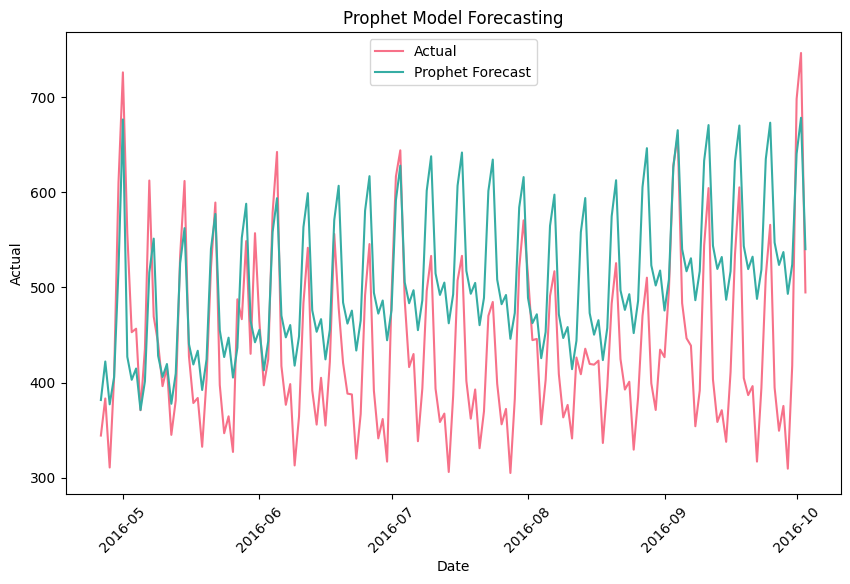

In [15]:
plot_predictions(df_results['date'], df_results['actual'], df_results['yhat'], 'Prophet Forecast', 'Prophet Model Forecasting')

In [11]:
df_train_p.shape

(1935987, 5)

In [12]:
df_test_p.shape

(553141, 5)